## REDD: supervised learning on the energy disaggregation problem

##### Here we test some machine learning algorithm on extracting the refrigerator energy from mains consumptions. REDD contains data of 6 houses. We first train, test the model only on data from house 1 and check how well the model performs on the unseen-pattern data of house 2.  

#### Import packages, read house 1 and house 2 data

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import display
import datetime
import time
import math
import warnings
warnings.filterwarnings("ignore")
import glob

In [2]:
def read_label():
    label = {}
    for i in range(1, 7):
        hi = 'Data/low_freq/house_{}/labels.dat'.format(i)
        label[i] = {}
        with open(hi) as f:
            for line in f:
                splitted_line = line.split(' ')
                label[i][int(splitted_line[0])] = splitted_line[1].strip() + '_' + splitted_line[0]
    return label
labels = read_label()
for i in range(1,7):
    print('House {}: '.format(i), labels[i], '\n')

House 1:  {1: 'mains_1', 2: 'mains_2', 3: 'oven_3', 4: 'oven_4', 5: 'refrigerator_5', 6: 'dishwaser_6', 7: 'kitchen_outlets_7', 8: 'kitchen_outlets_8', 9: 'lighting_9', 10: 'washer_dryer_10', 11: 'microwave_11', 12: 'bathroom_gfi_12', 13: 'electric_heat_13', 14: 'stove_14', 15: 'kitchen_outlets_15', 16: 'kitchen_outlets_16', 17: 'lighting_17', 18: 'lighting_18', 19: 'washer_dryer_19', 20: 'washer_dryer_20'} 

House 2:  {1: 'mains_1', 2: 'mains_2', 3: 'kitchen_outlets_3', 4: 'lighting_4', 5: 'stove_5', 6: 'microwave_6', 7: 'washer_dryer_7', 8: 'kitchen_outlets_8', 9: 'refrigerator_9', 10: 'dishwaser_10', 11: 'disposal_11'} 

House 3:  {1: 'mains_1', 2: 'mains_2', 3: 'outlets_unknown_3', 4: 'outlets_unknown_4', 5: 'lighting_5', 6: 'electronics_6', 7: 'refrigerator_7', 8: 'disposal_8', 9: 'dishwaser_9', 10: 'furance_10', 11: 'lighting_11', 12: 'outlets_unknown_12', 13: 'washer_dryer_13', 14: 'washer_dryer_14', 15: 'lighting_15', 16: 'microwave_16', 17: 'lighting_17', 18: 'smoke_alarms_18'

In [5]:
def read_merge_data(house):
    path = 'data/low_freq/house_{}/'.format(house)
    file = path + 'channel_1.dat'
    df = pd.read_table(file, sep = ' ', names = ['unix_time', labels[house][1]], 
                                       dtype = {'unix_time': 'int64', labels[house][1]:'float64'}) 
    
    num_apps = len(glob.glob(path + 'channel*'))
    for i in range(2, num_apps + 1):
        file = path + 'channel_{}.dat'.format(i)
        data = pd.read_table(file, sep = ' ', names = ['unix_time', labels[house][i]], 
                                       dtype = {'unix_time': 'int64', labels[house][i]:'float64'})
        df = pd.merge(df, data, how = 'inner', on = 'unix_time')
    df['timestamp'] = df['unix_time'].astype("datetime64[s]")
    df = df.set_index(df['timestamp'].values)
    df.drop(['unix_time','timestamp'], axis=1, inplace=True)
    return df
df = {}
for i in range(1,7):
    df[i] = read_merge_data(i)

In [6]:
for i in range(1,7):
    print('House {} data has shape: '.format(i), df[i].shape)
    display(df[i].tail(3))
    

House 1 data has shape:  (406748, 20)


mains_1  mains_2  oven_3  oven_4  refrigerator_5  \
2011-05-24 19:56:27   235.46    38.61     0.0     0.0           190.0   
2011-05-24 19:56:30   235.98    38.77     0.0     0.0           189.0   
2011-05-24 19:56:34   235.29    38.83     0.0     0.0           186.0   

                     dishwaser_6  kitchen_outlets_7  kitchen_outlets_8  \
2011-05-24 19:56:27          0.0               24.0               20.0   
2011-05-24 19:56:30          0.0               24.0               20.0   
2011-05-24 19:56:34          0.0               26.0               20.0   

                     lighting_9  washer_dryer_10  microwave_11  \
2011-05-24 19:56:27         2.0              0.0           4.0   
2011-05-24 19:56:30         2.0              0.0           4.0   
2011-05-24 19:56:34         2.0              0.0           4.0   

                     bathroom_gfi_12  electric_heat_13  stove_14  \
2011-05-24 19:56:27              1.0               0.0       0.0   
2011-05-24 19:56:30              1.0               0.0       0.0   
2011-05-24 19:56:34              1.0               0.0       0.0   

                     kitchen_outlets_15  kitchen_outlets_16  lighting_17  \
2011-05-24 19:56:27                 1.0                 0.0          0.0   
2011-05-24 19:56:30                 1.0                 0.0          0.0   
2011-05-24 19:56:34                 1.0                 0.0          0.0   

                     lighting_18  washer_dryer_19  washer_dryer_20  
2011-05-24 19:56:27          1.0              0.0              0.0  
2011-05-24 19:56:30          1.0              0.0              0.0  
2011-05-24 19:56:34          1.0              0.0              0.0

House 2 data has shape:  (316840, 11)


mains_1  mains_2  kitchen_outlets_3  lighting_4  stove_5  \
2011-05-22 23:59:01    10.84   252.61                0.0         9.0      0.0   
2011-05-22 23:59:04    10.88   253.02                0.0         9.0      0.0   
2011-05-22 23:59:08    10.84   252.77                0.0         9.0      0.0   

                     microwave_6  washer_dryer_7  kitchen_outlets_8  \
2011-05-22 23:59:01          5.0             0.0                2.0   
2011-05-22 23:59:04          4.0             0.0                2.0   
2011-05-22 23:59:08          4.0             0.0                2.0   

                     refrigerator_9  dishwaser_10  disposal_11  
2011-05-22 23:59:01           158.0           0.0          0.0  
2011-05-22 23:59:04           160.0           0.0          0.0  
2011-05-22 23:59:08           157.0           0.0          0.0

House 3 data has shape:  (376150, 22)


mains_1  mains_2  outlets_unknown_3  outlets_unknown_4  \
2011-05-31 00:19:30    15.45     2.23                0.0                1.0   
2011-05-31 00:19:33    15.42     2.23                0.0                1.0   
2011-05-31 00:19:36    15.44     2.23                0.0                1.0   

                     lighting_5  electronics_6  refrigerator_7  disposal_8  \
2011-05-31 00:19:30         1.0         1139.0             8.0         6.0   
2011-05-31 00:19:33         1.0         1138.0             8.0         6.0   
2011-05-31 00:19:36         1.0         1134.0             7.0         6.0   

                     dishwaser_9  furance_10  ...  washer_dryer_13  \
2011-05-31 00:19:30          3.0         7.0  ...              0.0   
2011-05-31 00:19:33          3.0         7.0  ...              0.0   
2011-05-31 00:19:36          3.0         7.0  ...              0.0   

                     washer_dryer_14  lighting_15  microwave_16  lighting_17  \
2011-05-31 00:19:30              0.0          1.0           2.0         10.0   
2011-05-31 00:19:33              0.0          1.0           2.0         10.0   
2011-05-31 00:19:36              0.0          1.0           2.0         10.0   

                     smoke_alarms_18  lighting_19  bathroom_gfi_20  \
2011-05-31 00:19:30              0.0          0.0              0.0   
2011-05-31 00:19:33              0.0          0.0              0.0   
2011-05-31 00:19:36              0.0          0.0              0.0   

                     kitchen_outlets_21  kitchen_outlets_22  
2011-05-31 00:19:30                 0.0                 2.5  
2011-05-31 00:19:33                 0.0                 2.5  
2011-05-31 00:19:36                 0.0                 2.5  

[3 rows x 22 columns]

House 4 data has shape:  (428076, 20)


mains_1  mains_2  lighting_3  furance_4  \
2011-06-04 00:45:31   403.36    94.65       173.0       27.0   
2011-06-04 00:45:35   401.11    94.63       174.0       27.0   
2011-06-04 00:45:38   400.24    94.43       175.0       27.0   

                     kitchen_outlets_5  outlets_unknown_6  washer_dryer_7  \
2011-06-04 00:45:31               38.0                3.0             1.0   
2011-06-04 00:45:35               34.0                4.0             1.0   
2011-06-04 00:45:38               38.0                4.0             1.0   

                     stove_8  air_conditioning_9  air_conditioning_10  \
2011-06-04 00:45:31      5.0                 0.0                  0.0   
2011-06-04 00:45:35      5.0                 0.0                  0.0   
2011-06-04 00:45:38      5.0                 0.0                  0.0   

                     miscellaeneous_11  smoke_alarms_12  lighting_13  \
2011-06-04 00:45:31                1.0              0.0         25.0   
2011-06-04 00:45:35                1.0              0.0         25.0   
2011-06-04 00:45:38                2.0              0.0         25.0   

                     kitchen_outlets_14  dishwaser_15  bathroom_gfi_16  \
2011-06-04 00:45:31               135.0           0.0              0.0   
2011-06-04 00:45:35               135.0           0.0              0.0   
2011-06-04 00:45:38               135.0           0.0              0.0   

                     bathroom_gfi_17  lighting_18  lighting_19  \
2011-06-04 00:45:31              1.0          0.0          0.0   
2011-06-04 00:45:35              1.0          0.0          0.0   
2011-06-04 00:45:38              1.0          0.0          0.0   

                     air_conditioning_20  
2011-06-04 00:45:31                  0.0  
2011-06-04 00:45:35                  0.0  
2011-06-04 00:45:38                  0.0

House 5 data has shape:  (77451, 26)


mains_1  mains_2  microwave_3  lighting_4  \
2011-06-01 00:20:07   151.68    37.39          3.0         0.0   
2011-06-01 00:20:10   150.42    37.21          3.0         0.0   
2011-06-01 00:20:14   149.29    37.10          3.0         0.0   

                     outlets_unknown_5  furance_6  outlets_unknown_7  \
2011-06-01 00:20:07                3.0        7.0                0.0   
2011-06-01 00:20:10                3.0        7.0                0.0   
2011-06-01 00:20:14                3.0        7.0                0.0   

                     washer_dryer_8  washer_dryer_9  subpanel_10  ...  \
2011-06-01 00:20:07             0.0             0.0         12.5  ...   
2011-06-01 00:20:10             0.0             0.0         12.5  ...   
2011-06-01 00:20:14             0.0             0.0         12.5  ...   

                     lighting_17  refrigerator_18  lighting_19  dishwaser_20  \
2011-06-01 00:20:07          0.0              0.0          2.0           0.0   
2011-06-01 00:20:10          0.0              1.0          2.0           0.0   
2011-06-01 00:20:14          0.0              0.0          2.0           0.0   

                     disposal_21  electronics_22  lighting_23  \
2011-06-01 00:20:07          0.0             5.0        115.0   
2011-06-01 00:20:10          0.0             5.0        100.0   
2011-06-01 00:20:14          0.0             5.0         97.5   

                     kitchen_outlets_24  kitchen_outlets_25  \
2011-06-01 00:20:07                 0.0                 0.0   
2011-06-01 00:20:10                 0.0                 0.0   
2011-06-01 00:20:14                 0.0                 0.0   

                     outdoor_outlets_26  
2011-06-01 00:20:07                 0.0  
2011-06-01 00:20:10                 0.0  
2011-06-01 00:20:14                 0.0  

[3 rows x 26 columns]

House 6 data has shape:  (192192, 17)


mains_1  mains_2  kitchen_outlets_3  washer_dryer_4  \
2011-06-14 01:12:25    19.82   401.65                4.0             3.0   
2011-06-14 01:12:33    19.59   400.11                4.0             3.0   
2011-06-14 01:12:36    19.59   399.47                4.0             3.0   

                     stove_5  electronics_6  bathroom_gfi_7  refrigerator_8  \
2011-06-14 01:12:25      1.0            0.0             4.0           140.0   
2011-06-14 01:12:33      1.0            0.0             3.0           143.0   
2011-06-14 01:12:36      1.0            0.0             3.0           143.0   

                     dishwaser_9  outlets_unknown_10  outlets_unknown_11  \
2011-06-14 01:12:25          0.0                87.0                 0.0   
2011-06-14 01:12:33          0.0                87.0                 0.0   
2011-06-14 01:12:36          0.0                87.0                 0.0   

                     electric_heat_12  kitchen_outlets_13  lighting_14  \
2011-06-14 01:12:25               7.0                 1.0        114.0   
2011-06-14 01:12:33               7.0                 1.0        113.0   
2011-06-14 01:12:36               7.0                 0.0        113.0   

                     air_conditioning_15  air_conditioning_16  \
2011-06-14 01:12:25                  4.0                  0.0   
2011-06-14 01:12:33                  4.0                  0.0   
2011-06-14 01:12:36                  4.0                  0.0   

                     air_conditioning_17  
2011-06-14 01:12:25                  0.0  
2011-06-14 01:12:33                  0.0  
2011-06-14 01:12:36                  0.0

In [8]:
dates = {}
for i in range(1,7):
    dates[i] = [str(time)[:10] for time in df[i].index.values]
    dates[i] = sorted(list(set(dates[i])))
    print('House {0} data contain {1} days from {2} to {3}.'.format(i,len(dates[i]),dates[i][0], dates[i][-1]))
    print(dates[i], '\n')

House 1 data contain 23 days from 2011-04-18 to 2011-05-24.
['2011-04-18', '2011-04-19', '2011-04-20', '2011-04-21', '2011-04-22', '2011-04-23', '2011-04-24', '2011-04-25', '2011-04-26', '2011-04-27', '2011-04-28', '2011-04-30', '2011-05-01', '2011-05-02', '2011-05-03', '2011-05-06', '2011-05-07', '2011-05-11', '2011-05-12', '2011-05-13', '2011-05-22', '2011-05-23', '2011-05-24'] 

House 2 data contain 16 days from 2011-04-18 to 2011-05-22.
['2011-04-18', '2011-04-19', '2011-04-20', '2011-04-21', '2011-04-22', '2011-04-23', '2011-04-24', '2011-04-25', '2011-04-26', '2011-04-27', '2011-04-28', '2011-04-29', '2011-04-30', '2011-05-01', '2011-05-02', '2011-05-22'] 

House 3 data contain 26 days from 2011-04-16 to 2011-05-31.
['2011-04-16', '2011-04-17', '2011-04-18', '2011-04-19', '2011-04-20', '2011-04-21', '2011-04-22', '2011-04-23', '2011-04-24', '2011-04-25', '2011-04-26', '2011-04-27', '2011-04-28', '2011-05-17', '2011-05-18', '2011-05-19', '2011-05-21', '2011-05-22', '2011-05-23', '

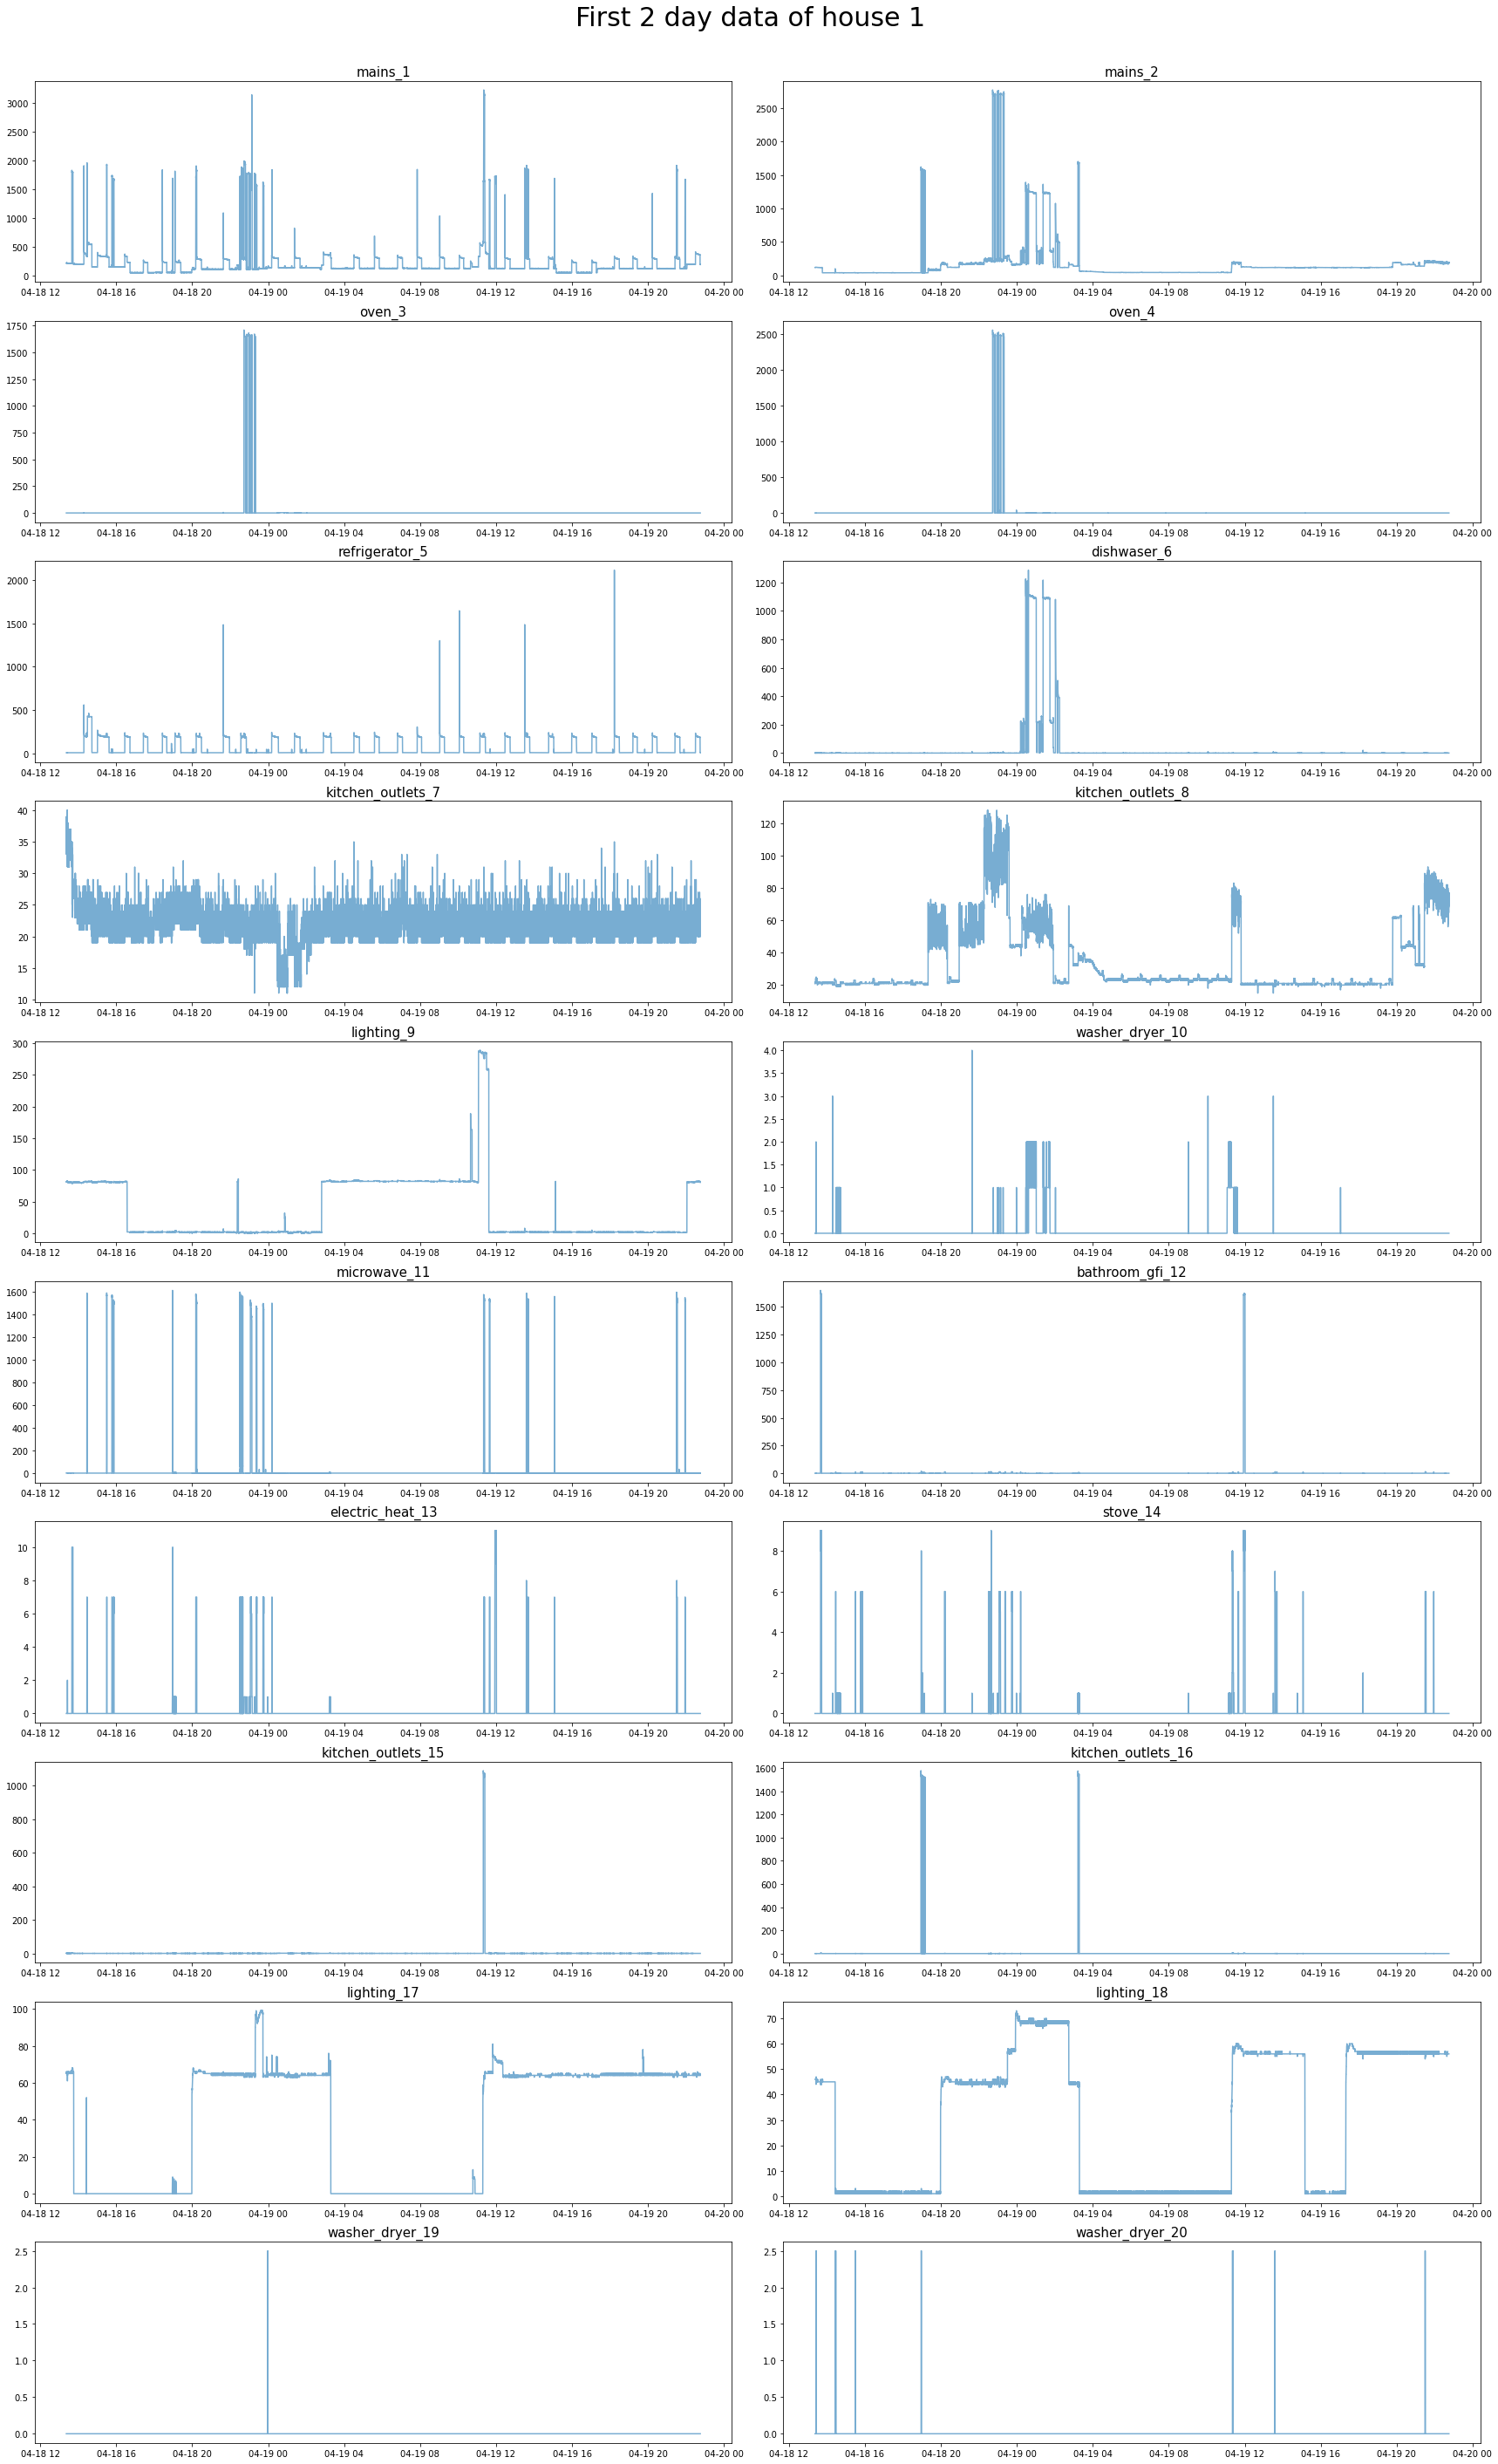

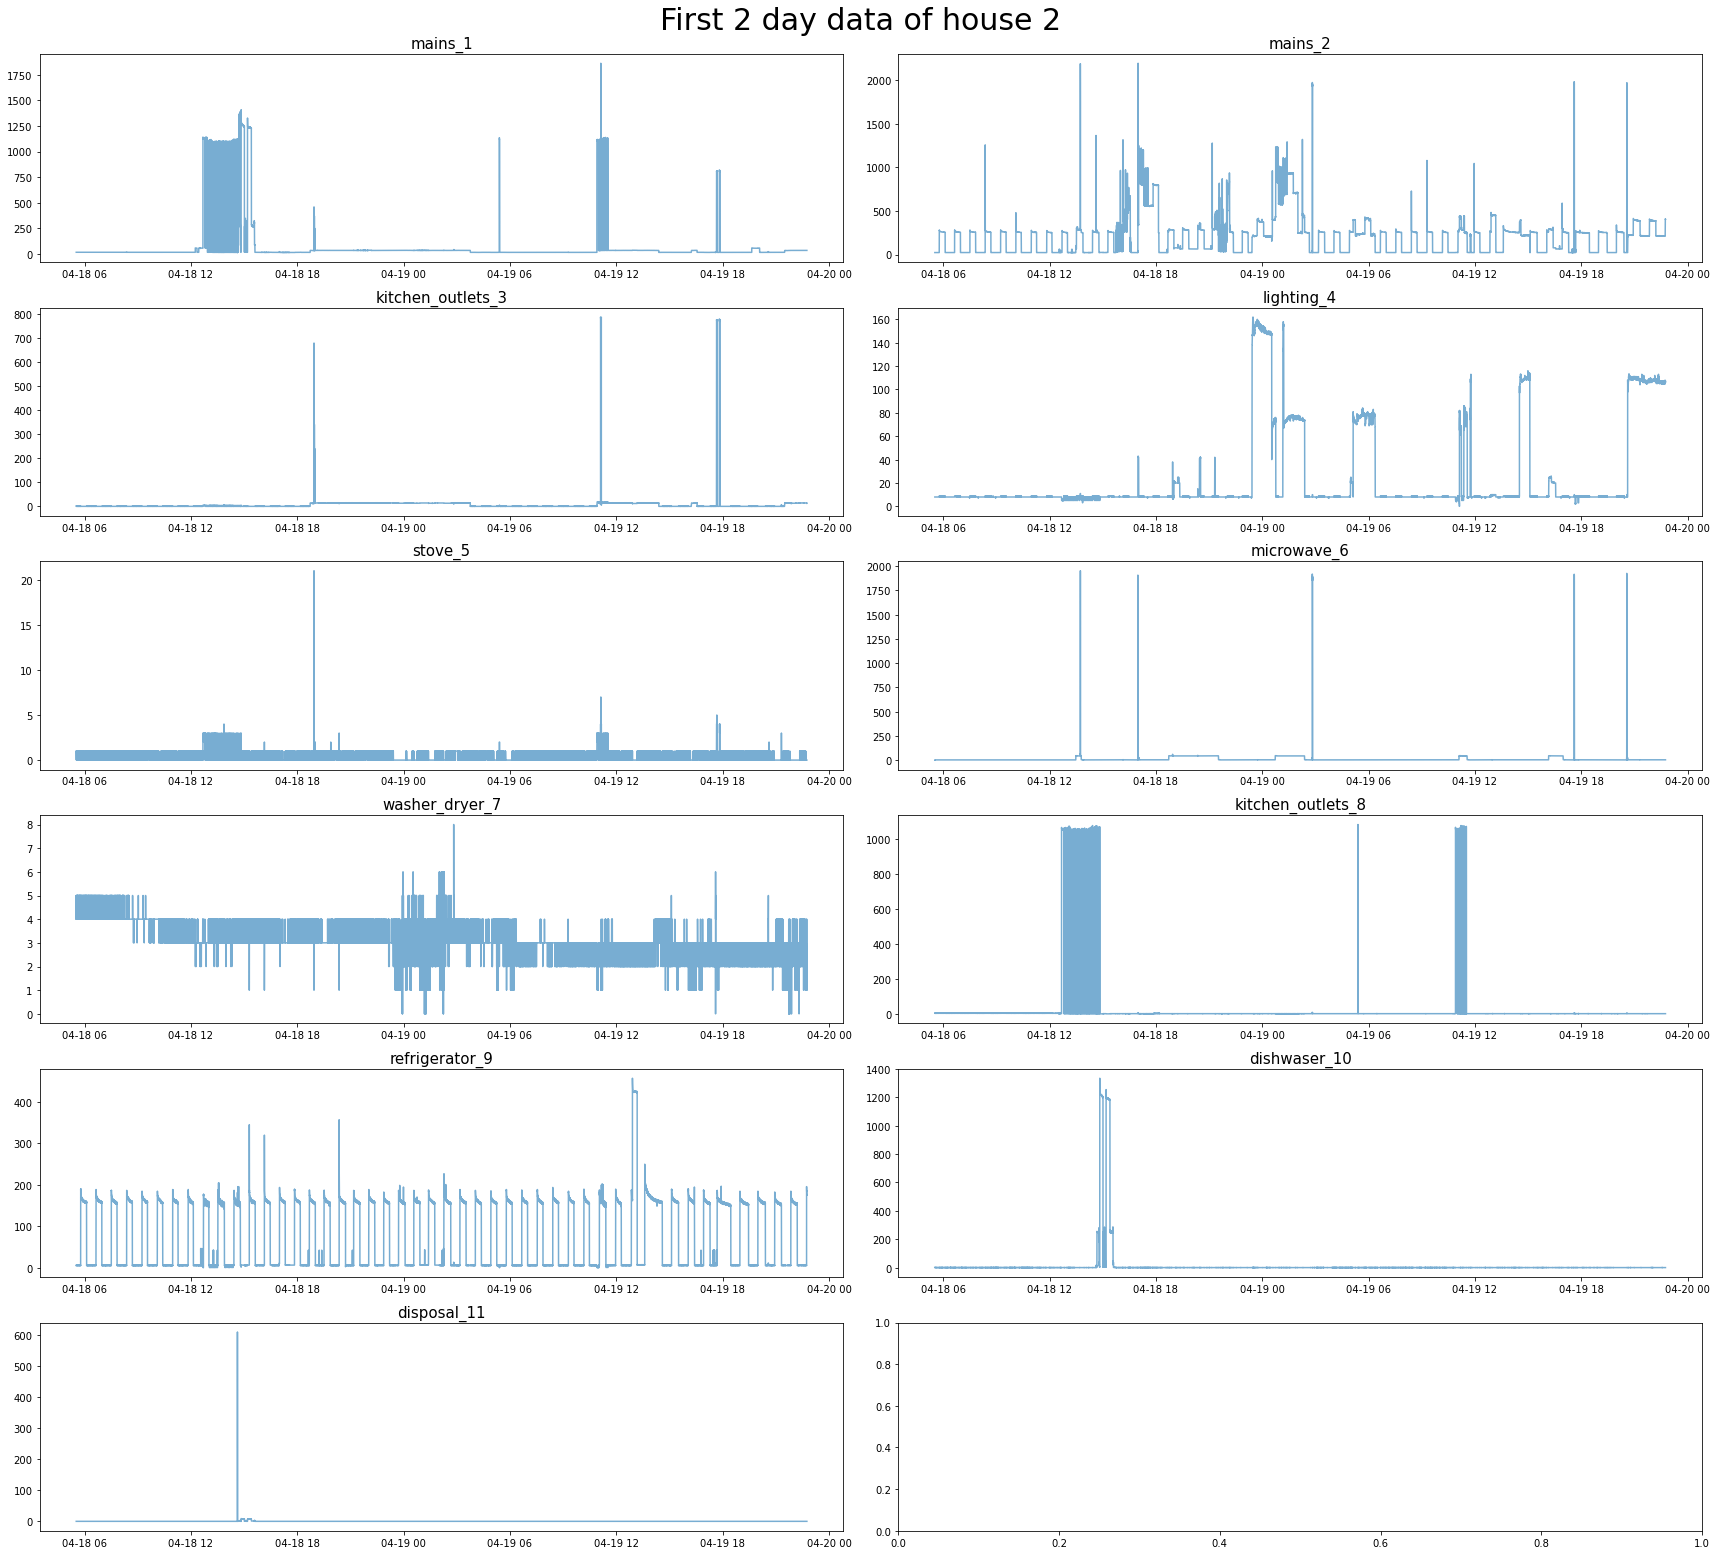

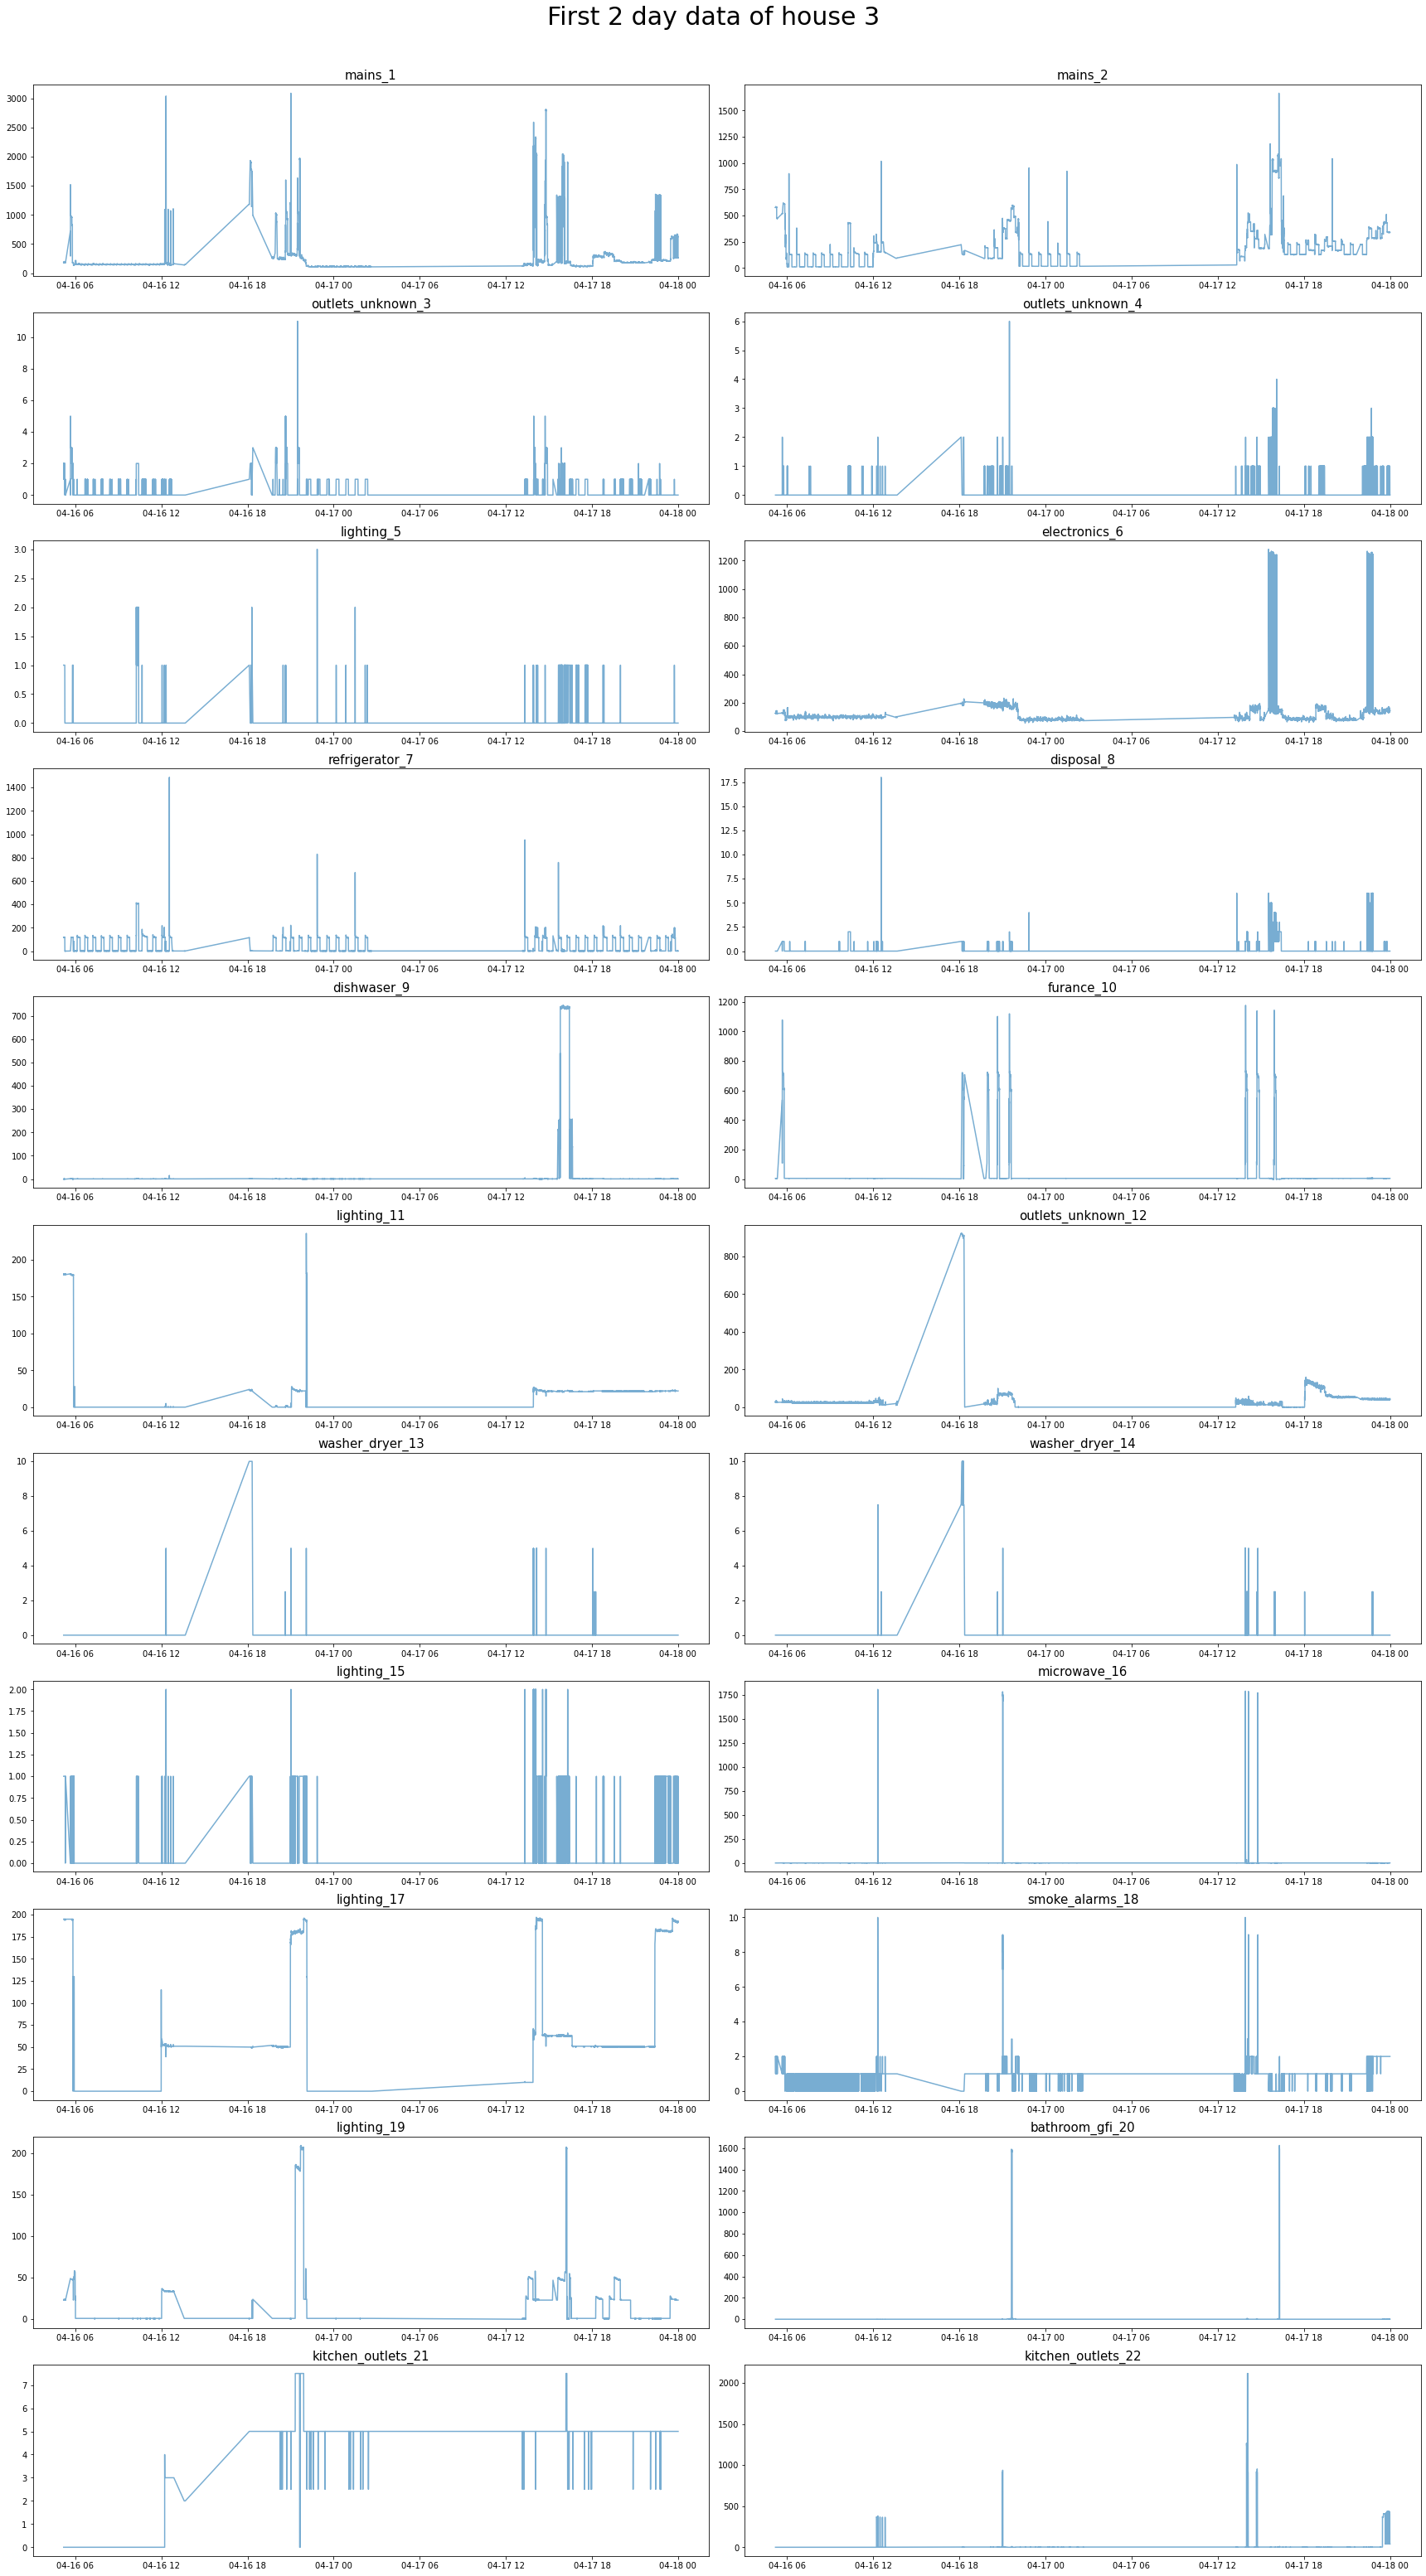

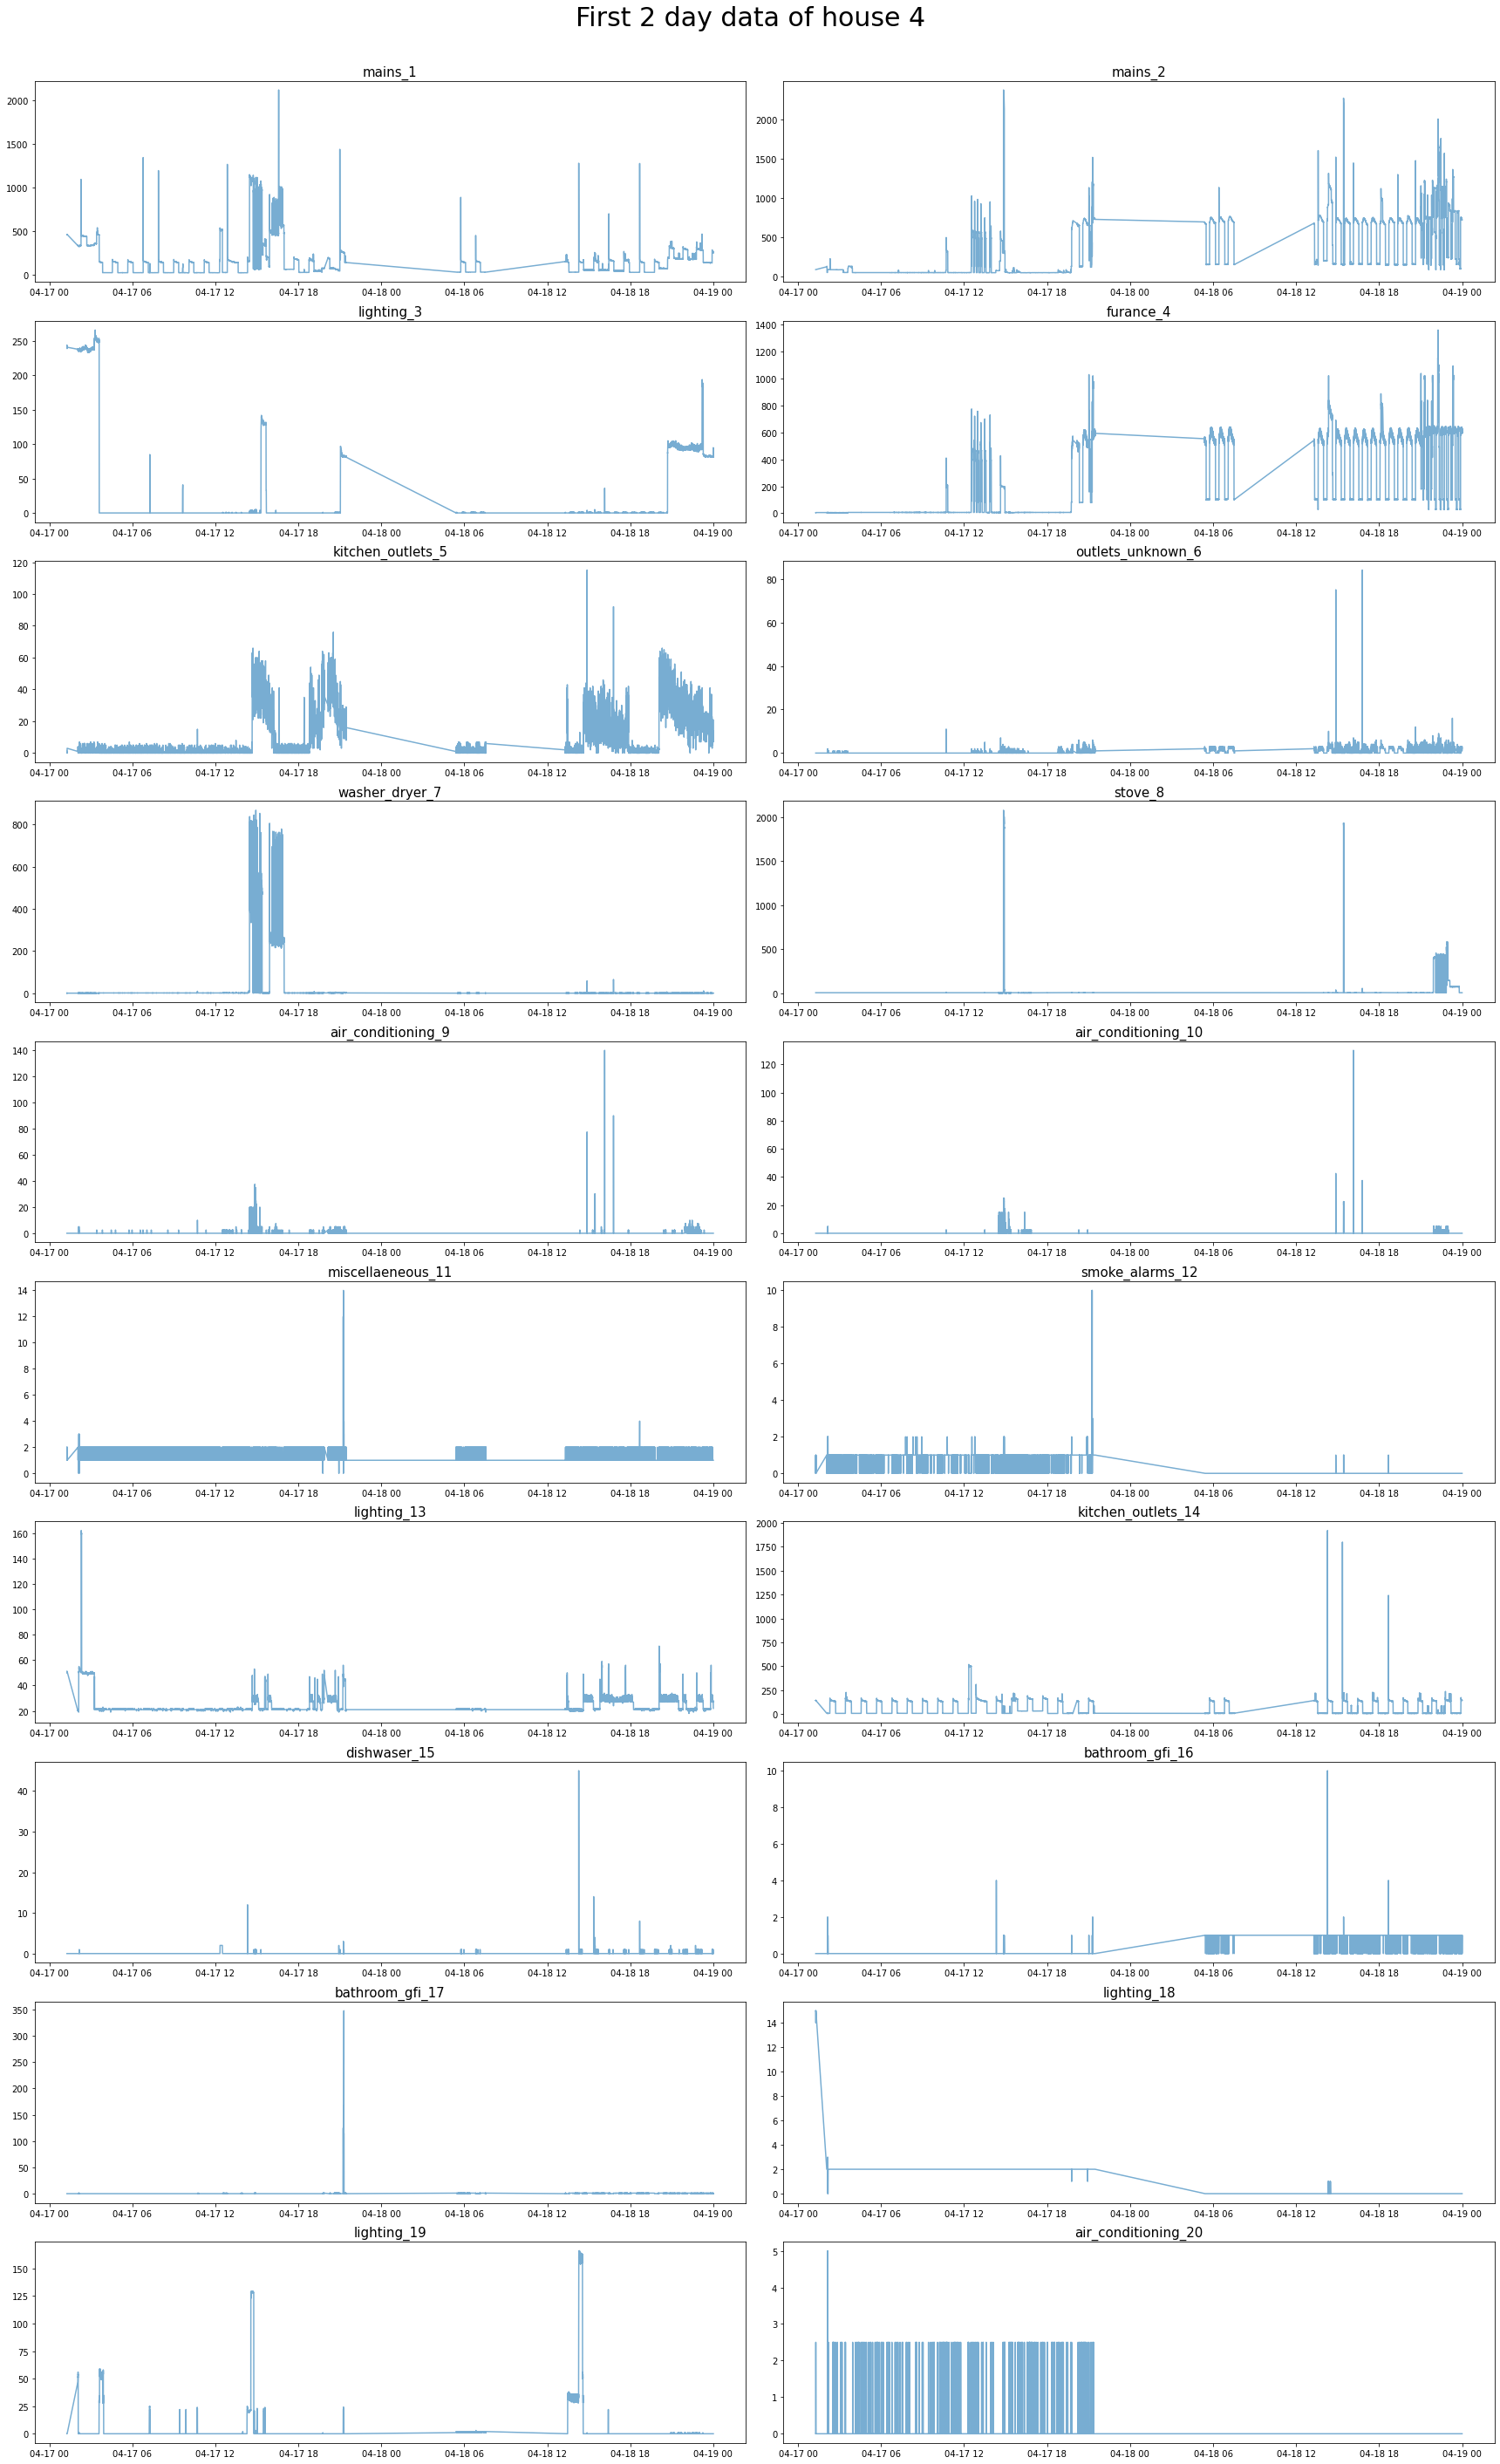

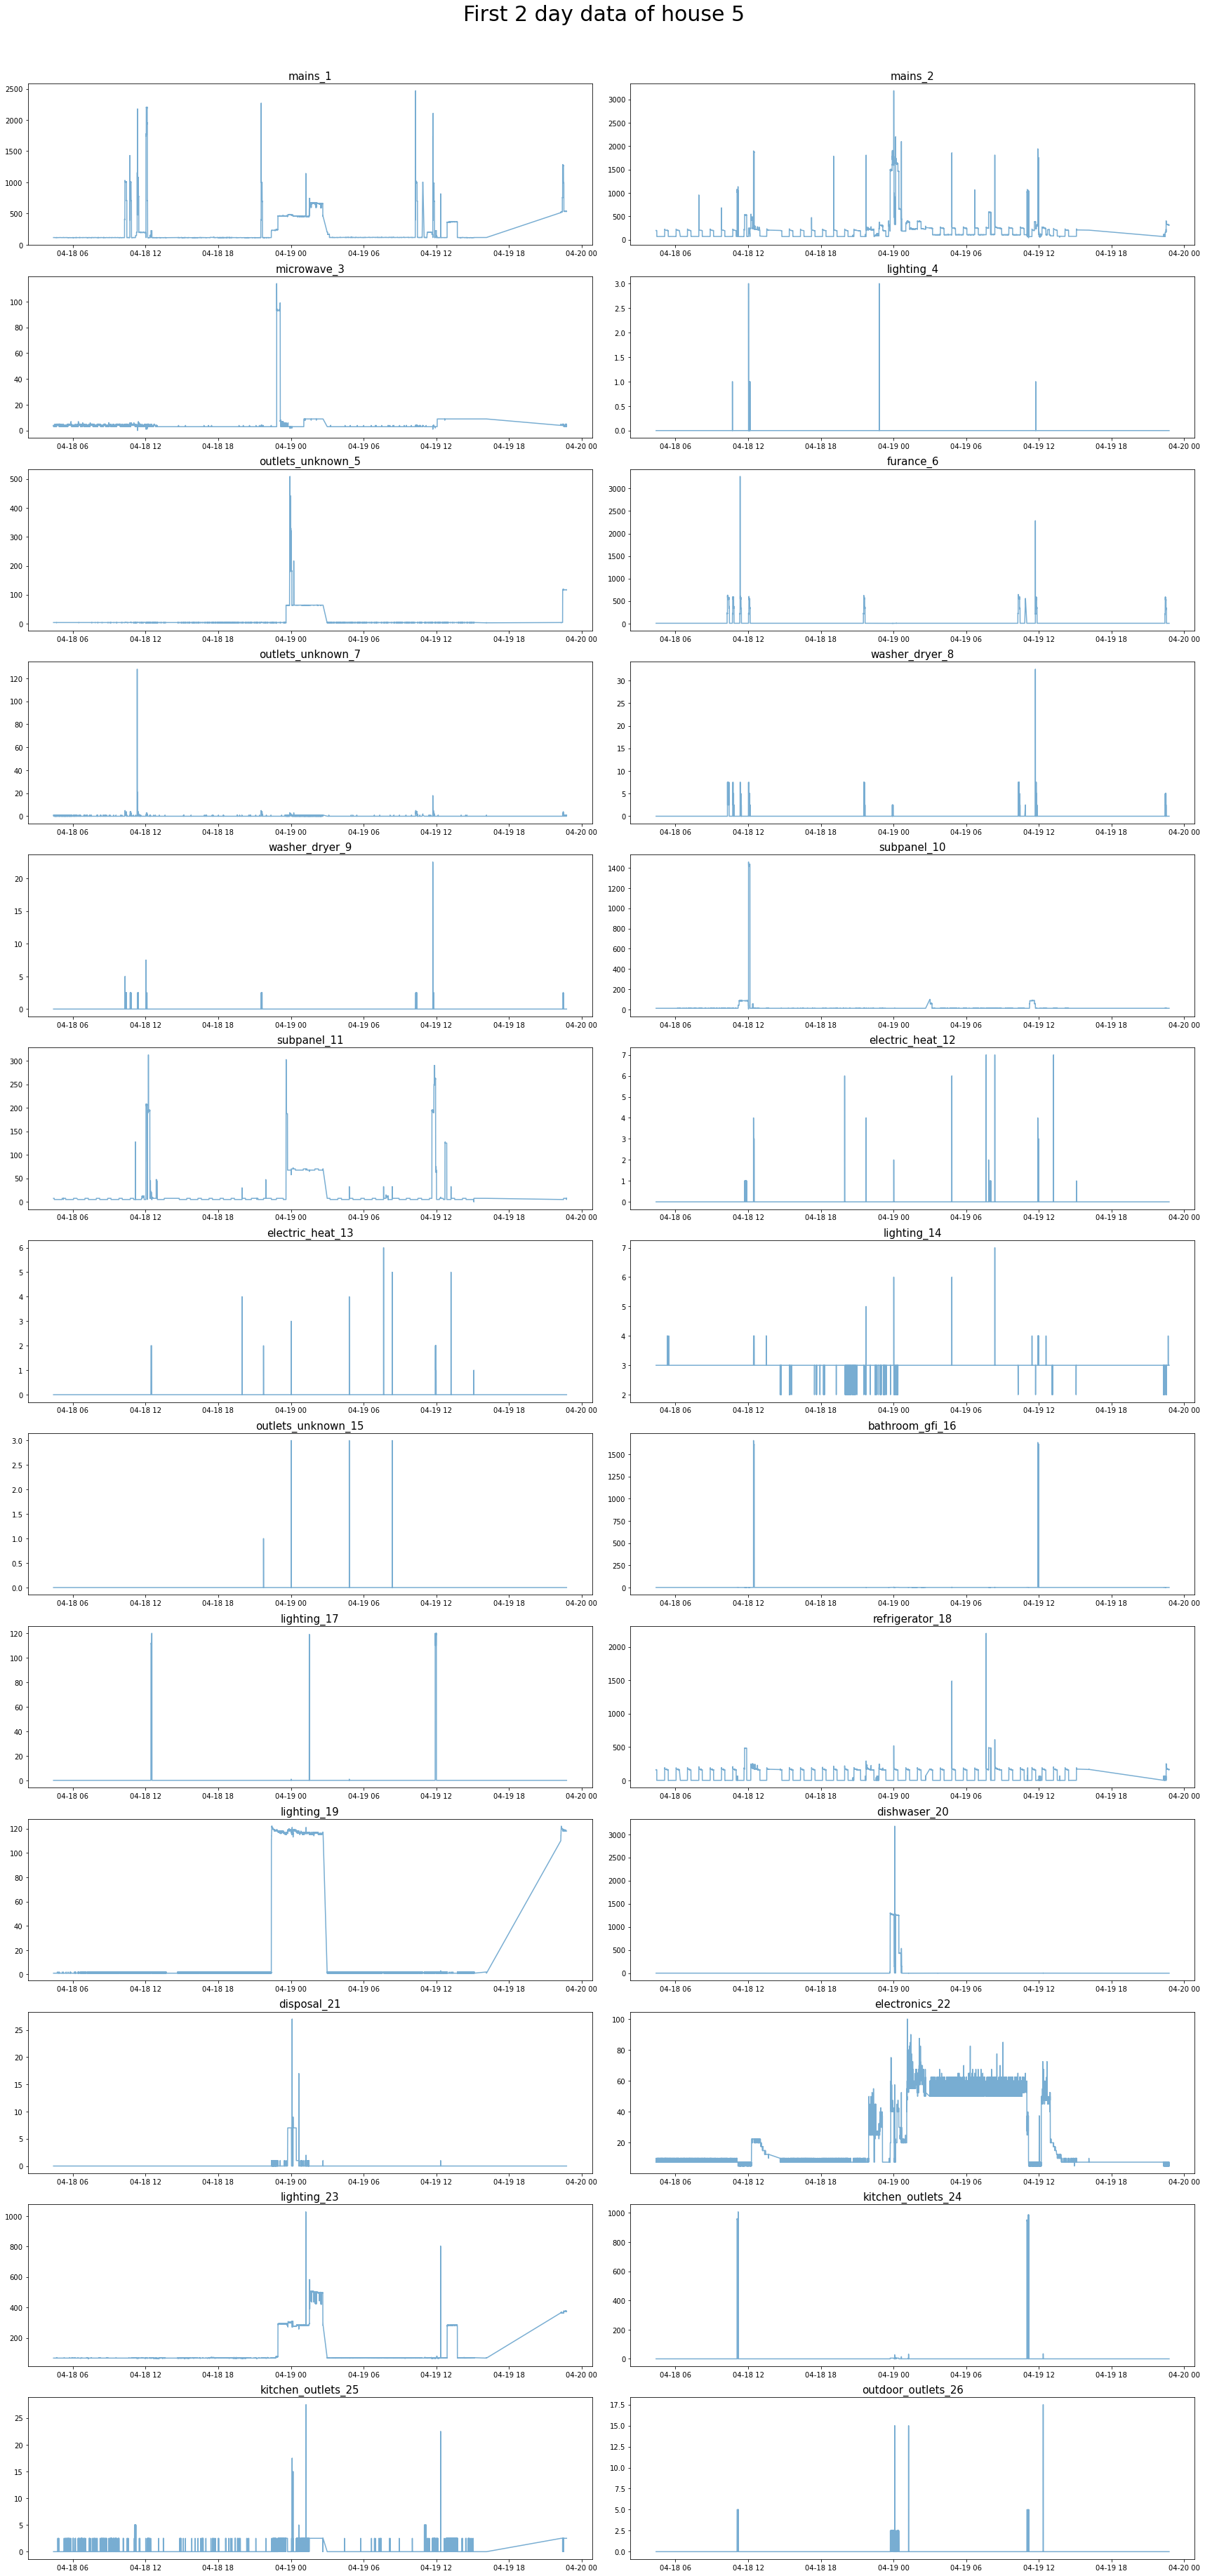

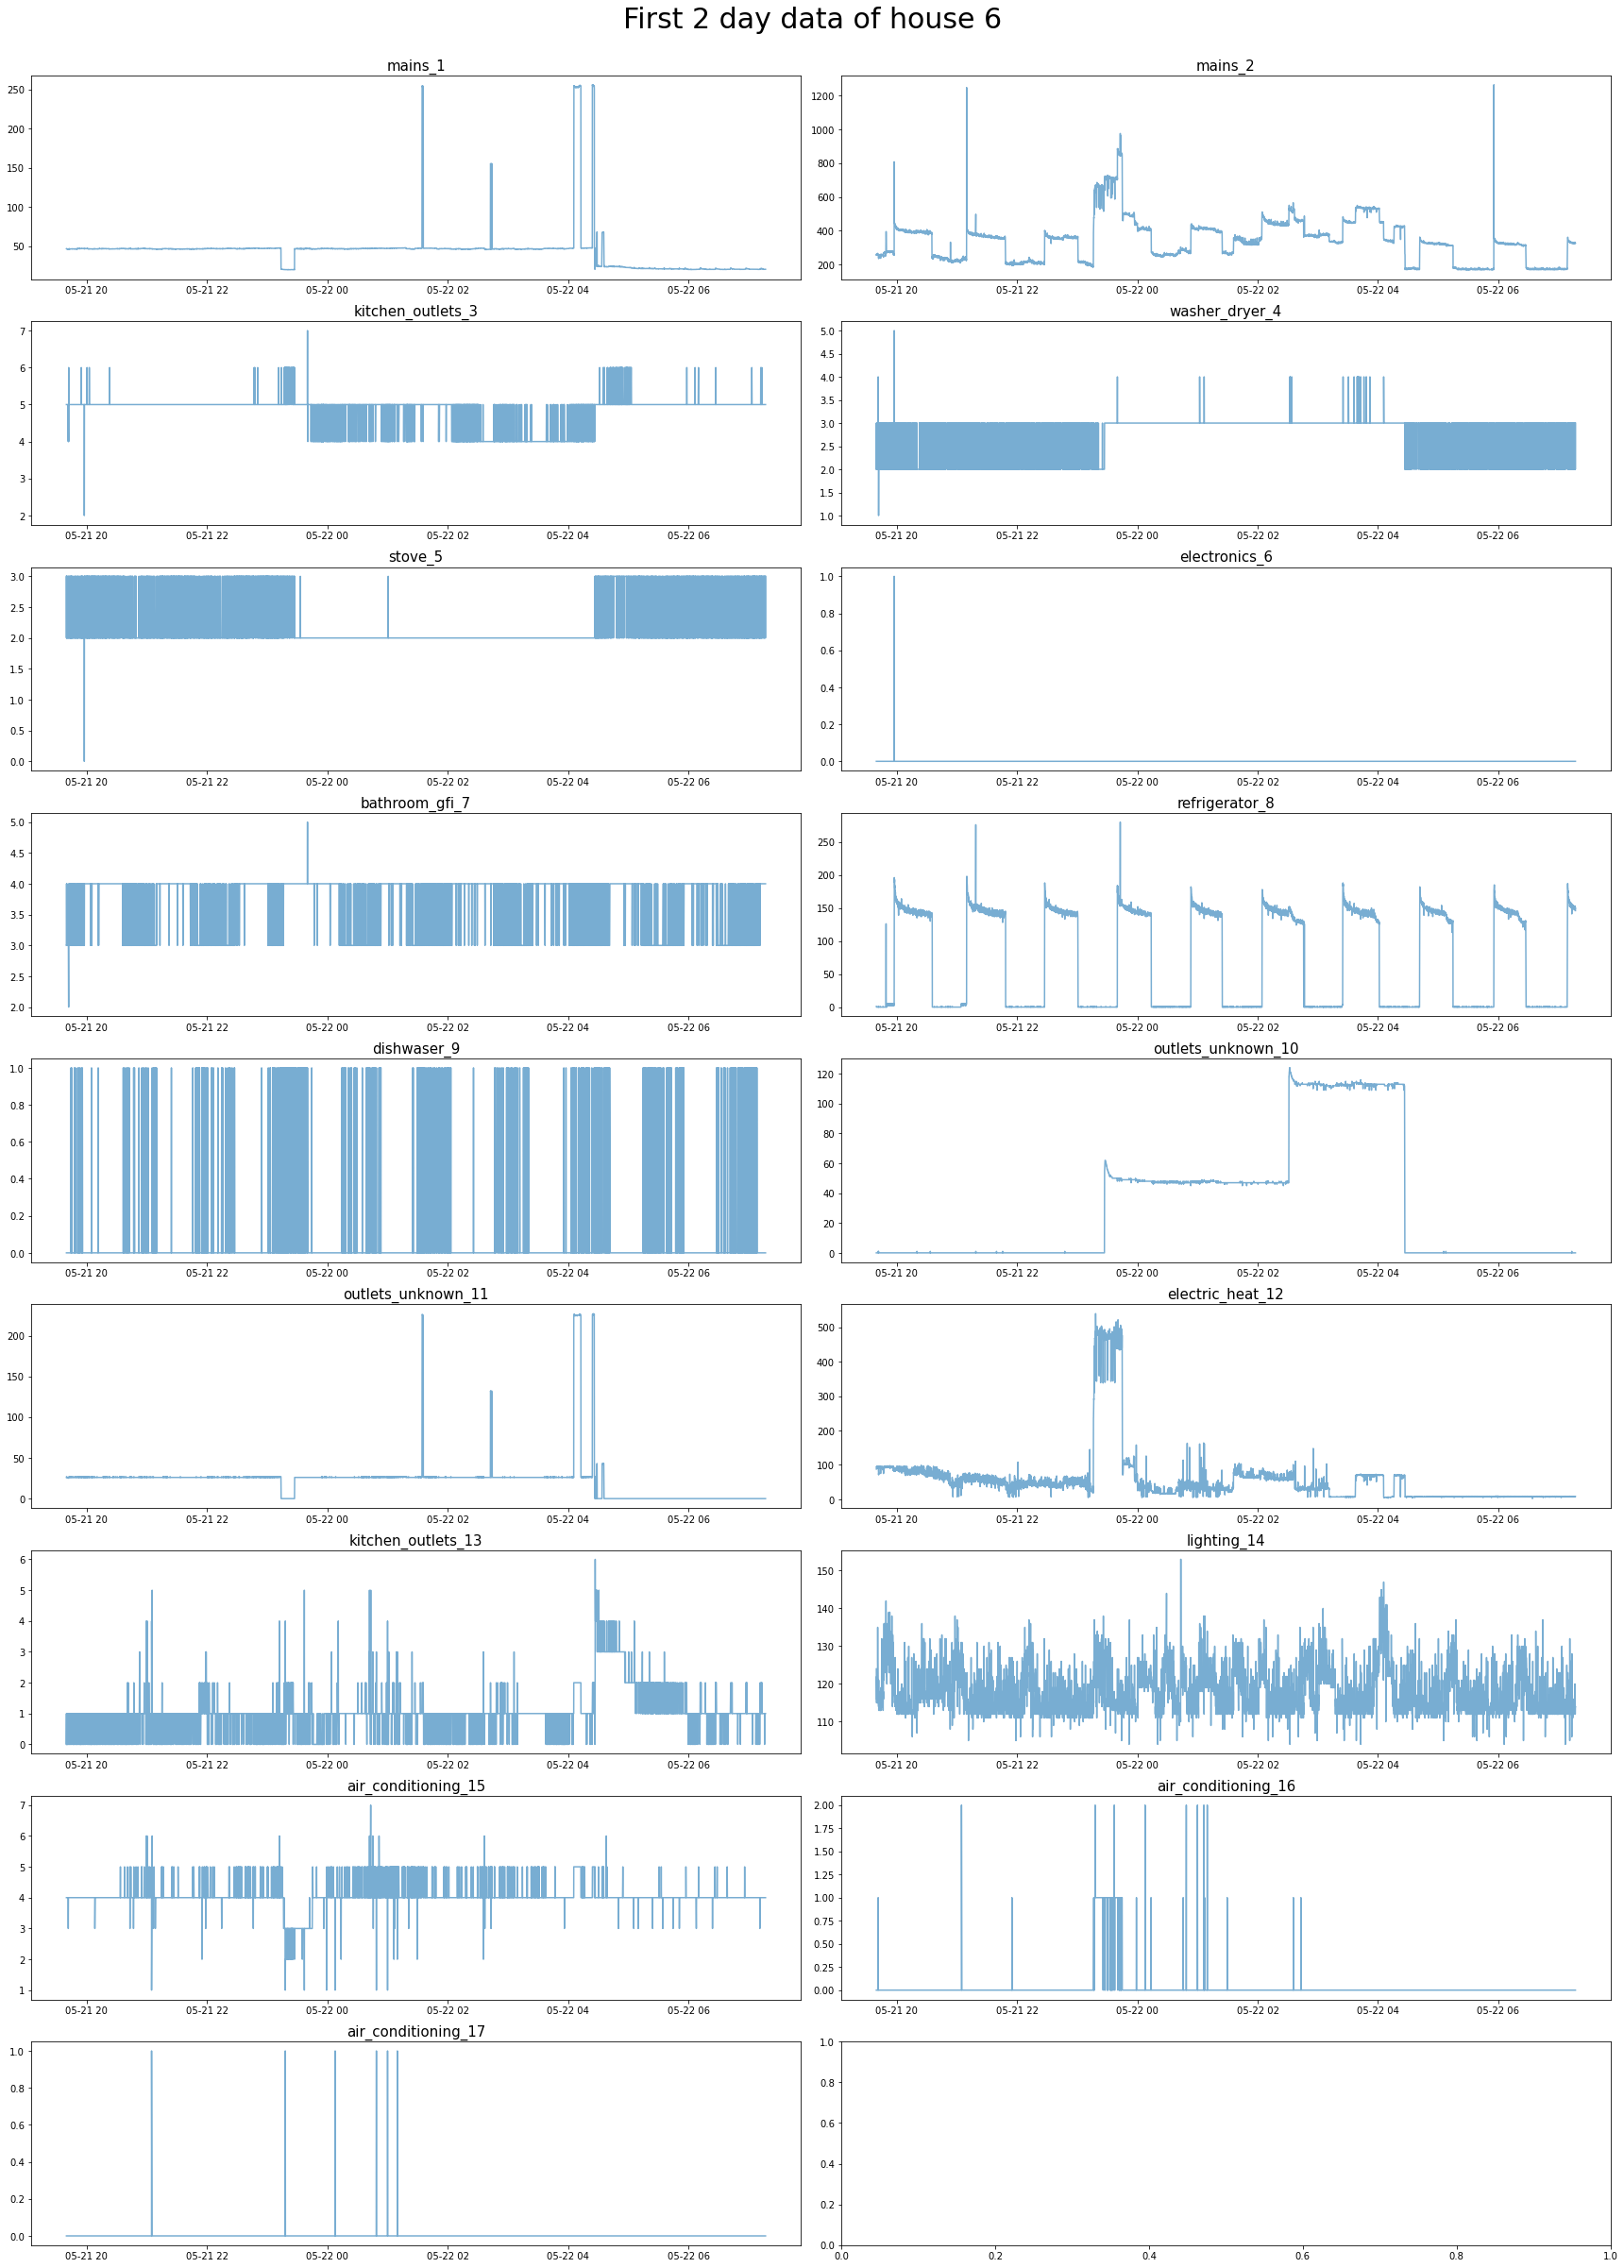

In [9]:
# Plot 2 first day data of house 1 and 2
def plot_df(df, title):
    apps = df.columns.values
    num_apps = len(apps) 
    fig, axes = plt.subplots((num_apps+1)//2,2, figsize=(24, num_apps*2) )
    for i, key in enumerate(apps):
        axes.flat[i].plot(df[key], alpha = 0.6)
        axes.flat[i].set_title(key, fontsize = '15')
    plt.suptitle(title, fontsize = '30')
    fig.tight_layout()
    fig.subplots_adjust(top=0.95)

for i in range(1,7):
    plot_df(df[i].loc[:dates[i][1]], 'First 2 day data of house {}'.format(i))

Text(0.5, 1.0, 'House 6')

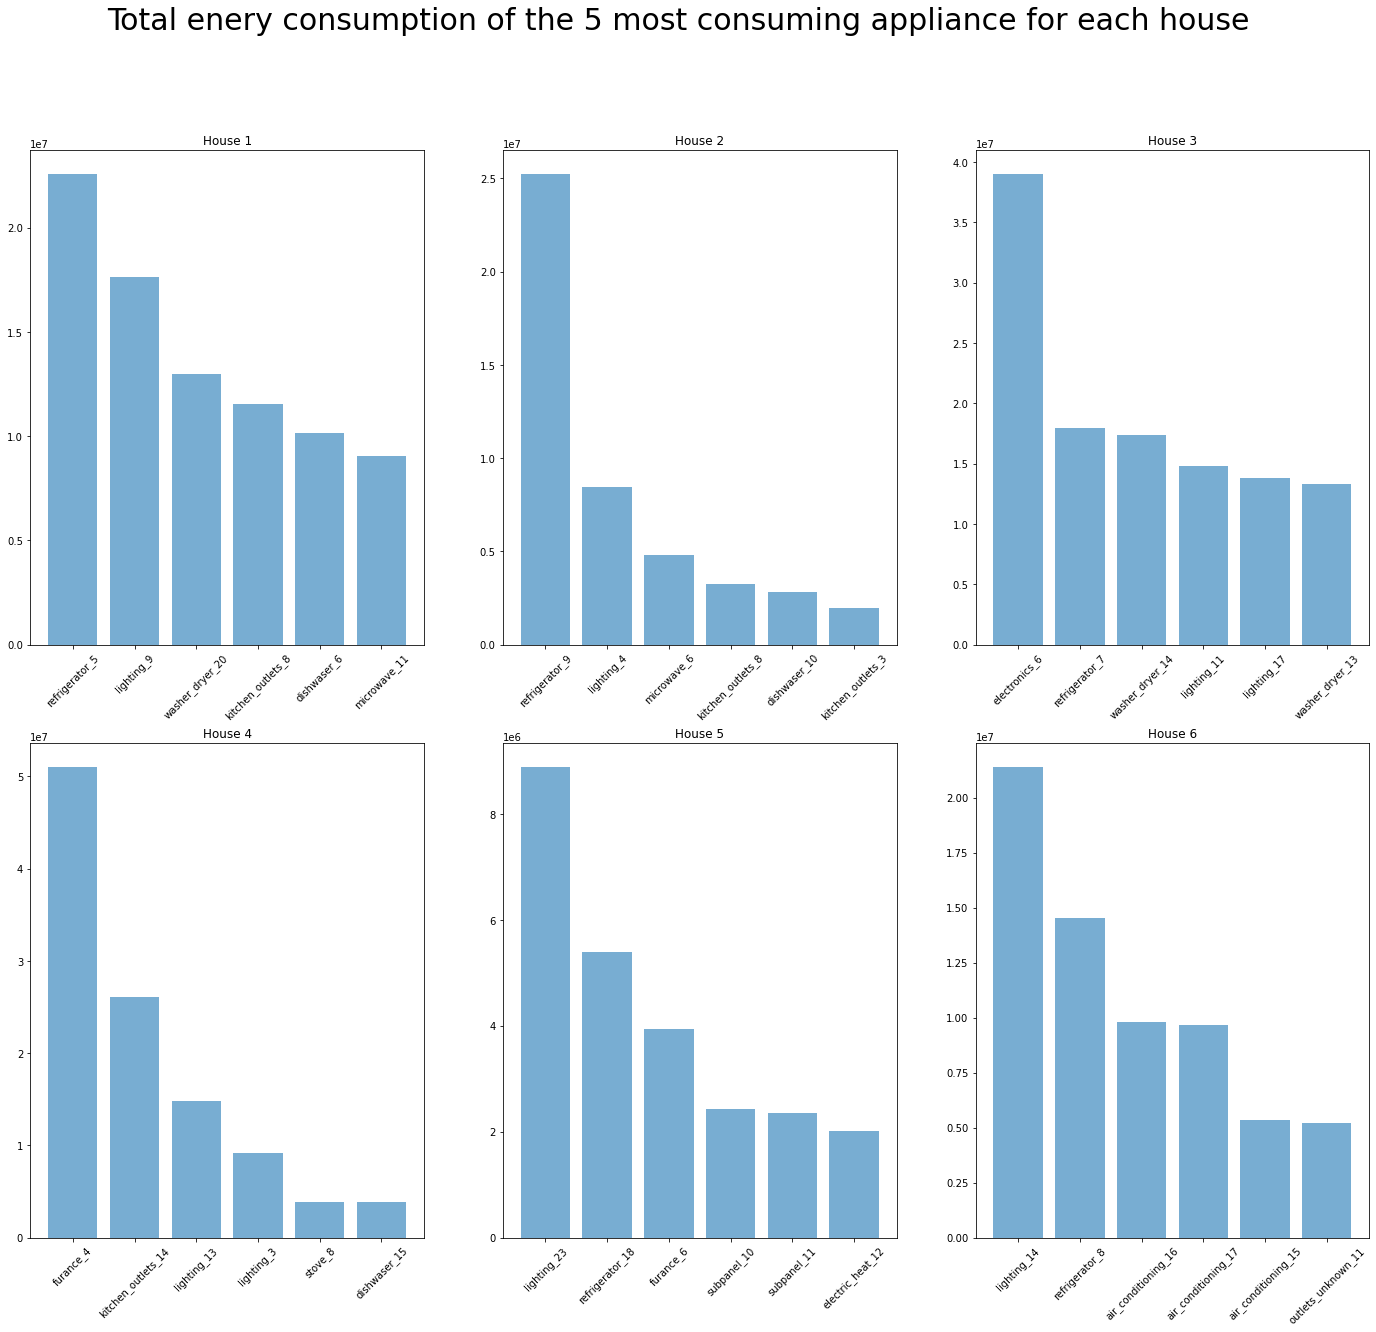

In [36]:
# Plot total energy sonsumption of each appliance from two houses
fig, axes = plt.subplots(2,3,figsize=(24, 20))
plt.suptitle('Total enery consumption of the 5 most consuming appliance for each house', fontsize = 30)
cons1 = df[1][df[1].columns.values[2:]].sum().sort_values(ascending=False)
app1 = cons1.index
y_pos1 = np.arange(len(app1))
axes[0,0].bar(y_pos1[:6], cons1.values[:6],  alpha=0.6) 
plt.sca(axes[0,0])
plt.xticks(y_pos1[:6], app1[:6], rotation = 45)
plt.title('House 1')

cons2 = df[2][df[2].columns.values[2:]].sum().sort_values(ascending=False)
app2 = cons2.index
y_pos2 = np.arange(len(app2))
axes[0,1].bar(y_pos2[:6], cons2.values[:6], alpha=0.6)
plt.sca(axes[0,1])
plt.xticks(y_pos2[:6], app2[:6], rotation = 45)
plt.title('House 2')

cons3 = df[3][df[3].columns.values[2:]].sum().sort_values(ascending=False)
app3 = cons3.index
y_pos3 = np.arange(len(app3))
axes[0,2].bar(y_pos3[:6], cons3.values[:6], alpha=0.6)
plt.sca(axes[0,2])
plt.xticks(y_pos3[:6], app3[:6], rotation = 45)
plt.title('House 3')

cons4 = df[4][df[4].columns.values[2:]].sum().sort_values(ascending=False)
app4 = cons4.index
y_pos4 = np.arange(len(app4))
axes[1,0].bar(y_pos4[:6], cons4.values[:6], alpha=0.6)
plt.sca(axes[1,0])
plt.xticks(y_pos4[:6], app4[:6], rotation = 45)
plt.title('House 4')

cons5 = df[5][df[5].columns.values[2:]].sum().sort_values(ascending=False)
app5 = cons5.index
y_pos5 = np.arange(len(app5))
axes[1,1].bar(y_pos5[:6], cons5.values[:6], alpha=0.6)
plt.sca(axes[1,1])
plt.xticks(y_pos5[:6], app5[:6], rotation = 45)
plt.title('House 5')

cons6 = df[6][df[6].columns.values[2:]].sum().sort_values(ascending=False)
app6 = cons6.index
y_pos6 = np.arange(len(app6))
axes[1,2].bar(y_pos6[:6], cons6.values[:6], alpha=0.6)
plt.sca(axes[1,2])
plt.xticks(y_pos6[:6], app6[:6], rotation = 45)
plt.title('House 6')




### Train and test on house 1 - Decision tree regression

In [10]:
# Separate house 1 data into train, validation and test data
df1_train = df[1].loc[:dates[1][10]]
df1_val = df[1].loc[dates[1][11]:dates[1][16]]
df1_test = df[1].loc[dates[1][17]:]
print('df_train.shape: ', df1_train.shape)
print('df_val.shape: ', df1_val.shape)
print('df_test.shape: ', df1_test.shape)

df_train.shape:  (214816, 20)
df_val.shape:  (104875, 20)
df_test.shape:  (87057, 20)


In [11]:
# Using mains_1, mains_2 to predict refrigerator
X_train1 = df1_train[['mains_1','mains_2']].values
y_train1 = df1_train['refrigerator_5'].values
X_val1 = df1_val[['mains_1','mains_2']].values
y_val1 = df1_val['refrigerator_5'].values
X_test1 = df1_test[['mains_1','mains_2']].values
y_test1 = df1_test['refrigerator_5'].values
print(X_train1.shape, y_train1.shape, X_val1.shape, y_val1.shape, X_test1.shape, y_test1.shape)

(214816, 2) (214816,) (104875, 2) (104875,) (87057, 2) (87057,)


In [12]:
# Using decision tree regression, here we use validation data to turn the min_samples_split parameter
def mse_loss(y_predict, y):
    return np.mean(np.square(y_predict - y)) 
def mae_loss(y_predict, y):
    return np.mean(np.abs(y_predict - y)) 

min_samples_split=np.arange(2, 400, 10)
from sklearn.tree import DecisionTreeRegressor
def tree_reg(X_train, y_train, X_val, y_val, min_samples_split):
    clfs = []
    losses = []
    start = time.time()
    for split in min_samples_split:
        clf = DecisionTreeRegressor(min_samples_split = split)
        clf.fit(X_train, y_train)
        y_predict_val = clf.predict(X_val)
        clfs.append(clf)
        losses.append( mse_loss(y_predict_val, y_val) )
    print('Trainning time: ', time.time() - start)
    return clfs, losses
tree_clfs_1, tree_losses_1 = tree_reg(X_train1, y_train1, X_val1, y_val1, min_samples_split)

Trainning time:  25.862244129180908


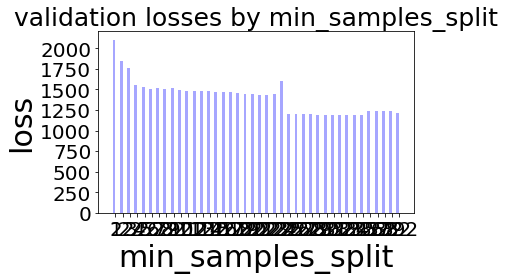

In [13]:
def plot_losses(losses, min_samples_split):
    index = np.arange(len(min_samples_split))
    bar_width = 0.4
    opacity = 0.35

    plt.bar(index, losses, bar_width, alpha=opacity, color='b')
    plt.xlabel('min_samples_split', fontsize=30)
    plt.ylabel('loss', fontsize=30)
    plt.title('validation losses by min_samples_split', fontsize = '25')
    plt.xticks(index + bar_width/2, min_samples_split, fontsize=20 )
    plt.yticks(fontsize=20 )
    plt.rcParams["figure.figsize"] = [24,15]
    plt.tight_layout()

plot_losses(tree_losses_1, min_samples_split)

In [14]:
# Choose the best model and predict refrigerator consumption on the test set
ind = np.argmin(tree_losses_1)
tree_clf_1 = tree_clfs_1[ind]
y_test_predict_1 = tree_clf_1.predict(X_test1)
mse_tree_1 = mse_loss(y_test_predict_1, y_test1)
mae_tree_1 = mae_loss(y_test_predict_1, y_test1)
print('Mean square error on test set: ', mse_tree_1)
print('Mean absolute error on the test set: ', mae_tree_1)

Mean square error on test set:  1634.5797666188705
Mean absolute error on the test set:  12.686127417077758


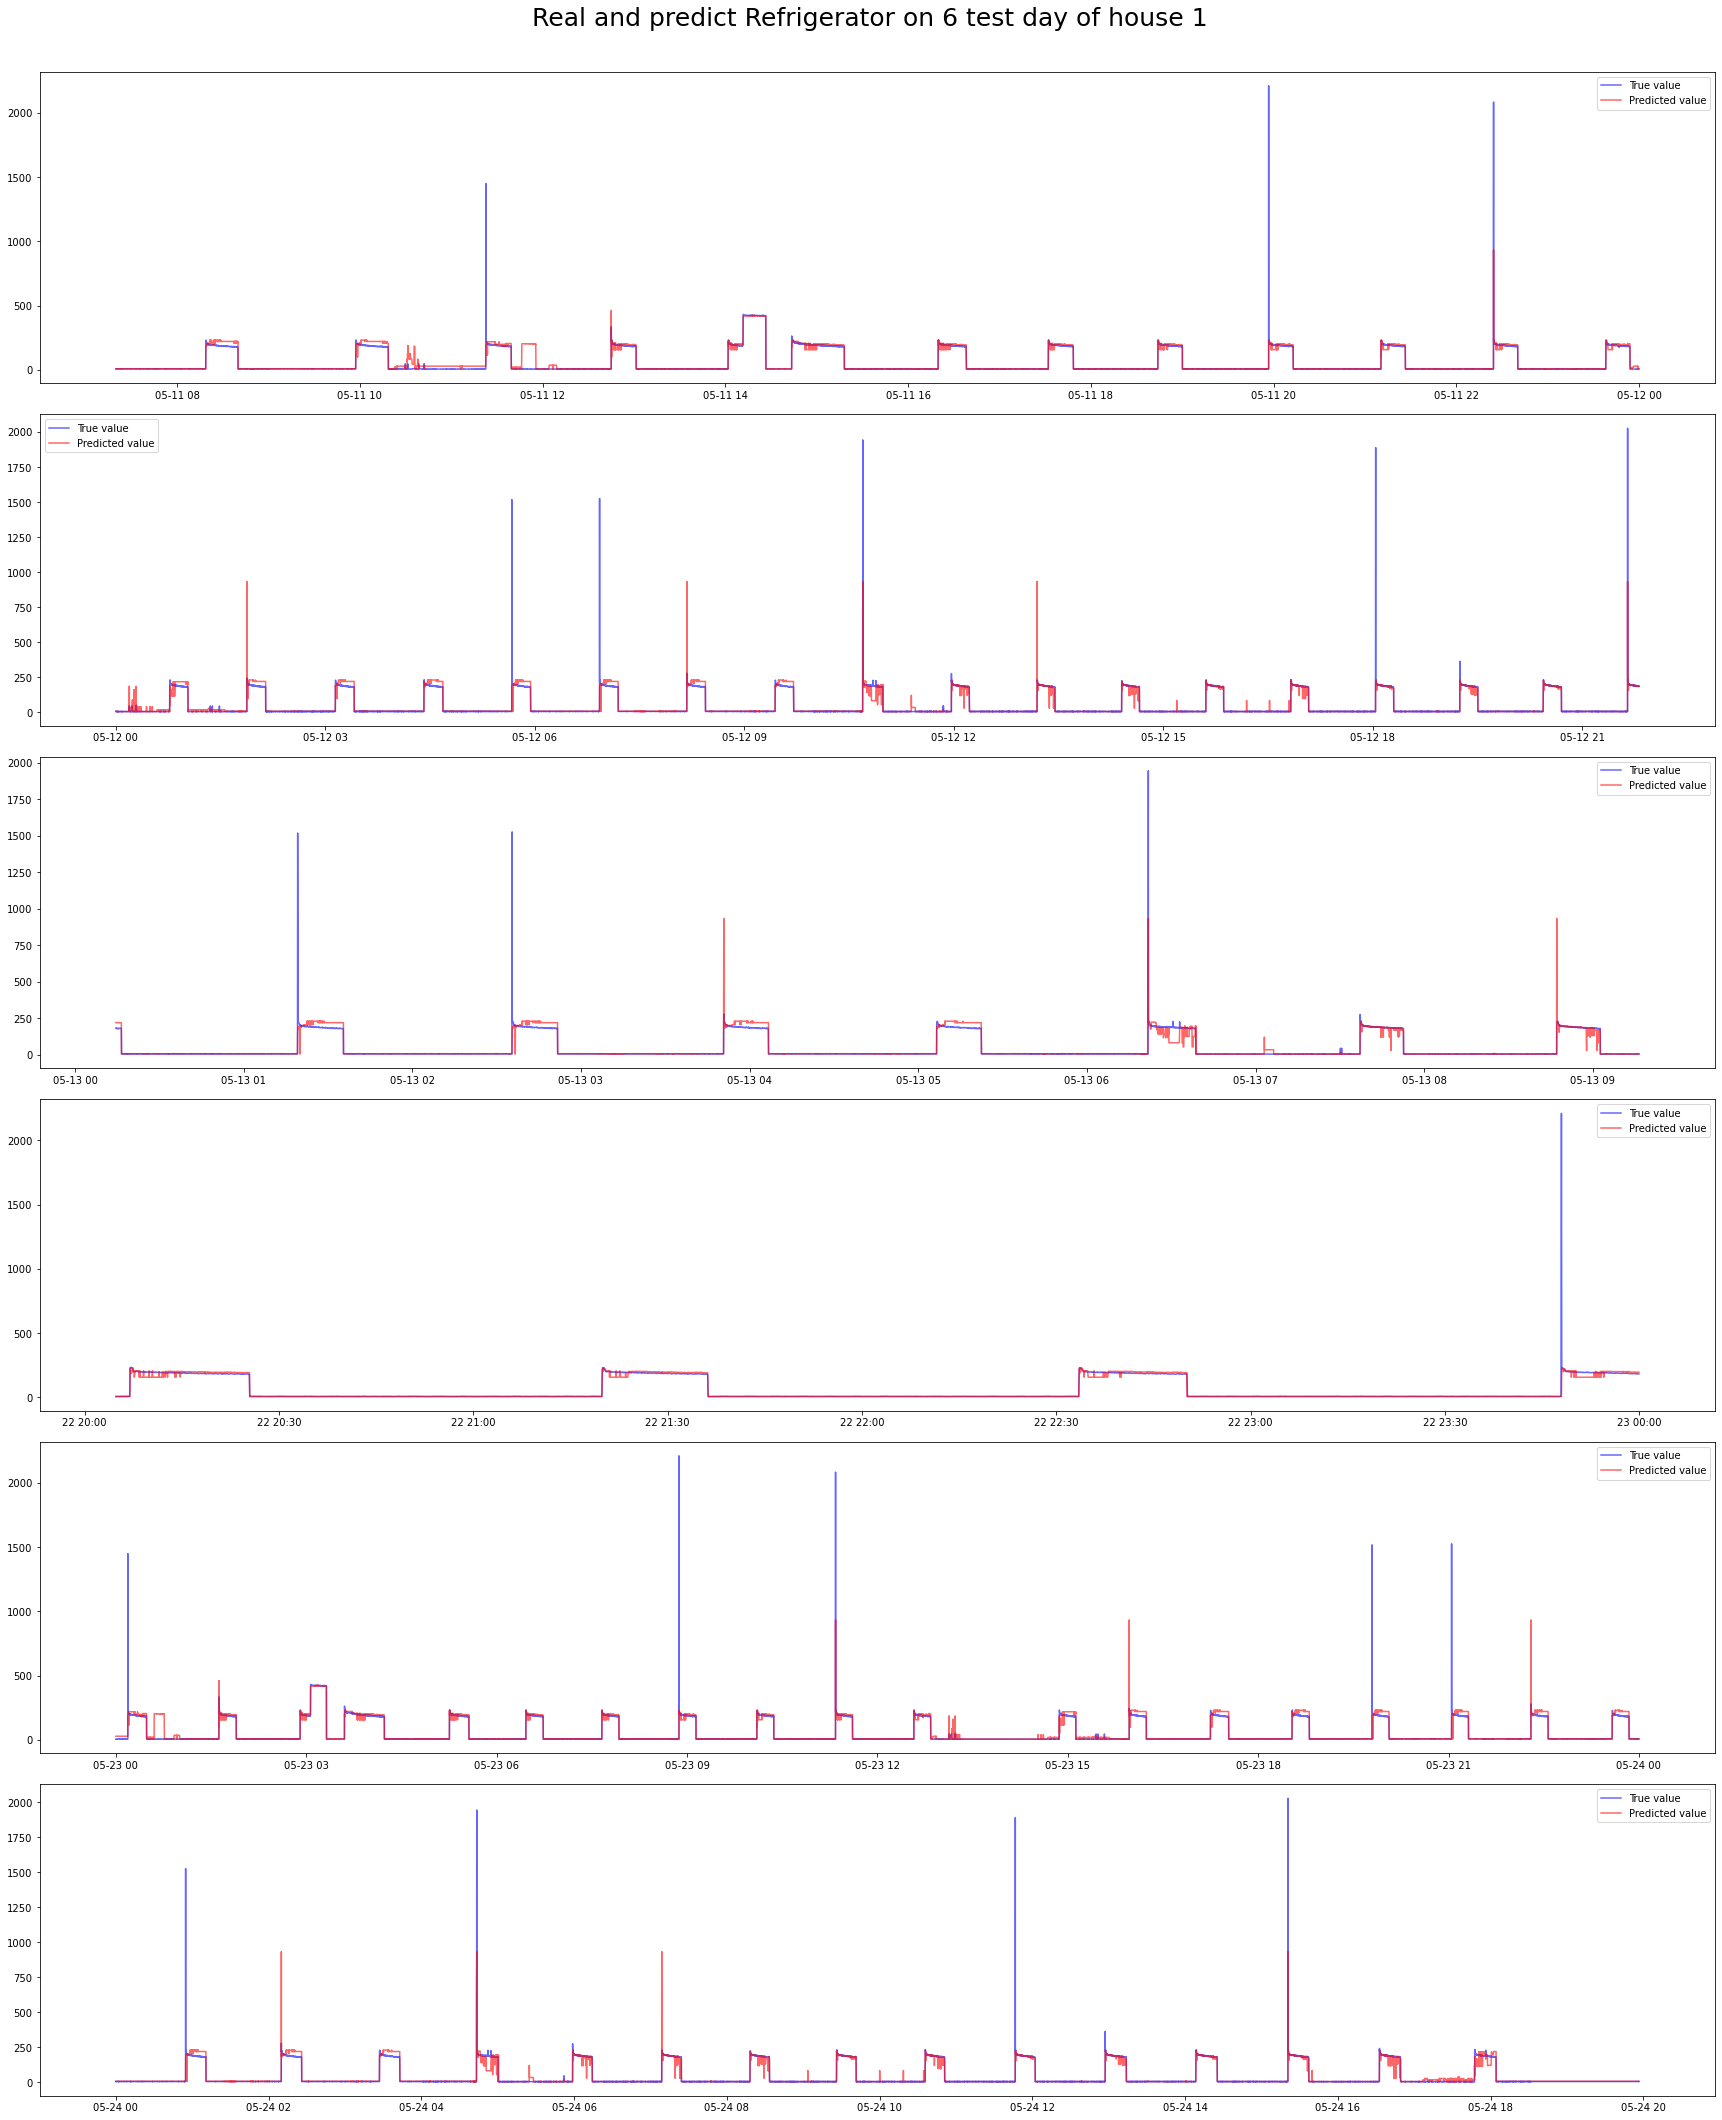

In [15]:
# Plot real and predict refrigerator consumption on six days of test data
def plot_each_app(df, dates, predict, y_test, title, look_back = 0):
    num_date = len(dates)
    fig, axes = plt.subplots(num_date,1,figsize=(24, num_date*5) )
    plt.suptitle(title, fontsize = '25')
    fig.tight_layout()
    fig.subplots_adjust(top=0.95)
    for i in range(num_date):
        if i == 0: l = 0
        ind = df.loc[dates[i]].index[look_back:]
        axes.flat[i].plot(ind, y_test[l:l+len(ind)], color = 'blue', alpha = 0.6, label = 'True value')
        axes.flat[i].plot(ind, predict[l:l+len(ind)], color = 'red', alpha = 0.6, label = 'Predicted value')
        axes.flat[i].legend()
        l = len(ind)


plot_each_app(df1_test, dates[1][17:], y_test_predict_1, y_test1, 'Real and predict Refrigerator on 6 test day of house 1')

#### Using decision tree model we have just trained on house 1 to predict refrigerator consumtion on house 2

In [16]:
X_2 = df[2][['mains_2','mains_1']].values
y_2 = df[2]['refrigerator_9'].values
print(X_2.shape, y_2.shape)

(316840, 2) (316840,)


In [17]:
y_predict_2 = tree_clf_1.predict(X_2)
mse_tree_2 = mse_loss(y_predict_2, y_2)
mae_tree_2 = mae_loss(y_predict_2, y_2)
print('Mean square error on test set: ', mse_tree_2)
print('Mean absolute error on the test set: ', mae_tree_2)

Mean square error on test set:  32245.25362228206
Mean absolute error on the test set:  64.75419454670589


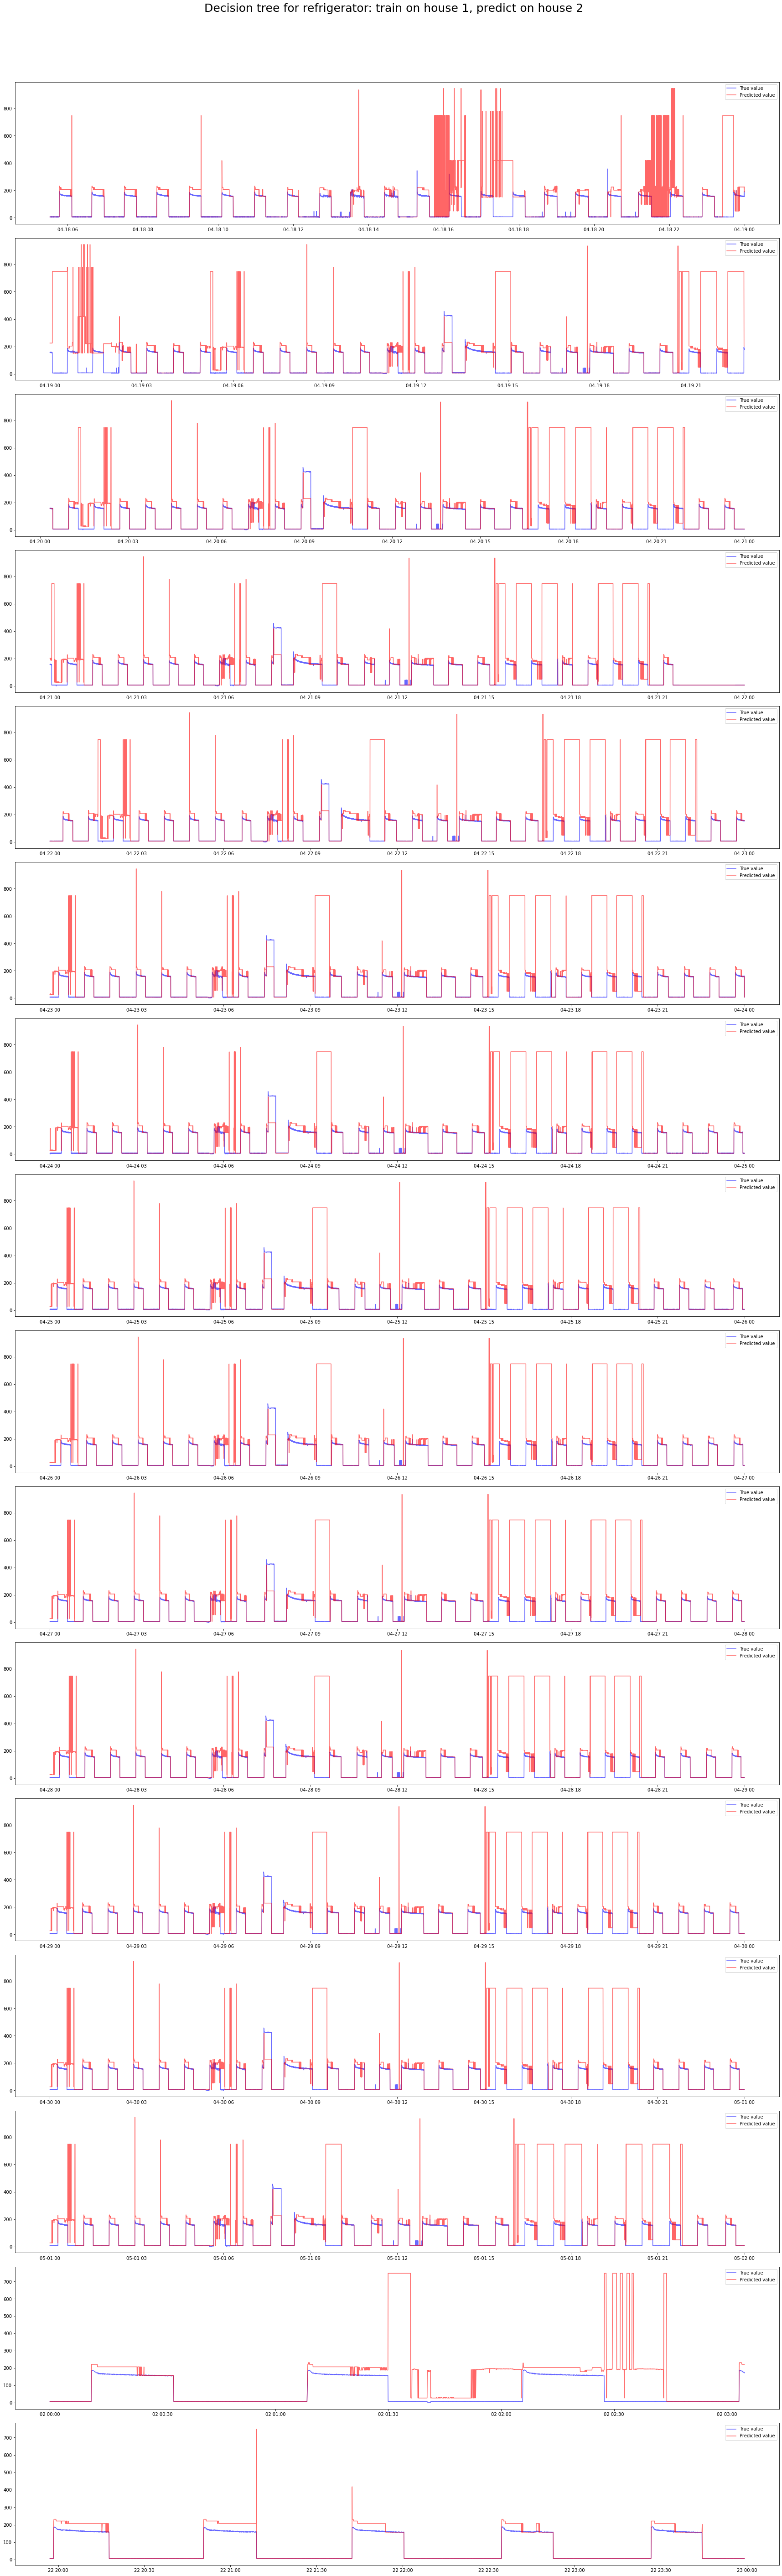

In [18]:
plot_each_app(df[2], dates[2], y_predict_2, y_2, 'Decision tree for refrigerator: train on house 1, predict on house 2')

#### Now, we will try decision tree method for other appliances in house 1

In [19]:
# List of other appliances in house 1:
appliances = list(df[1].columns.values[2:])
appliances.pop(2)
print(appliances)

['oven_3', 'oven_4', 'dishwaser_6', 'kitchen_outlets_7', 'kitchen_outlets_8', 'lighting_9', 'washer_dryer_10', 'microwave_11', 'bathroom_gfi_12', 'electric_heat_13', 'stove_14', 'kitchen_outlets_15', 'kitchen_outlets_16', 'lighting_17', 'lighting_18', 'washer_dryer_19', 'washer_dryer_20']


In [20]:
# using decision tree model on other appliances
def tree_reg_mult_apps():
    start = time.time()
    min_samples_split=np.arange(2, 400, 10)
    pred = {}
    for app in appliances:
        list_clfs = []
        losses = []
        y_train = df1_train[app].values
        y_val = df1_val[app].values
        for split in min_samples_split:
            clf = DecisionTreeRegressor(min_samples_split = split)
            clf.fit(X_train1, y_train)
            y_predict_val = clf.predict(X_val1)
            list_clfs.append(clf)
            losses.append( mse_loss(y_predict_val, y_val) )
        ind = np.argmin(losses)
        pred[app] = list_clfs[ind].predict(X_test1)
    print('Trainning time: ', time.time() - start)
    return pred

mul_pred = tree_reg_mult_apps()

Trainning time:  317.7583031654358


In [21]:
def error_mul_app(mul_pred):
    mse_losses = {}
    mae_losses = {}
    for app in appliances:
        mse_losses[app] = mse_loss(mul_pred[app], df1_test[app].values)
        mae_losses[app] = mae_loss(mul_pred[app], df1_test[app].values)
    return mse_losses, mae_losses

mul_mse_tree, mul_mae_tree = error_mul_app(mul_pred) 

In [22]:
for app in appliances:
    m = np.mean(df1_test[app].values)
    print('mean of {0}: {1:.2f} - mse: {2:.2f} - mae: {3:.2f}'.format(app, m ,mul_mse_tree[app], mul_mae_tree[app]))

mean of oven_3: 15.63 - mse: 18555.15 - mae: 11.29
mean of oven_4: 17.11 - mse: 7454.75 - mae: 4.92
mean of dishwaser_6: 25.35 - mse: 831.49 - mae: 3.38
mean of kitchen_outlets_7: 21.25 - mse: 4.50 - mae: 1.59
mean of kitchen_outlets_8: 27.71 - mse: 99.51 - mae: 3.43
mean of lighting_9: 28.29 - mse: 1603.56 - mae: 24.05
mean of washer_dryer_10: 3.07 - mse: 934.44 - mae: 2.44
mean of microwave_11: 18.92 - mse: 12442.92 - mae: 13.00
mean of bathroom_gfi_12: 6.73 - mse: 3471.07 - mae: 3.44
mean of electric_heat_13: 0.11 - mse: 0.53 - mae: 0.05
mean of stove_14: 0.10 - mse: 0.23 - mae: 0.04
mean of kitchen_outlets_15: 5.34 - mse: 832.75 - mae: 1.63
mean of kitchen_outlets_16: 1.93 - mse: 718.63 - mae: 0.65
mean of lighting_17: 18.97 - mse: 136.66 - mae: 3.18
mean of lighting_18: 15.68 - mse: 383.82 - mae: 13.12
mean of washer_dryer_19: 0.00 - mse: 0.00 - mae: 0.00
mean of washer_dryer_20: 27.54 - mse: 2087.58 - mae: 1.79


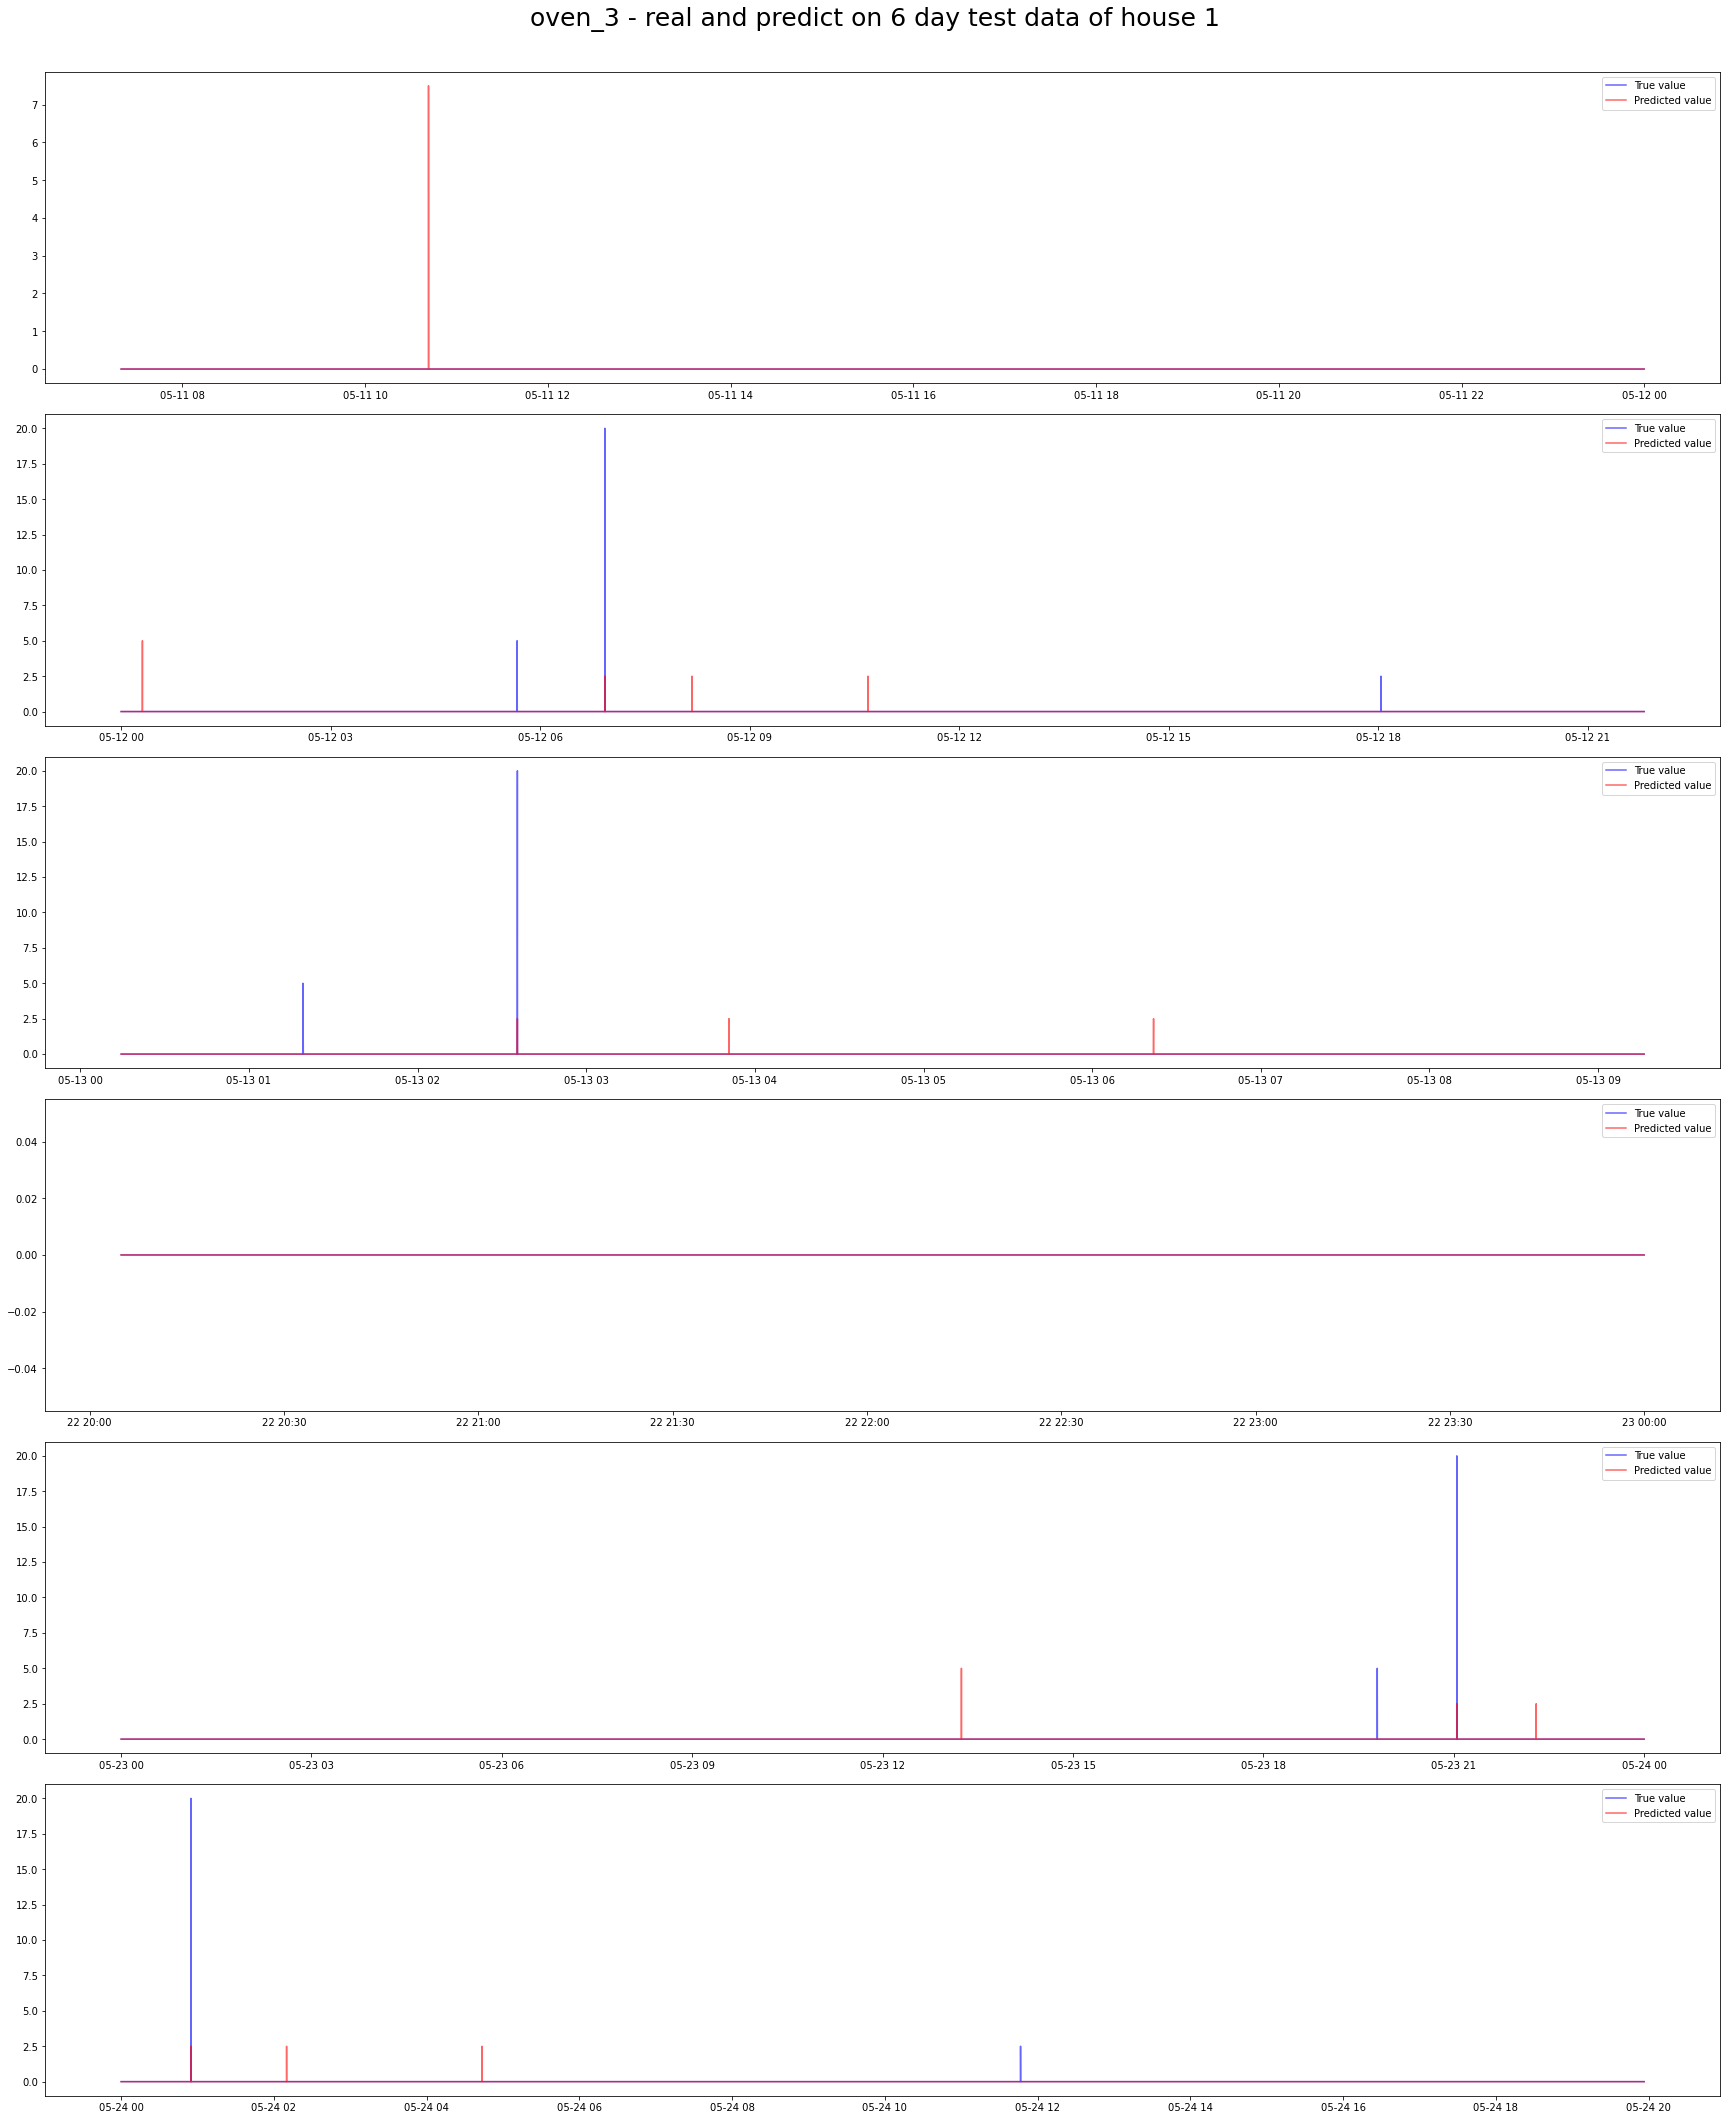

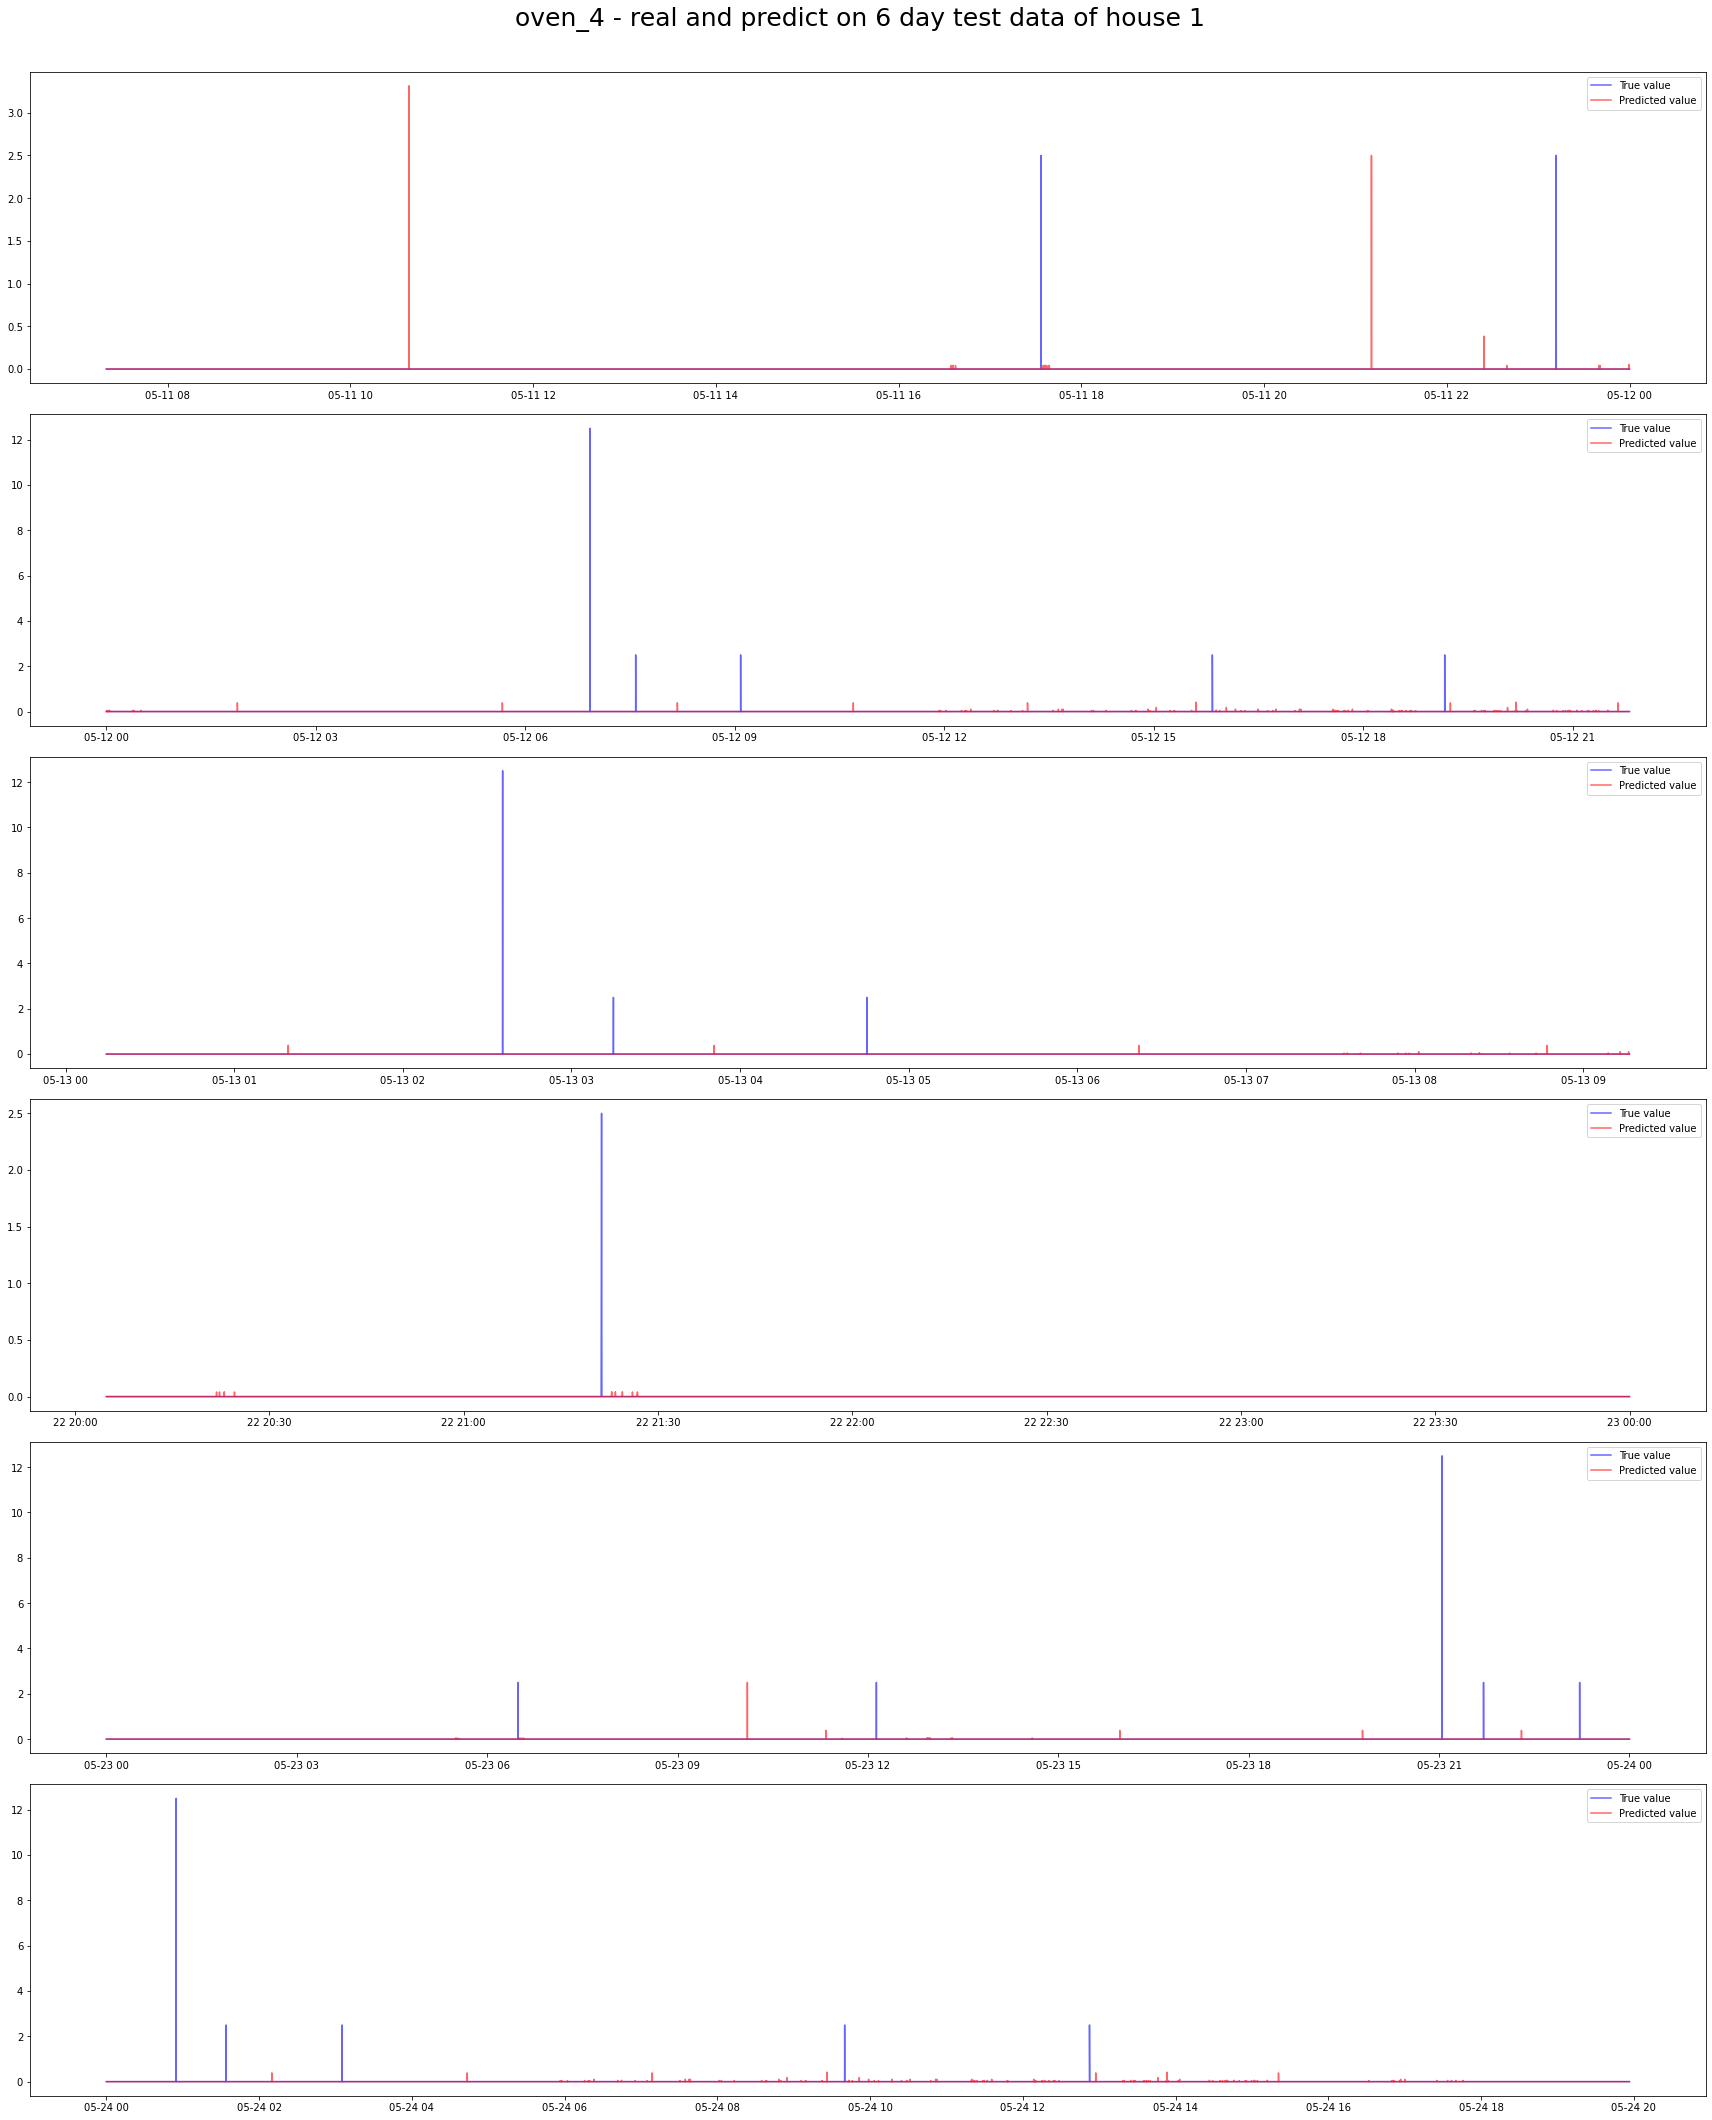

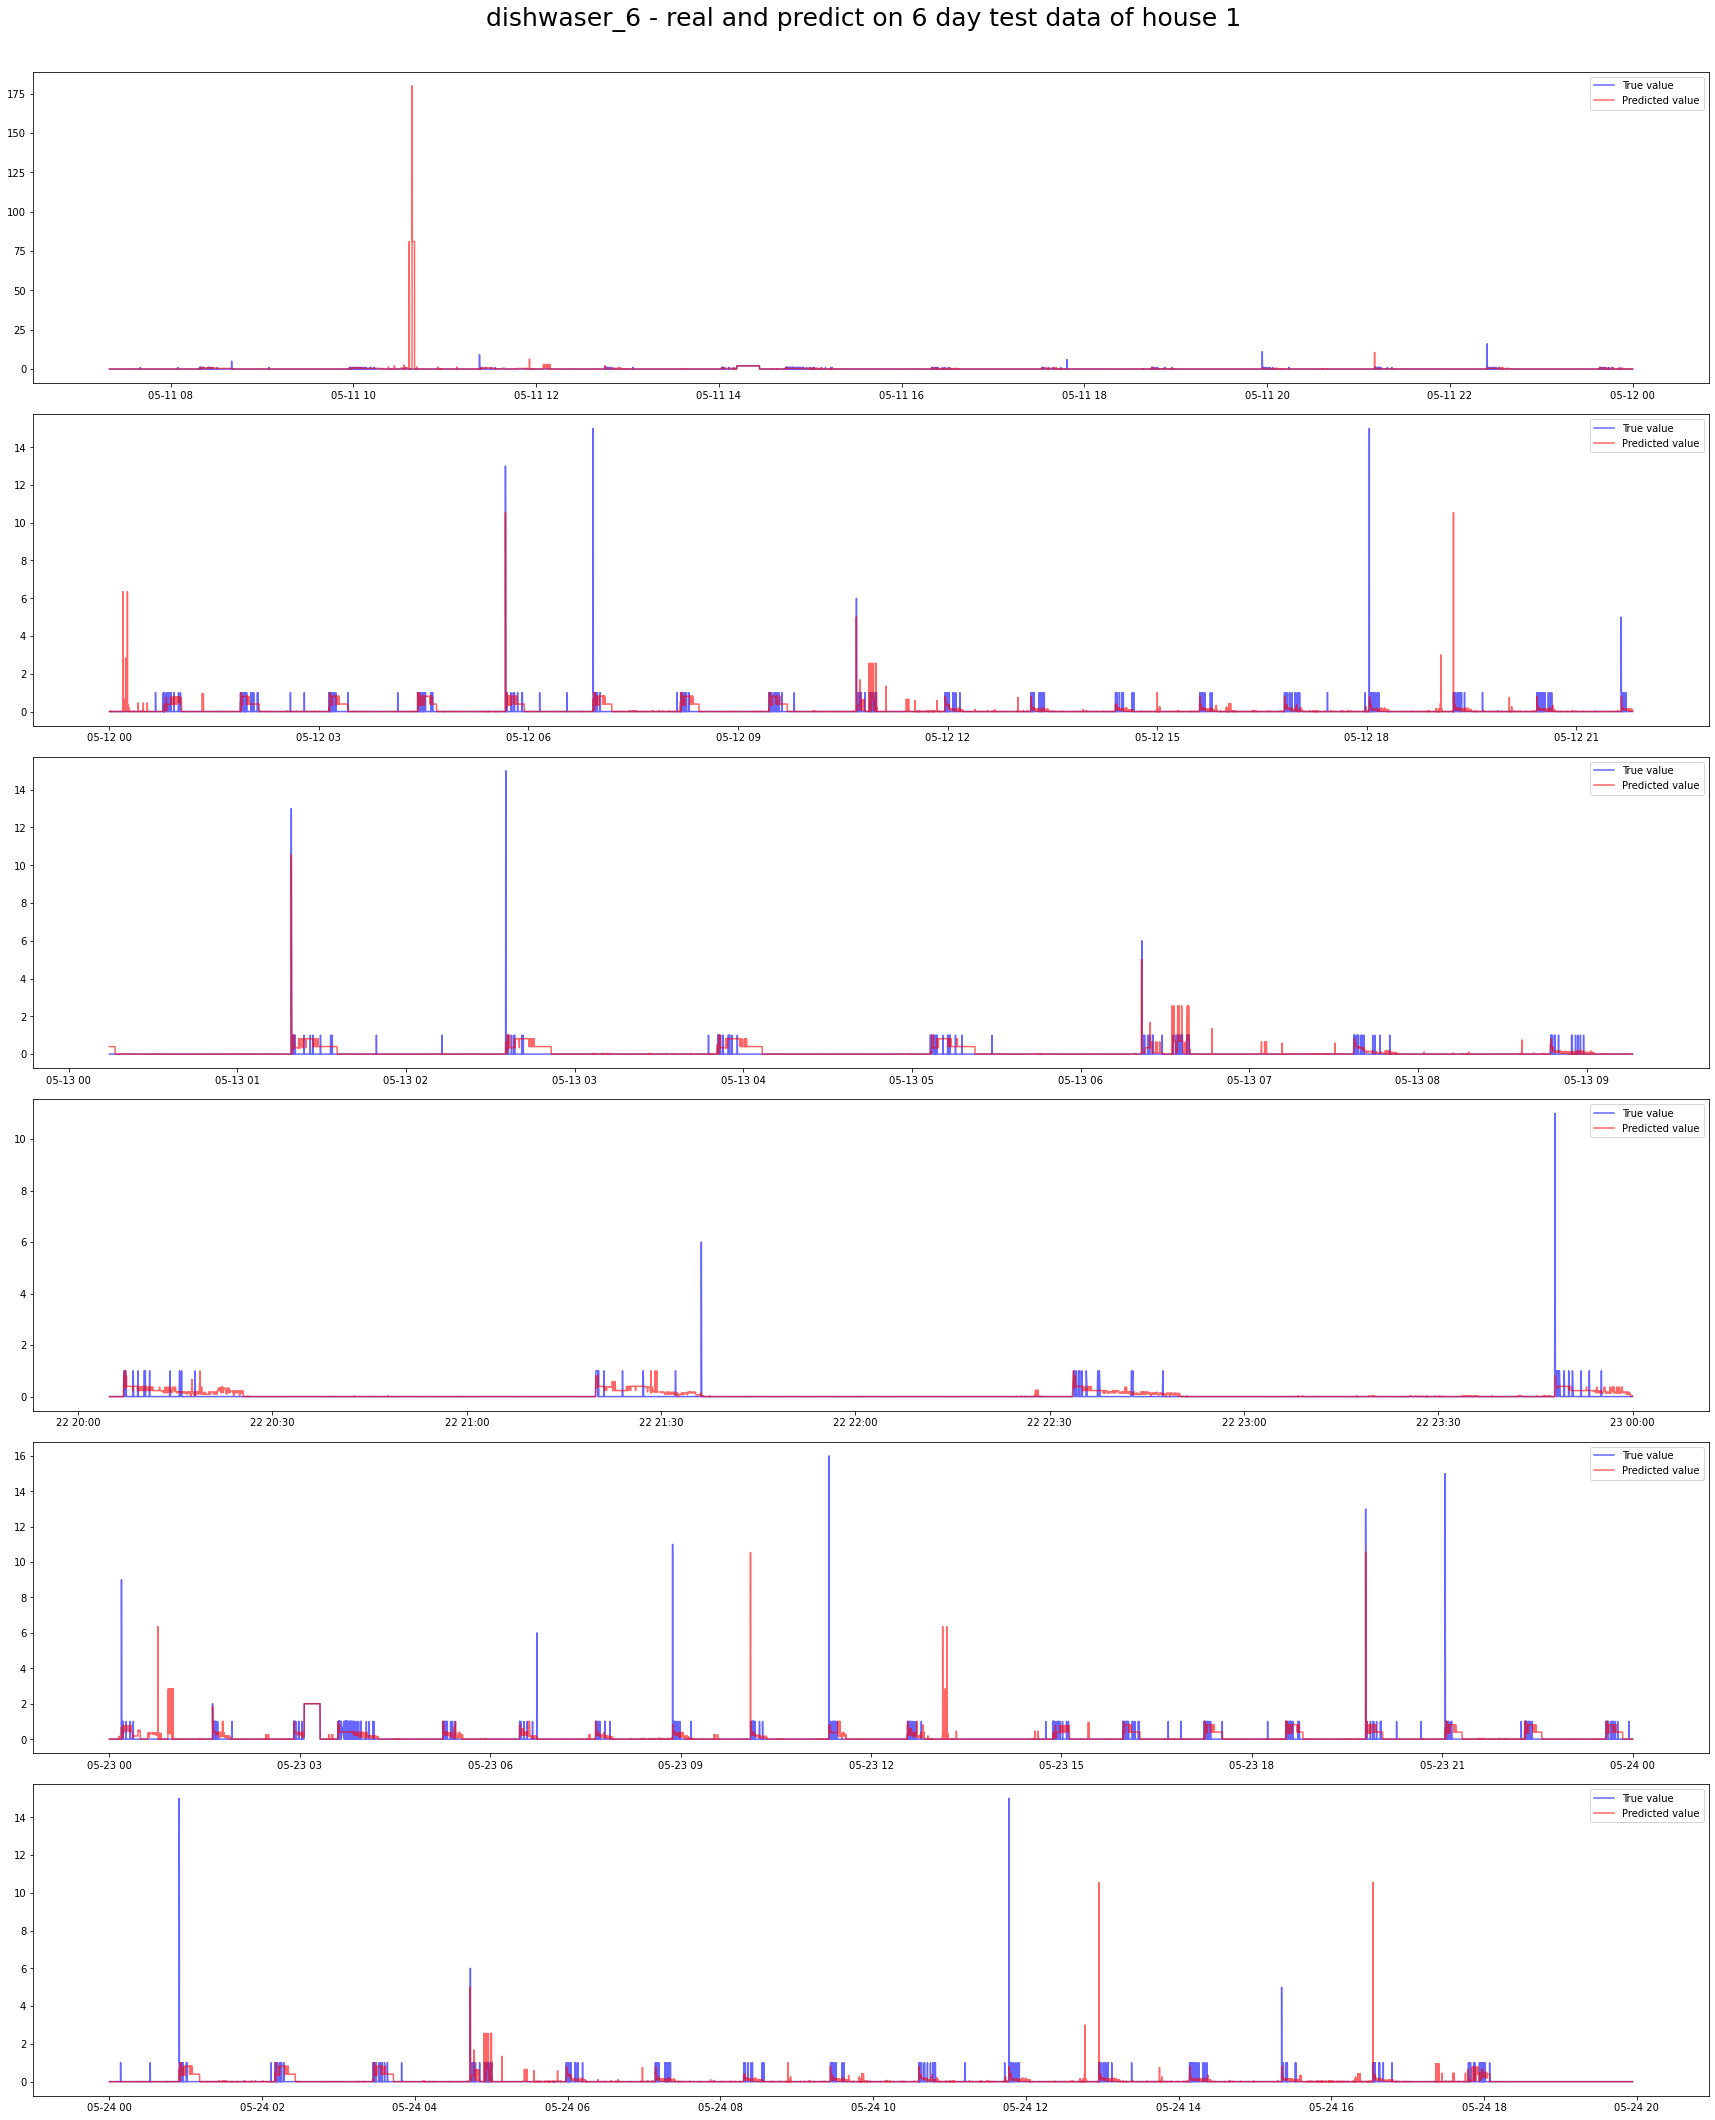

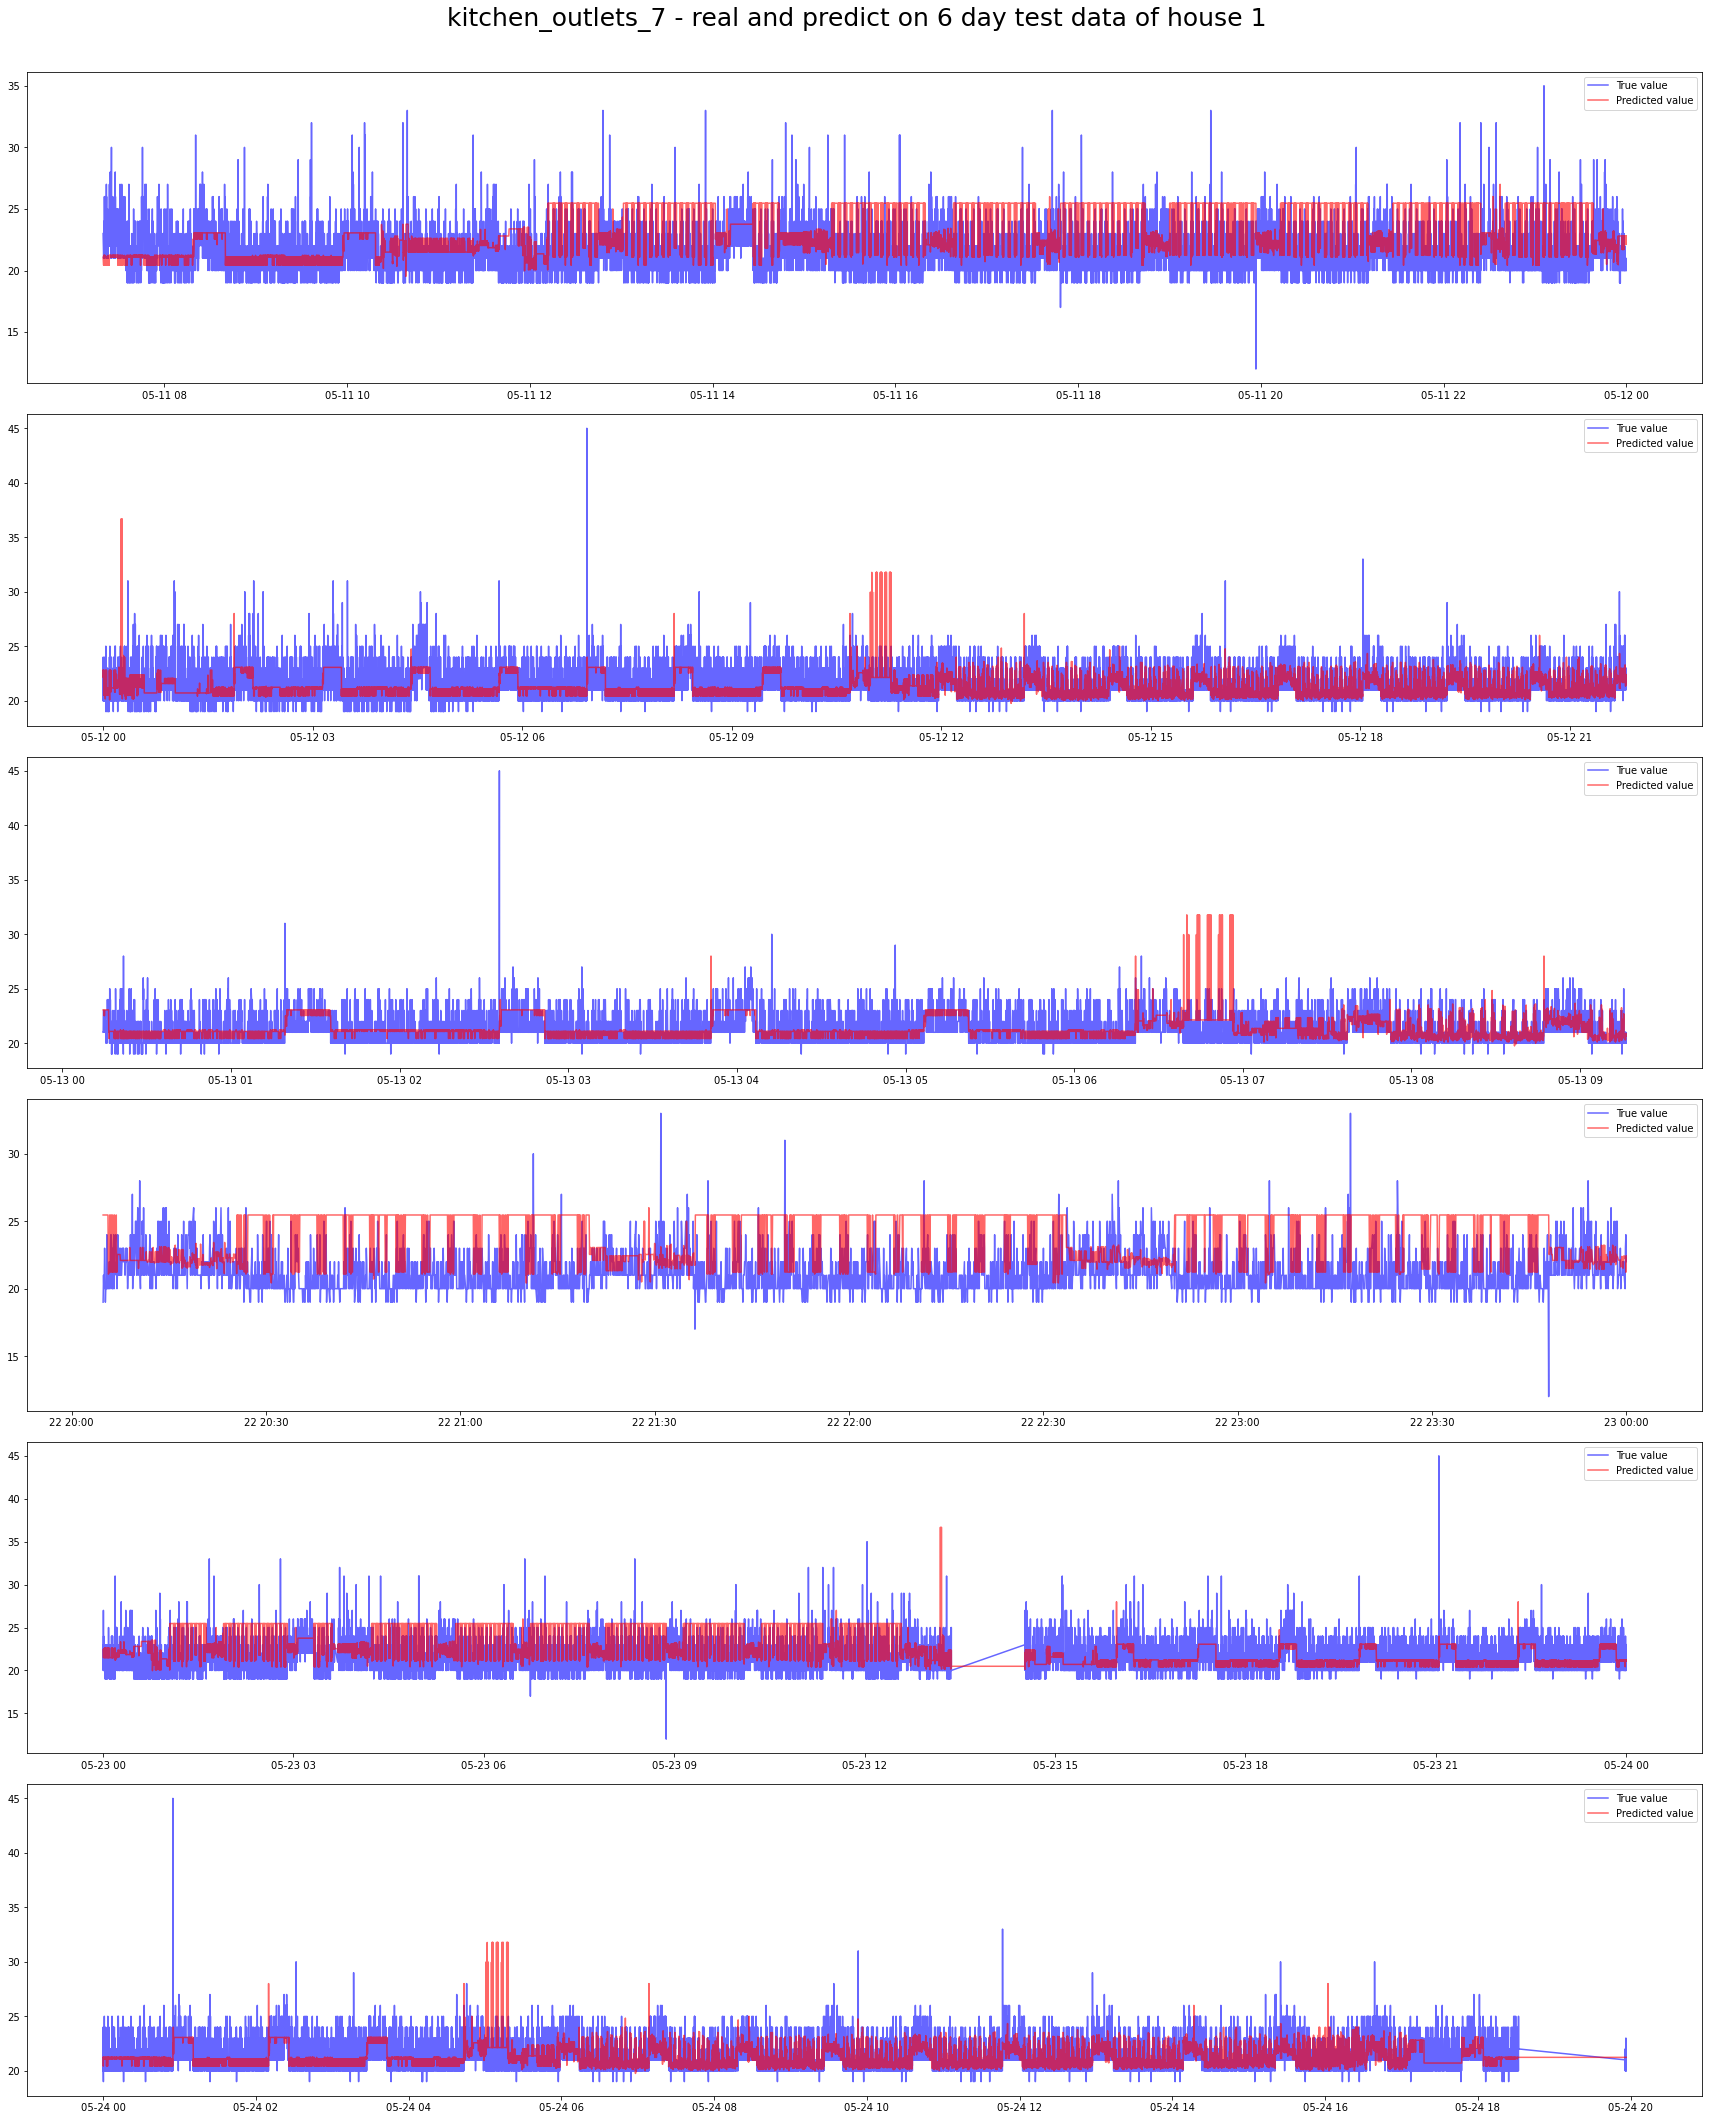

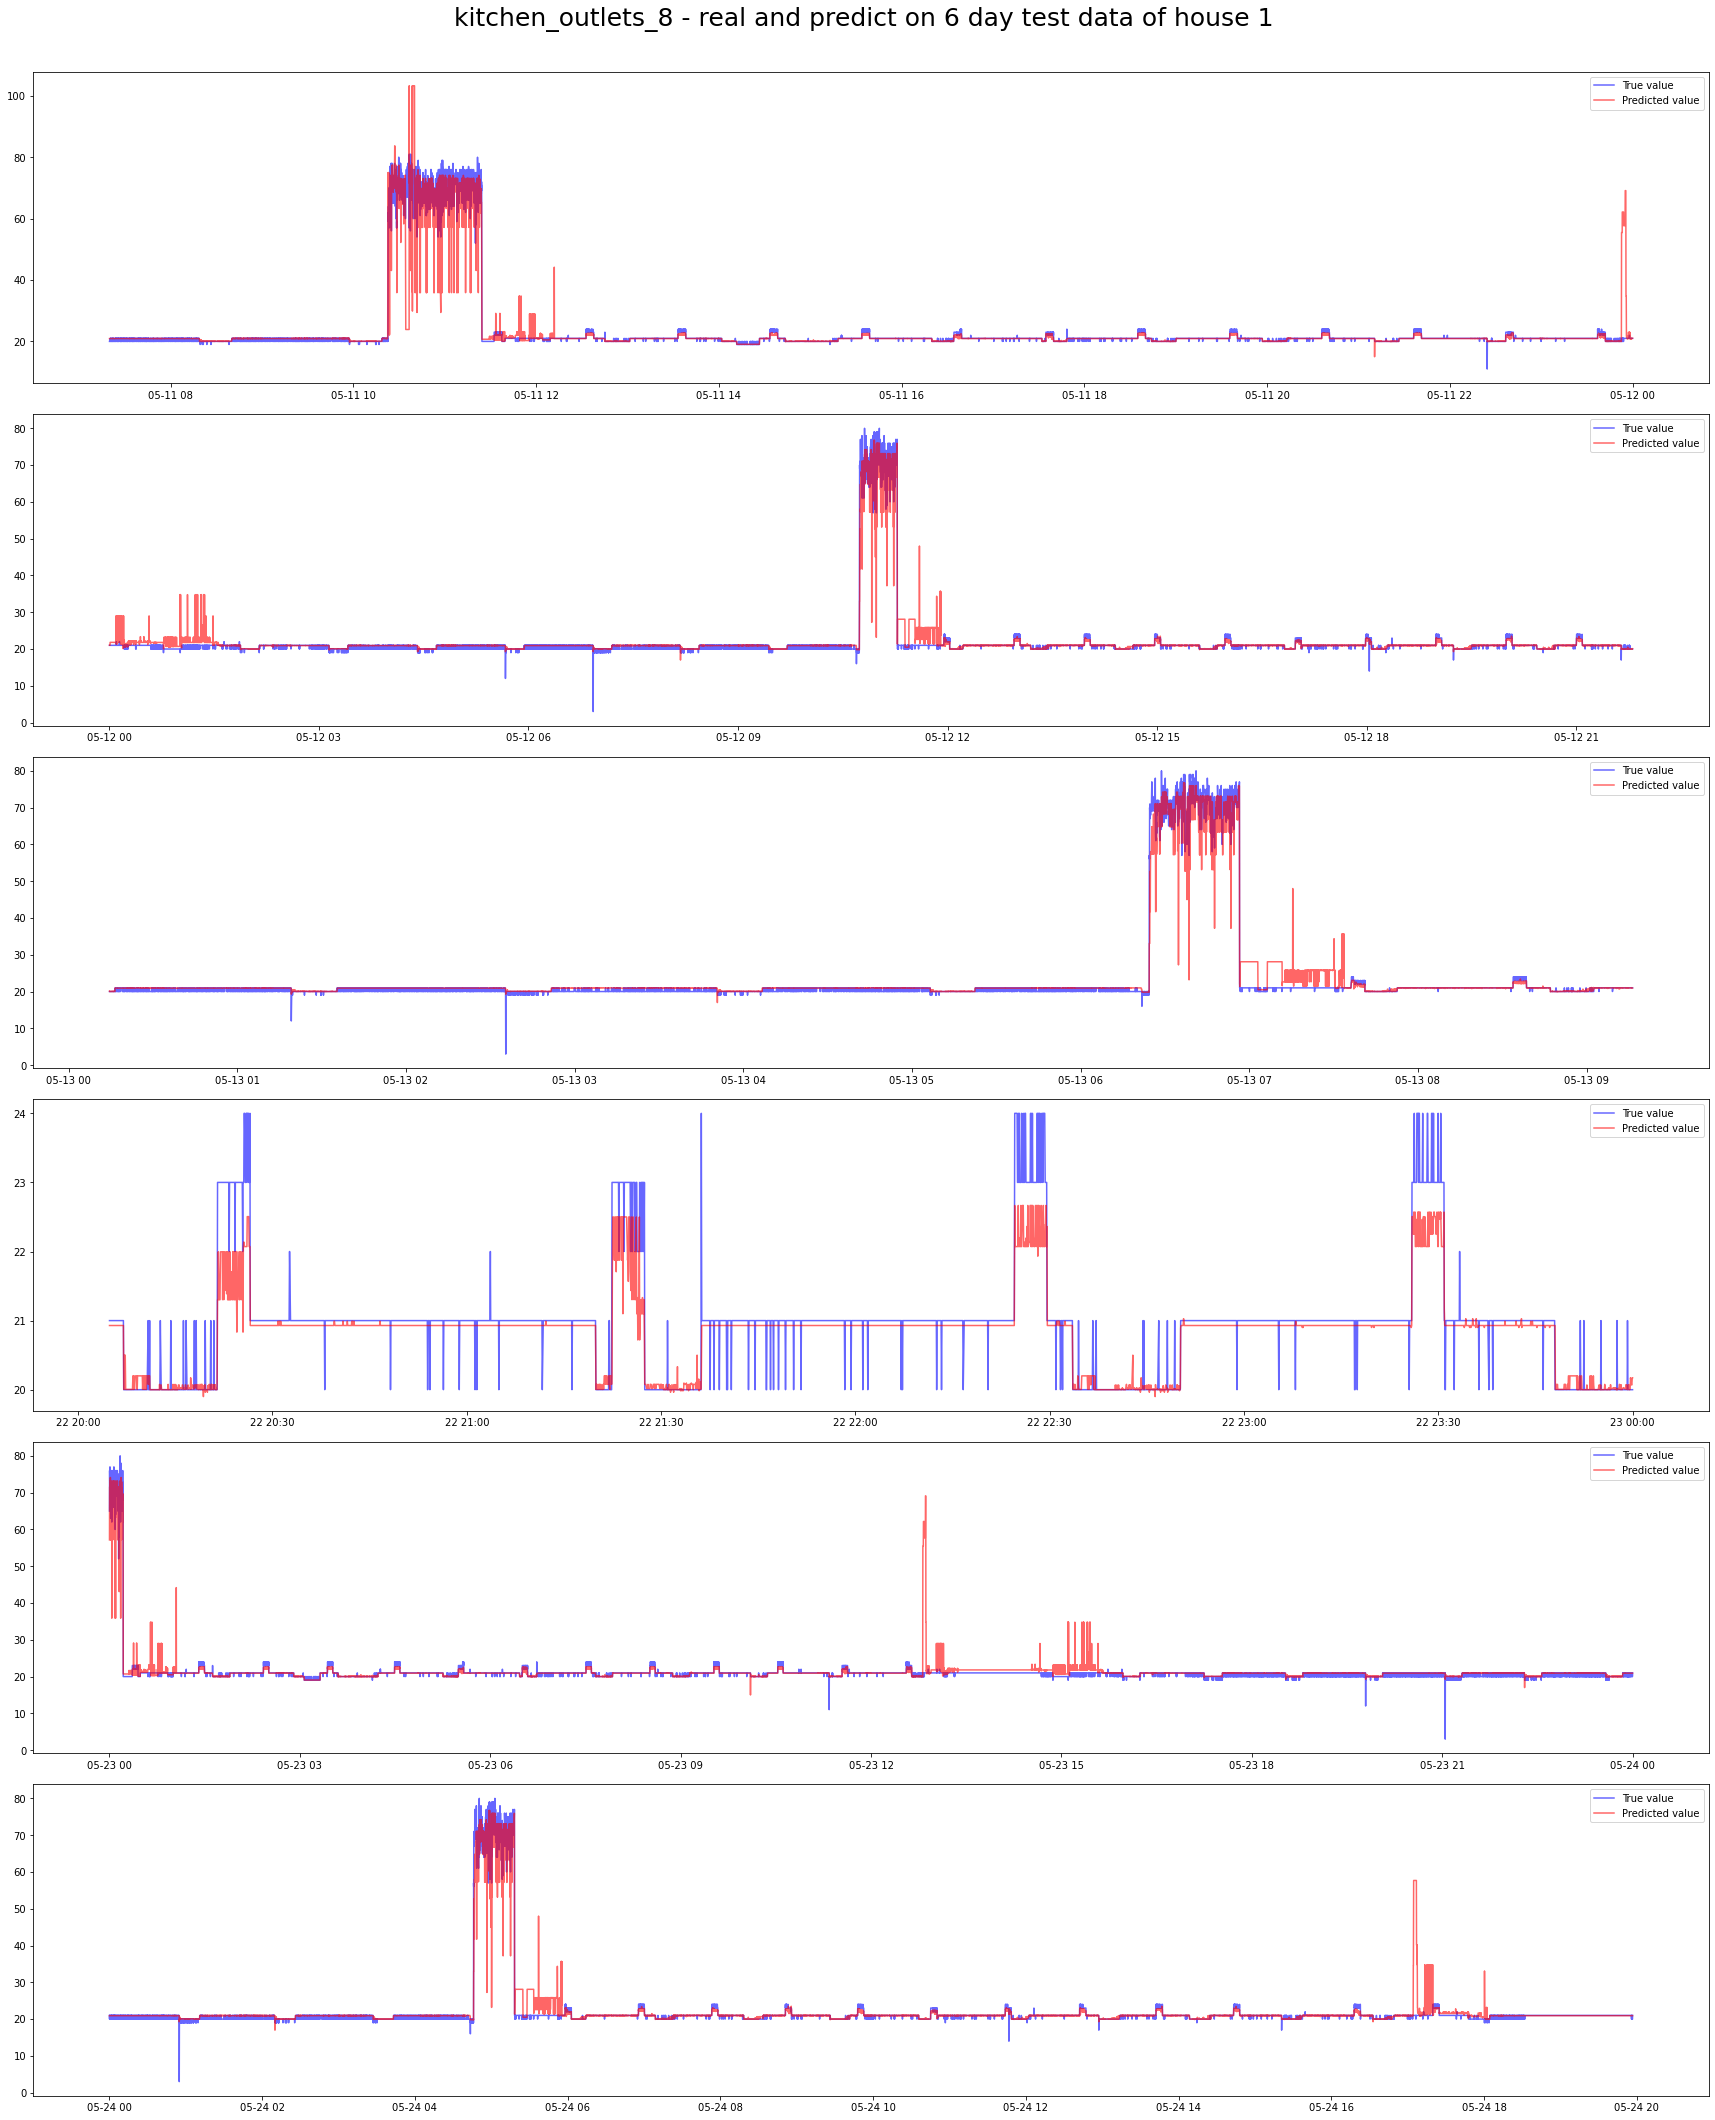

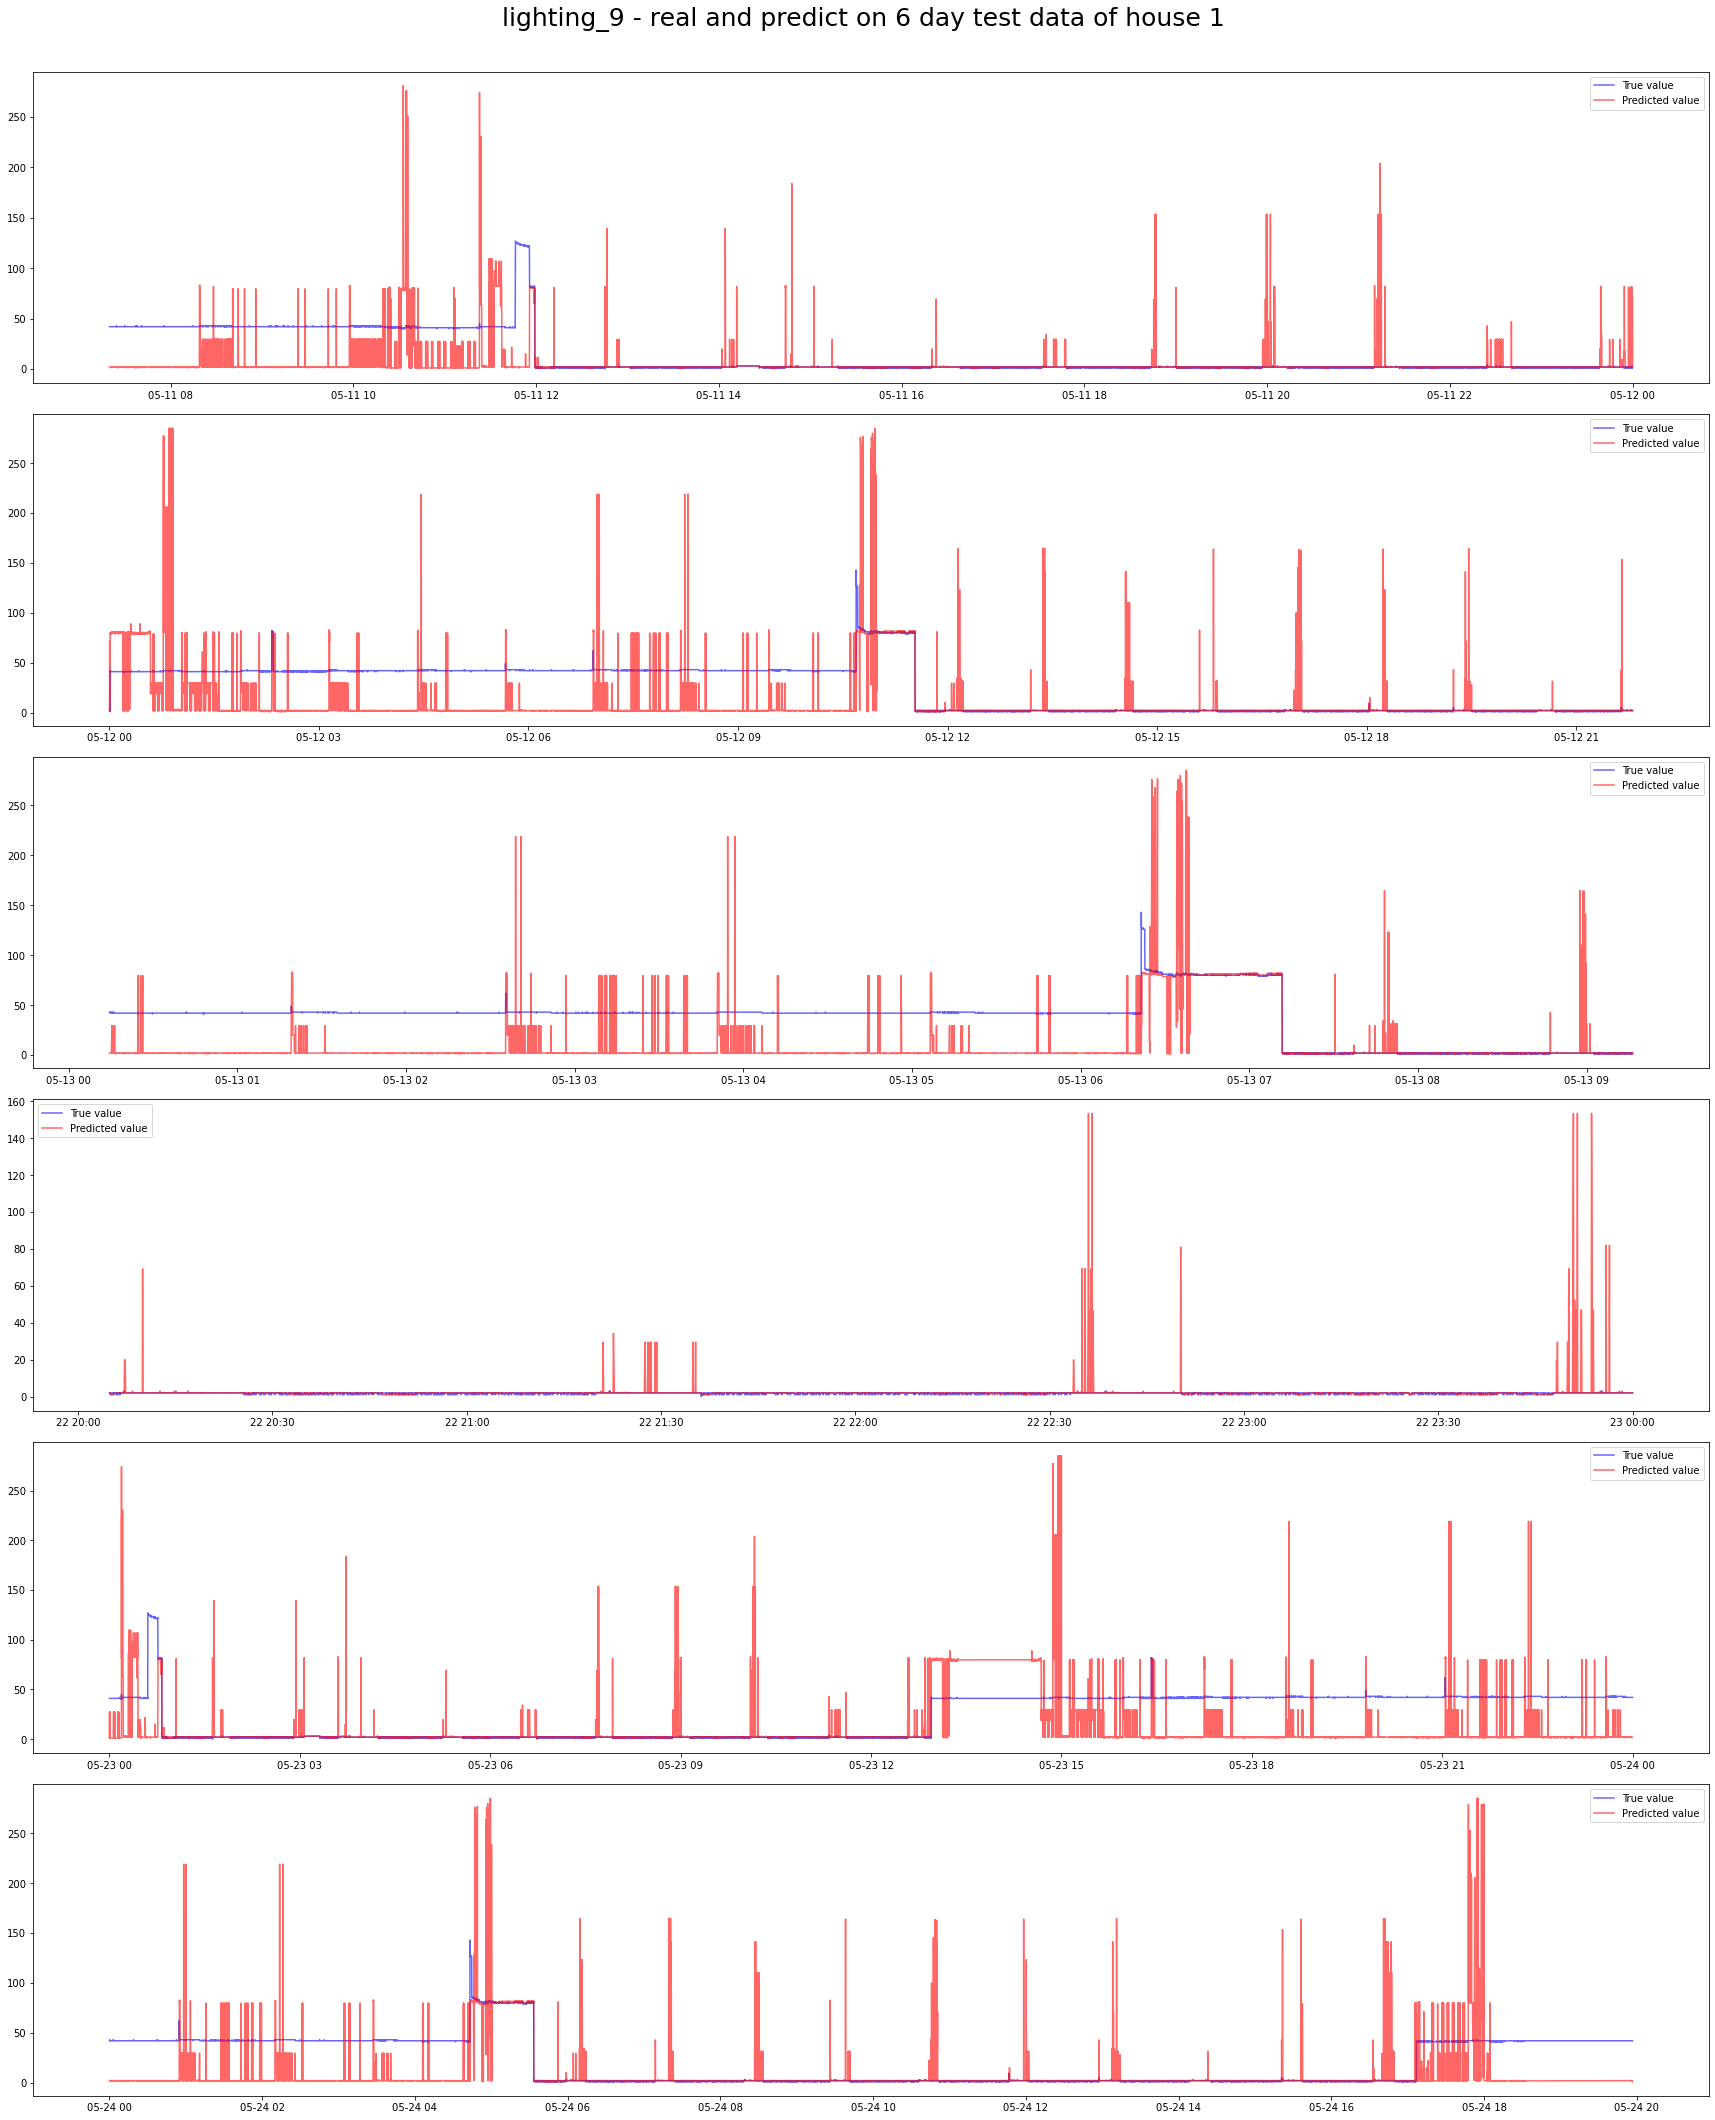

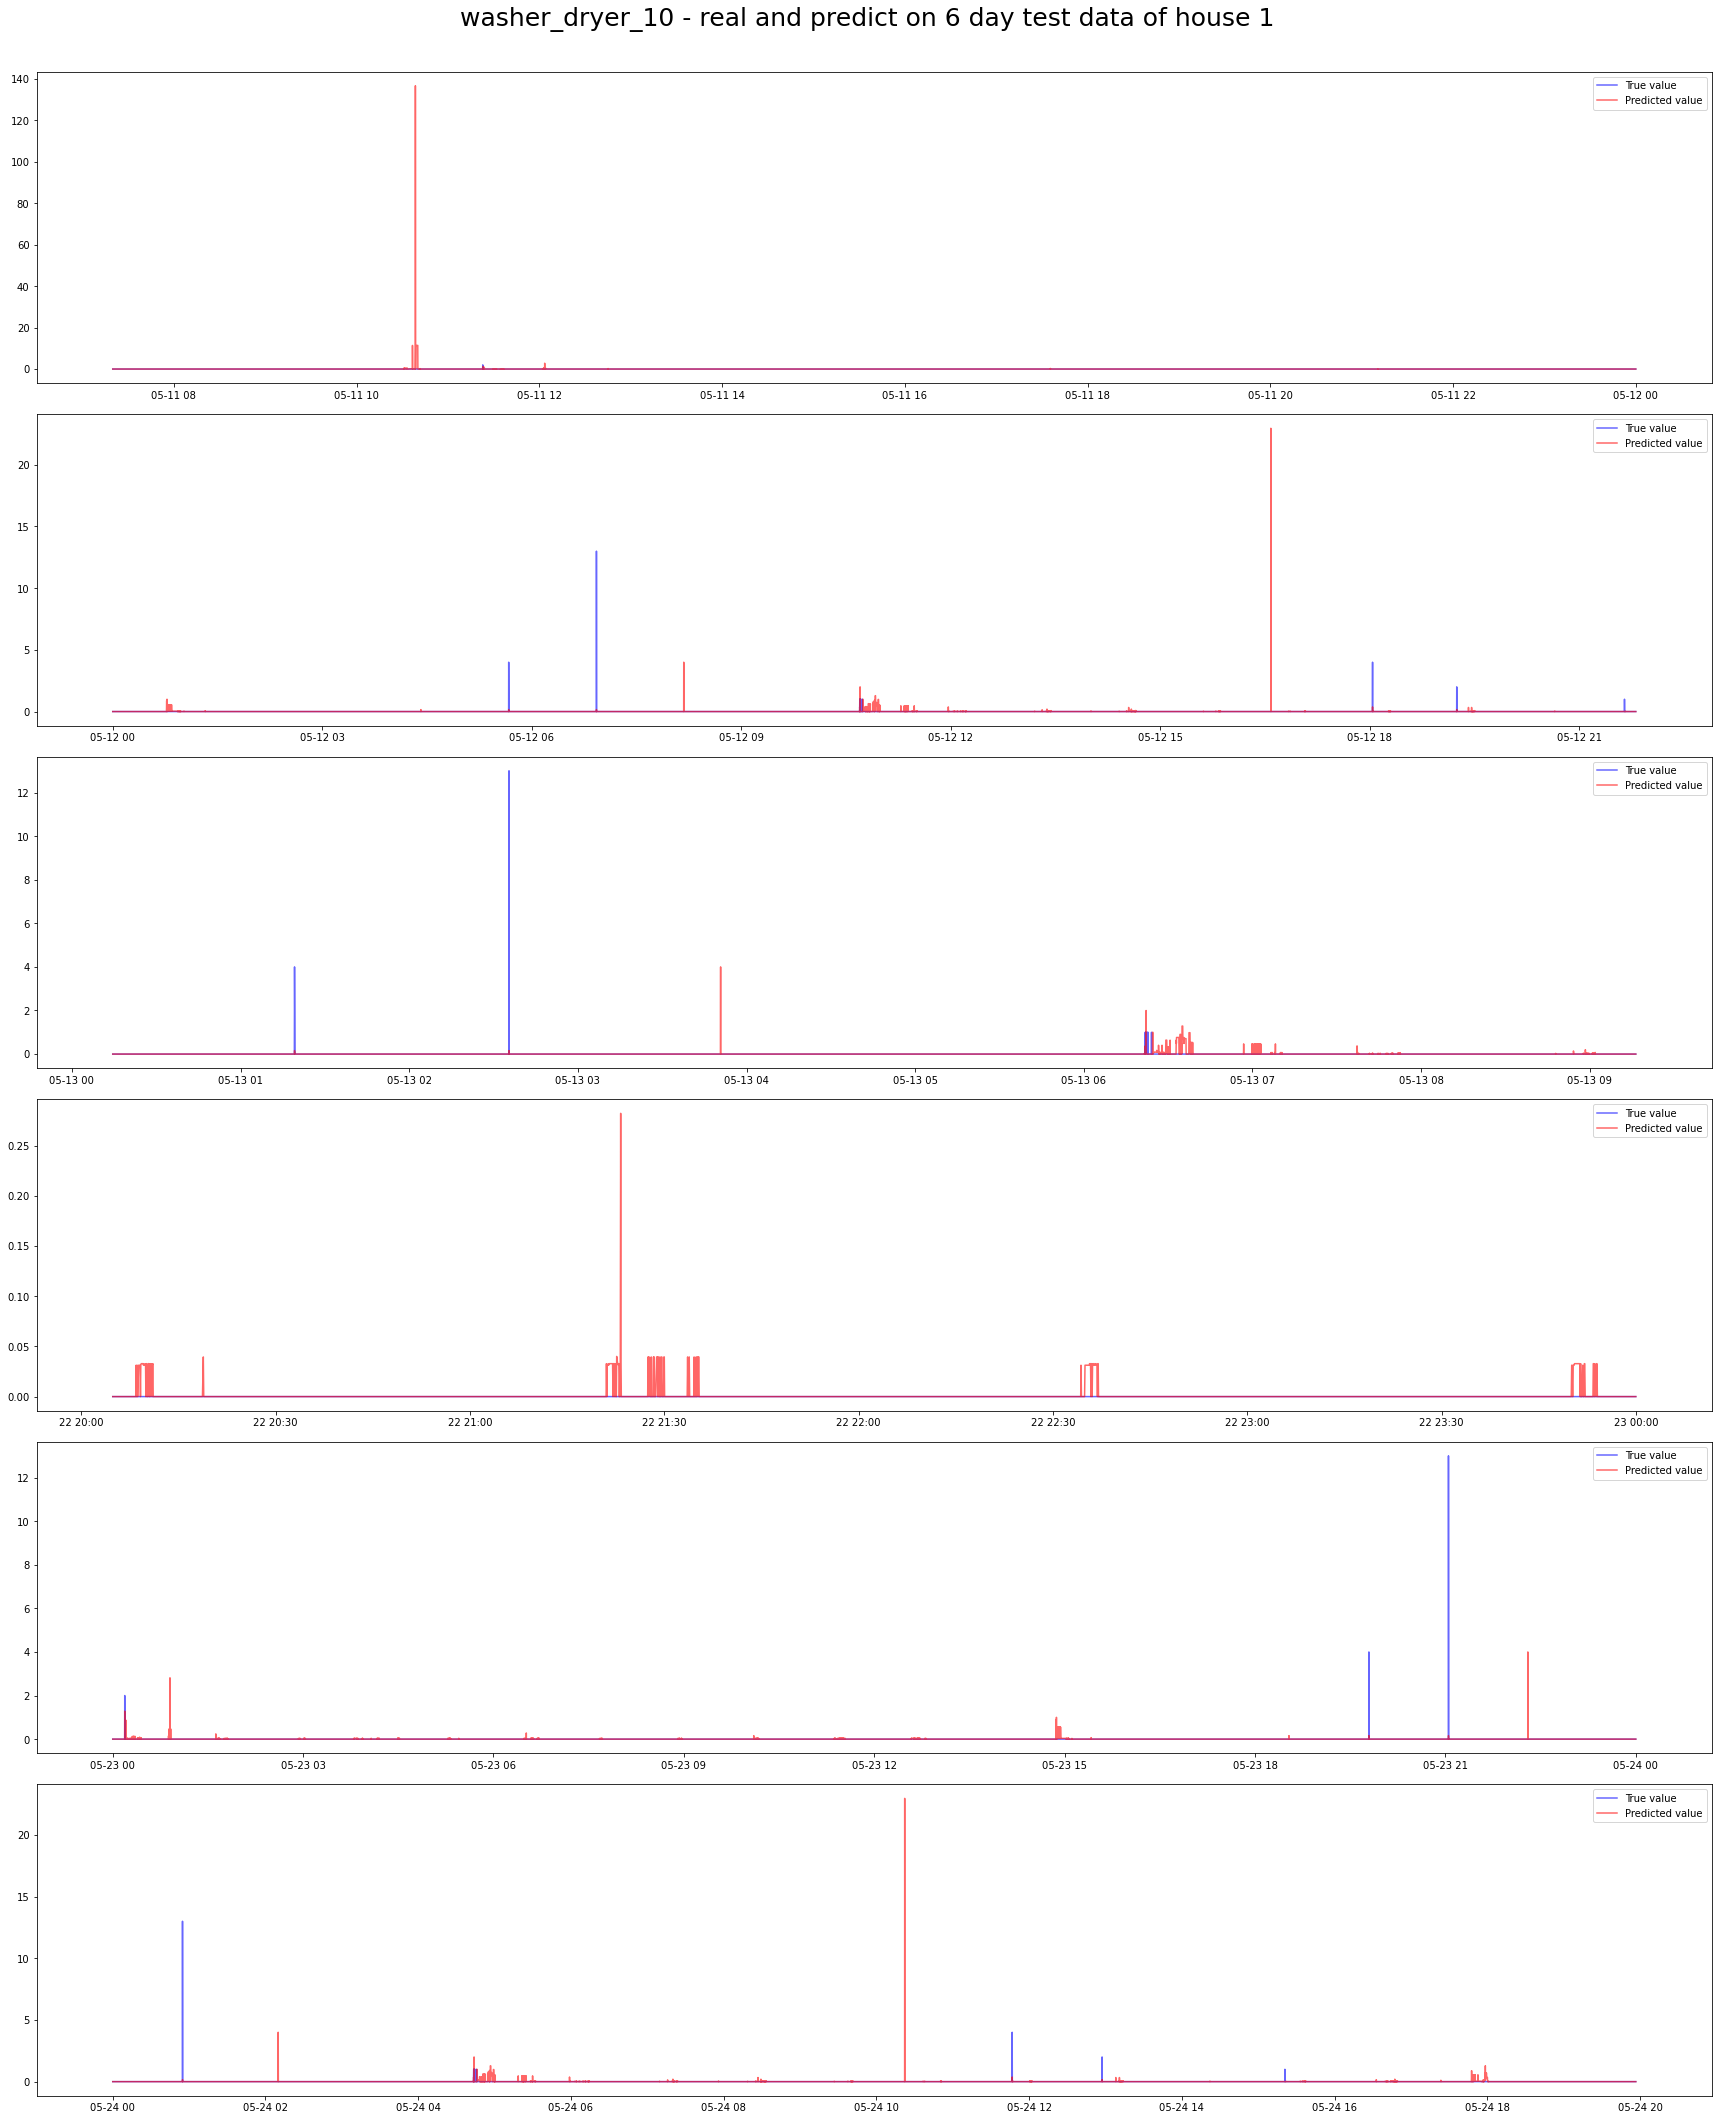

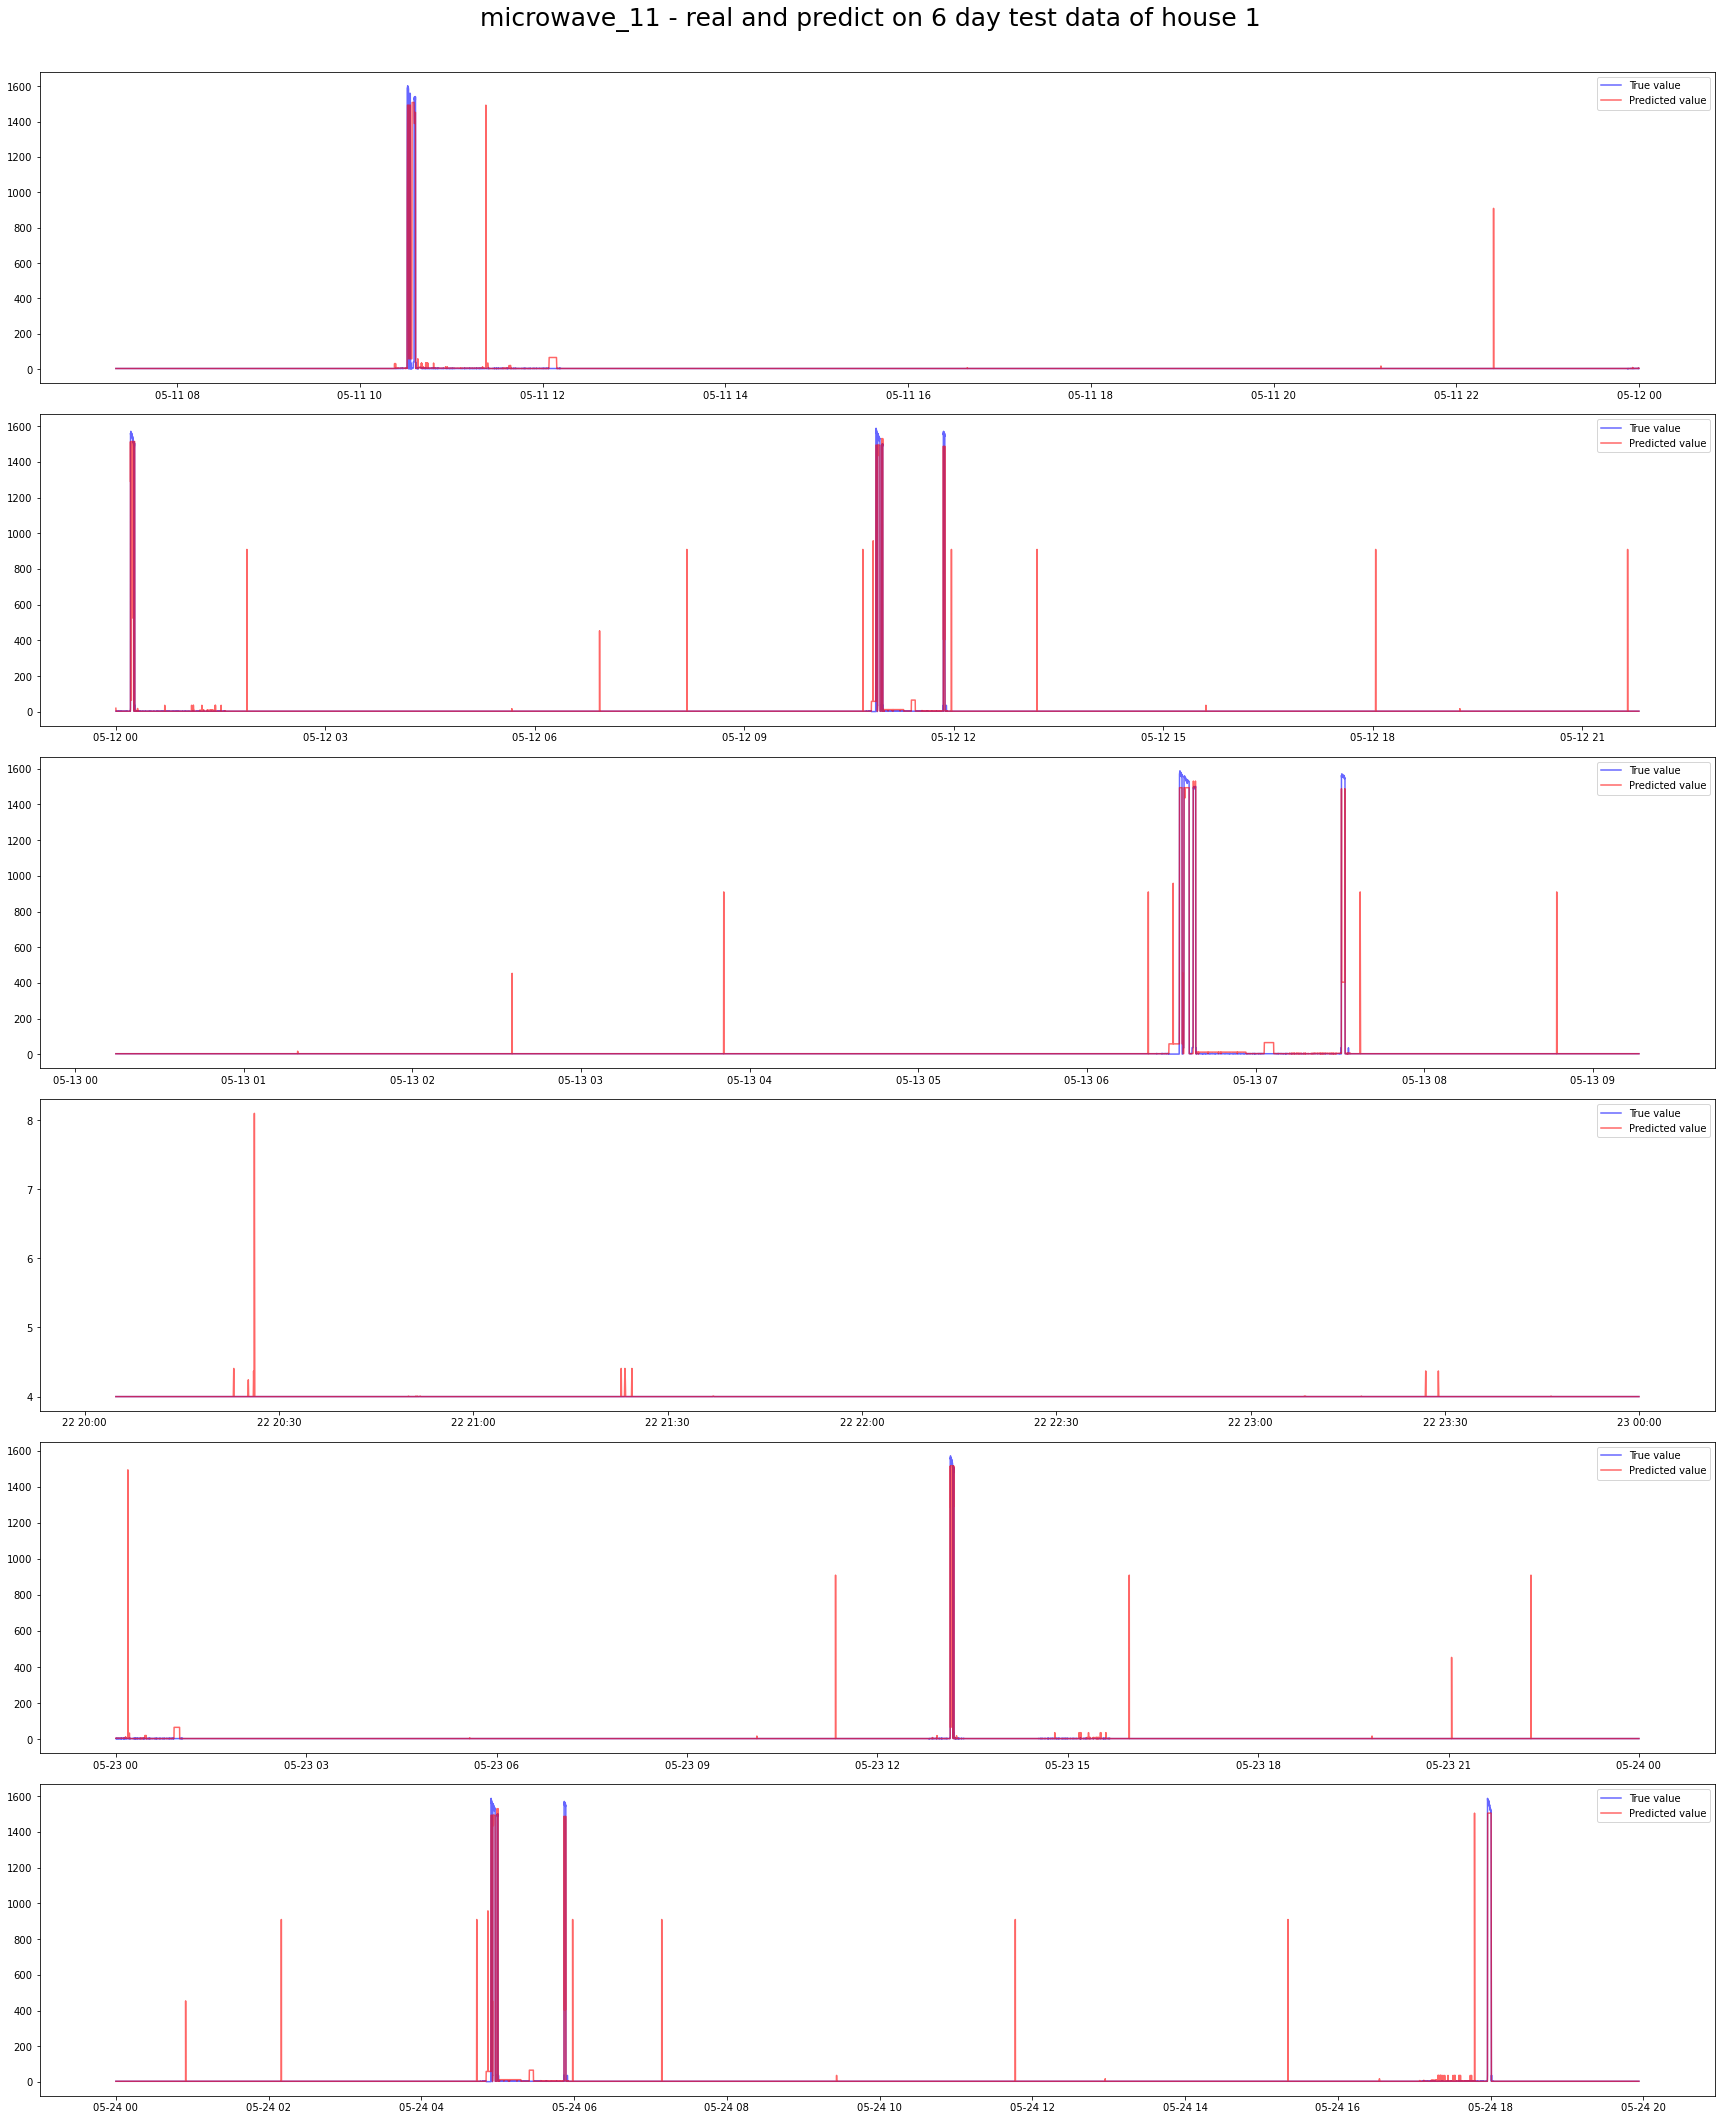

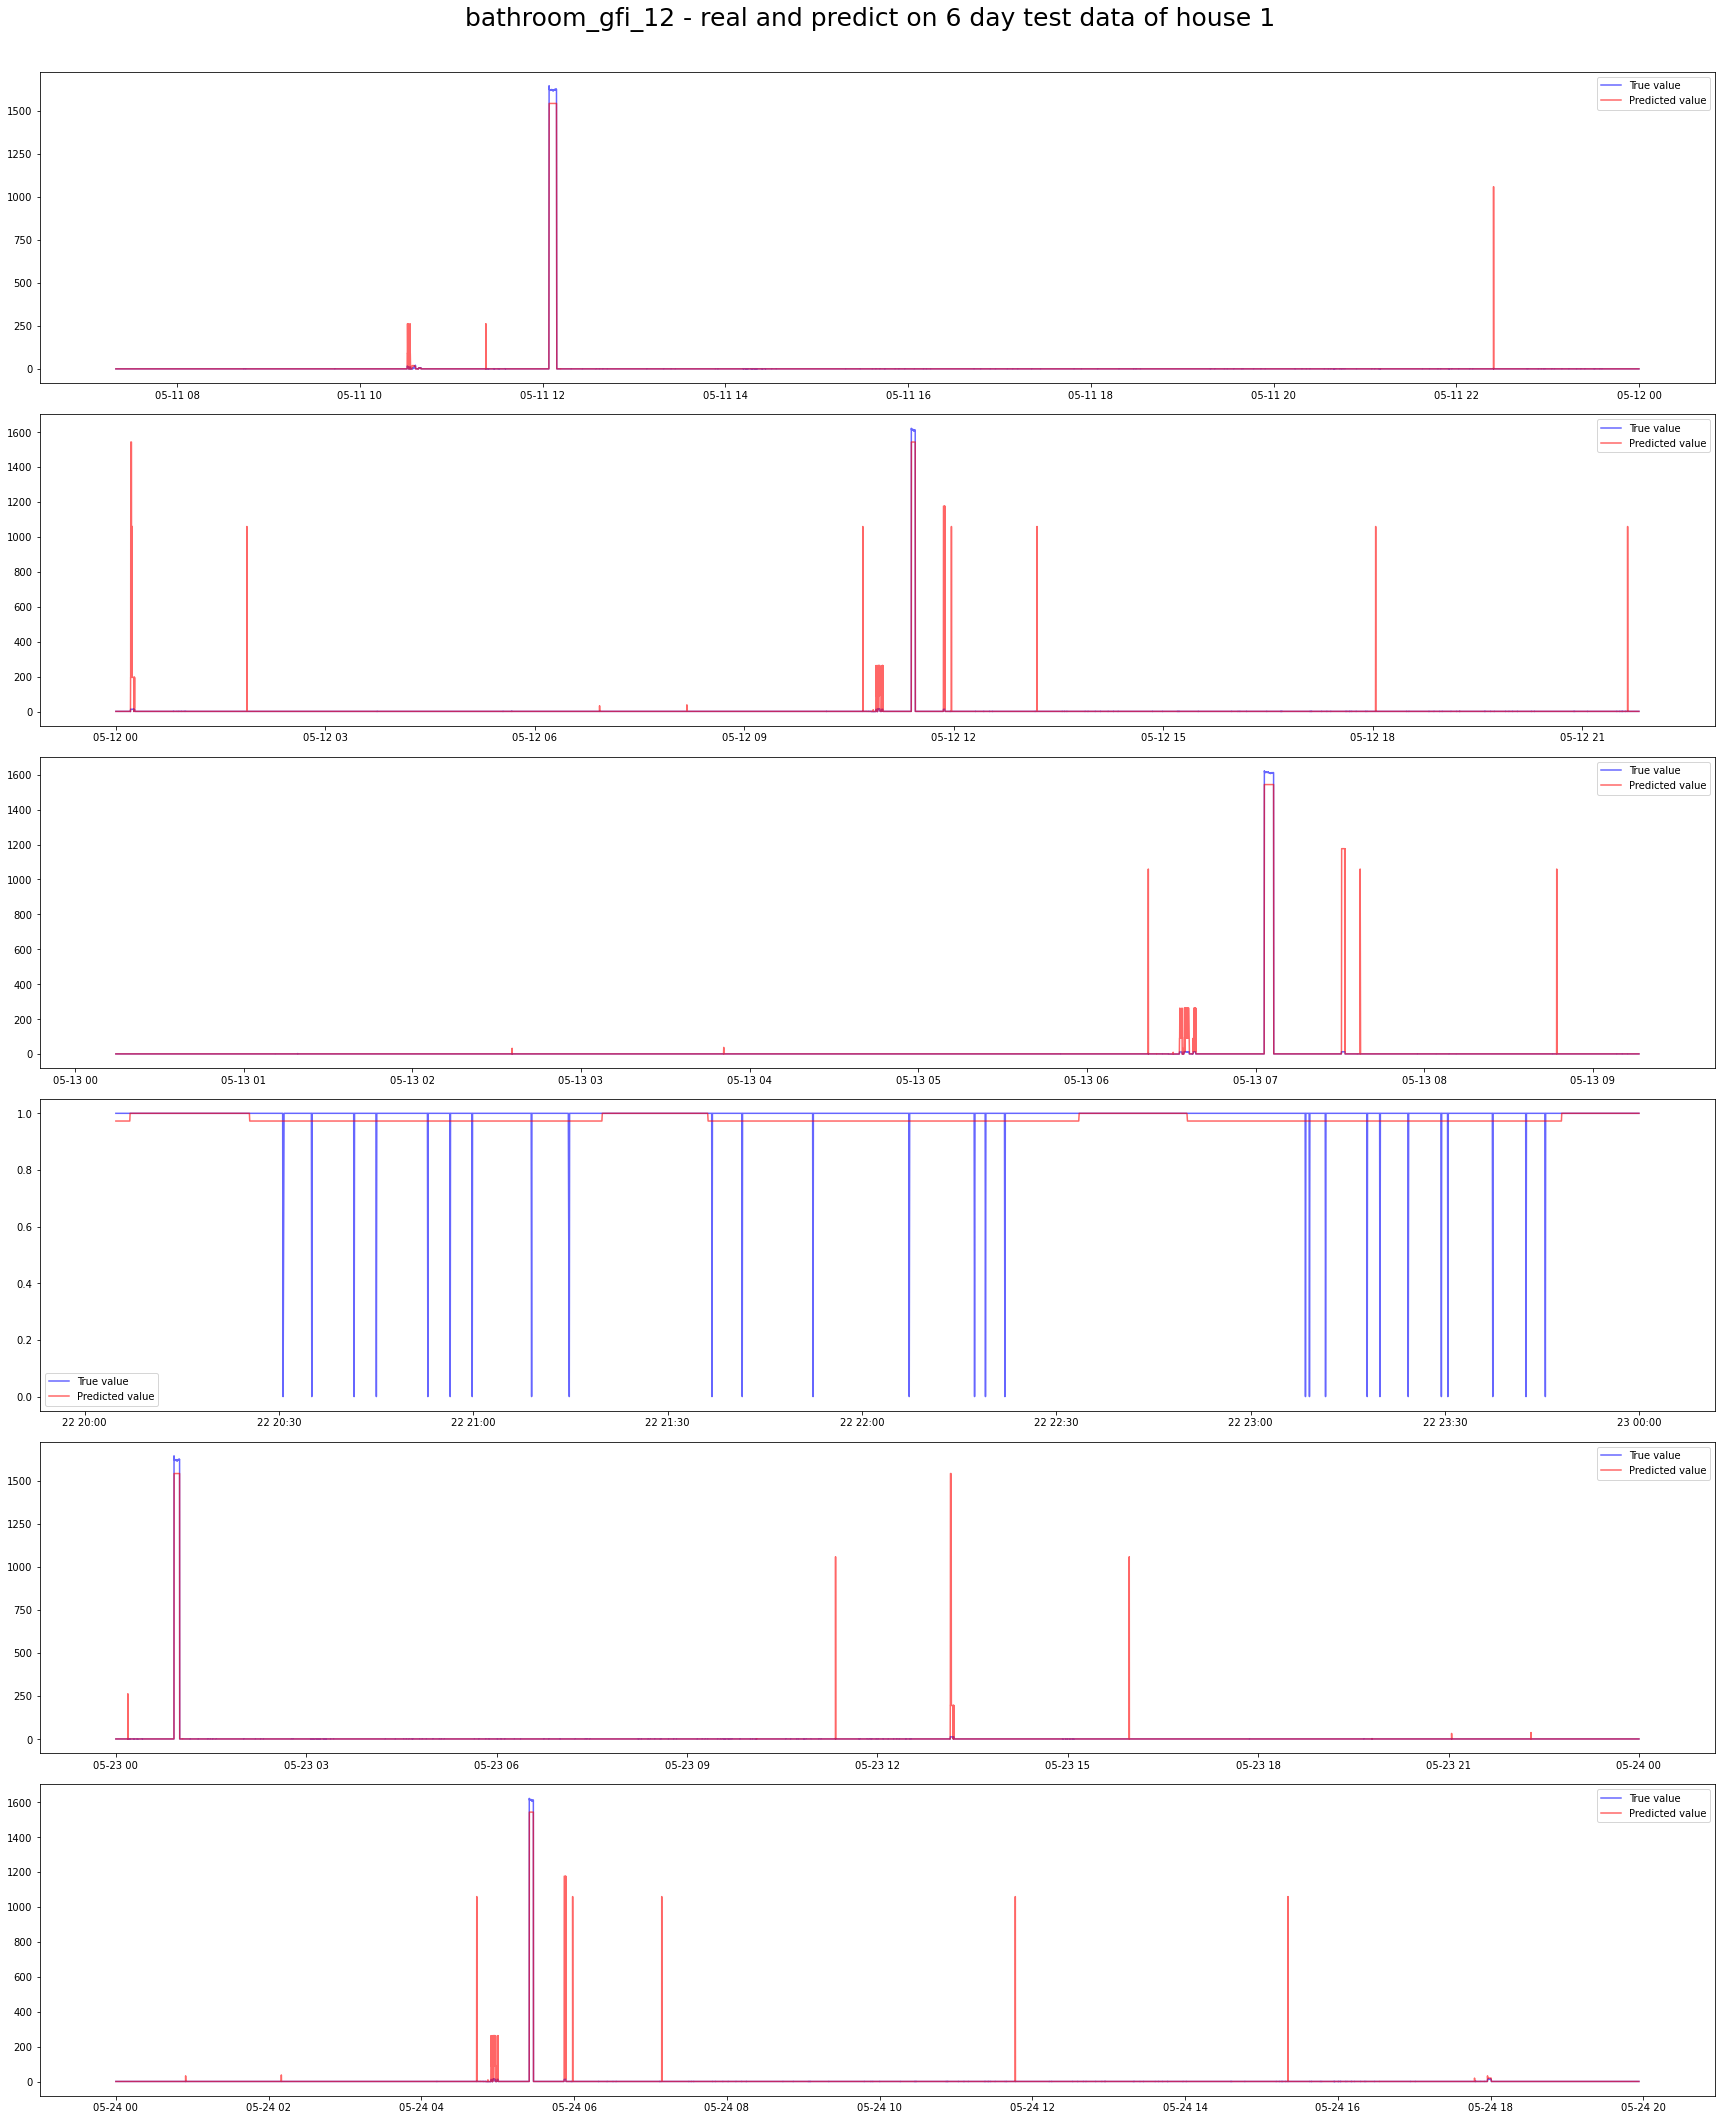

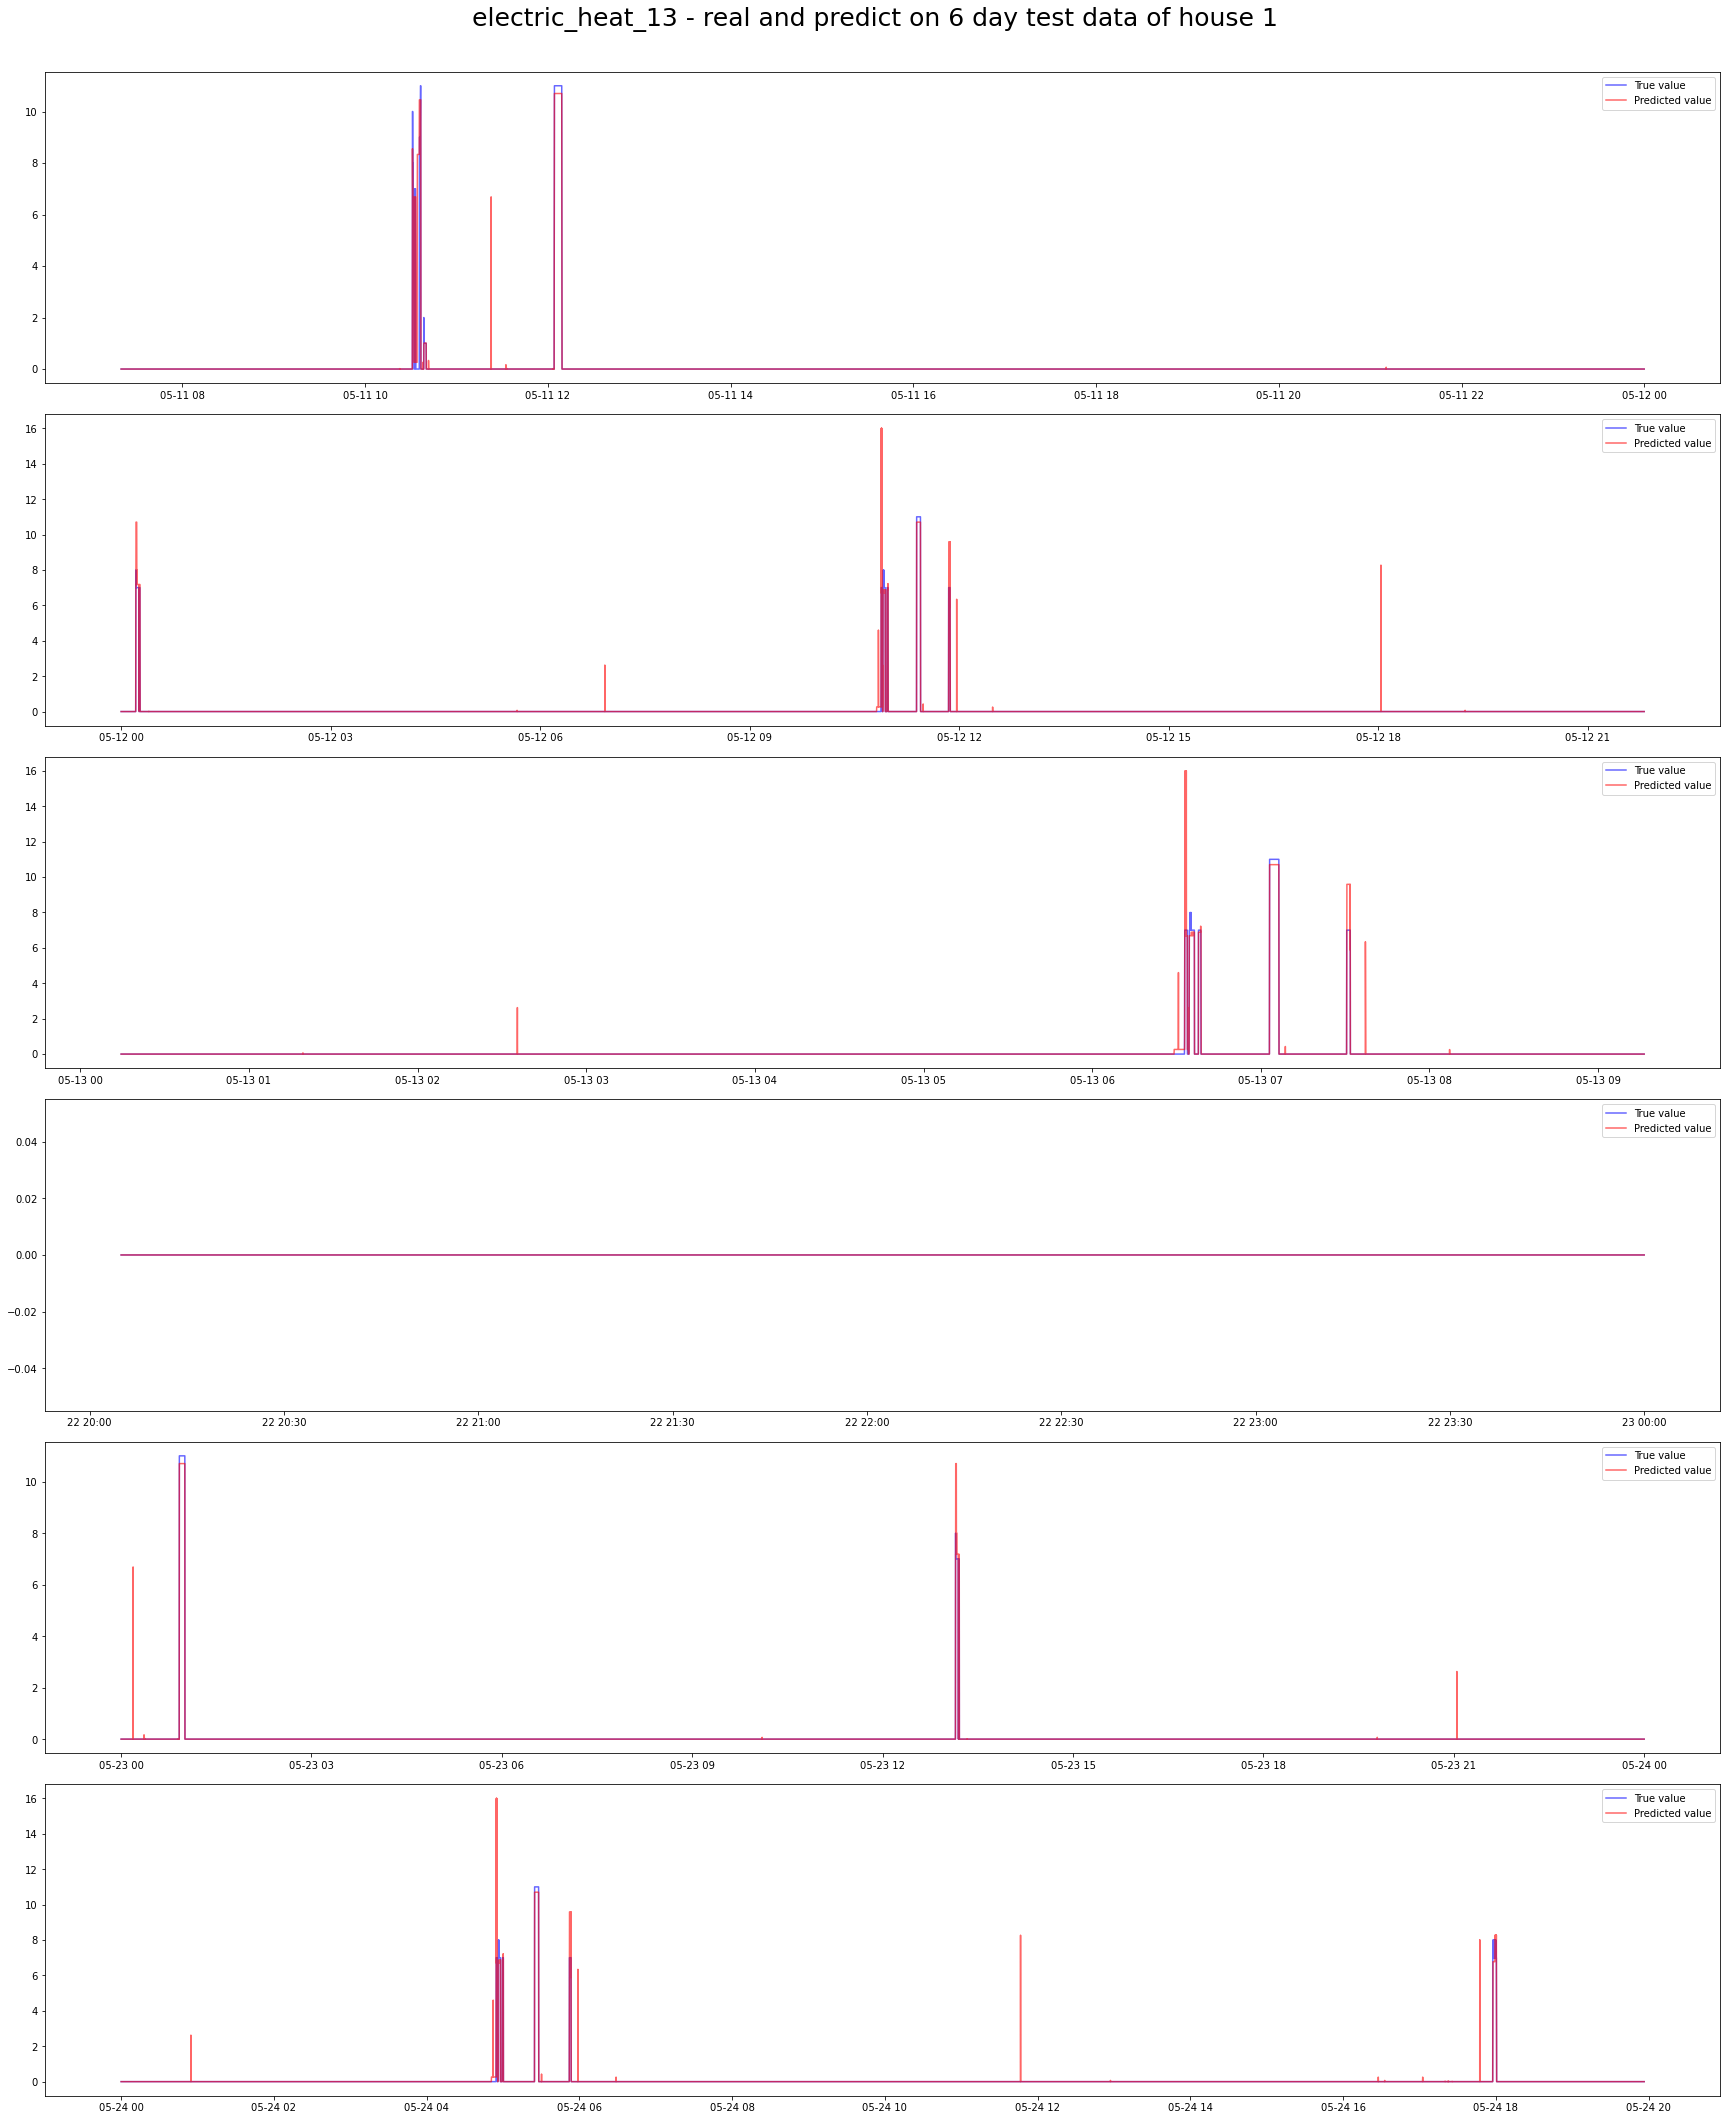

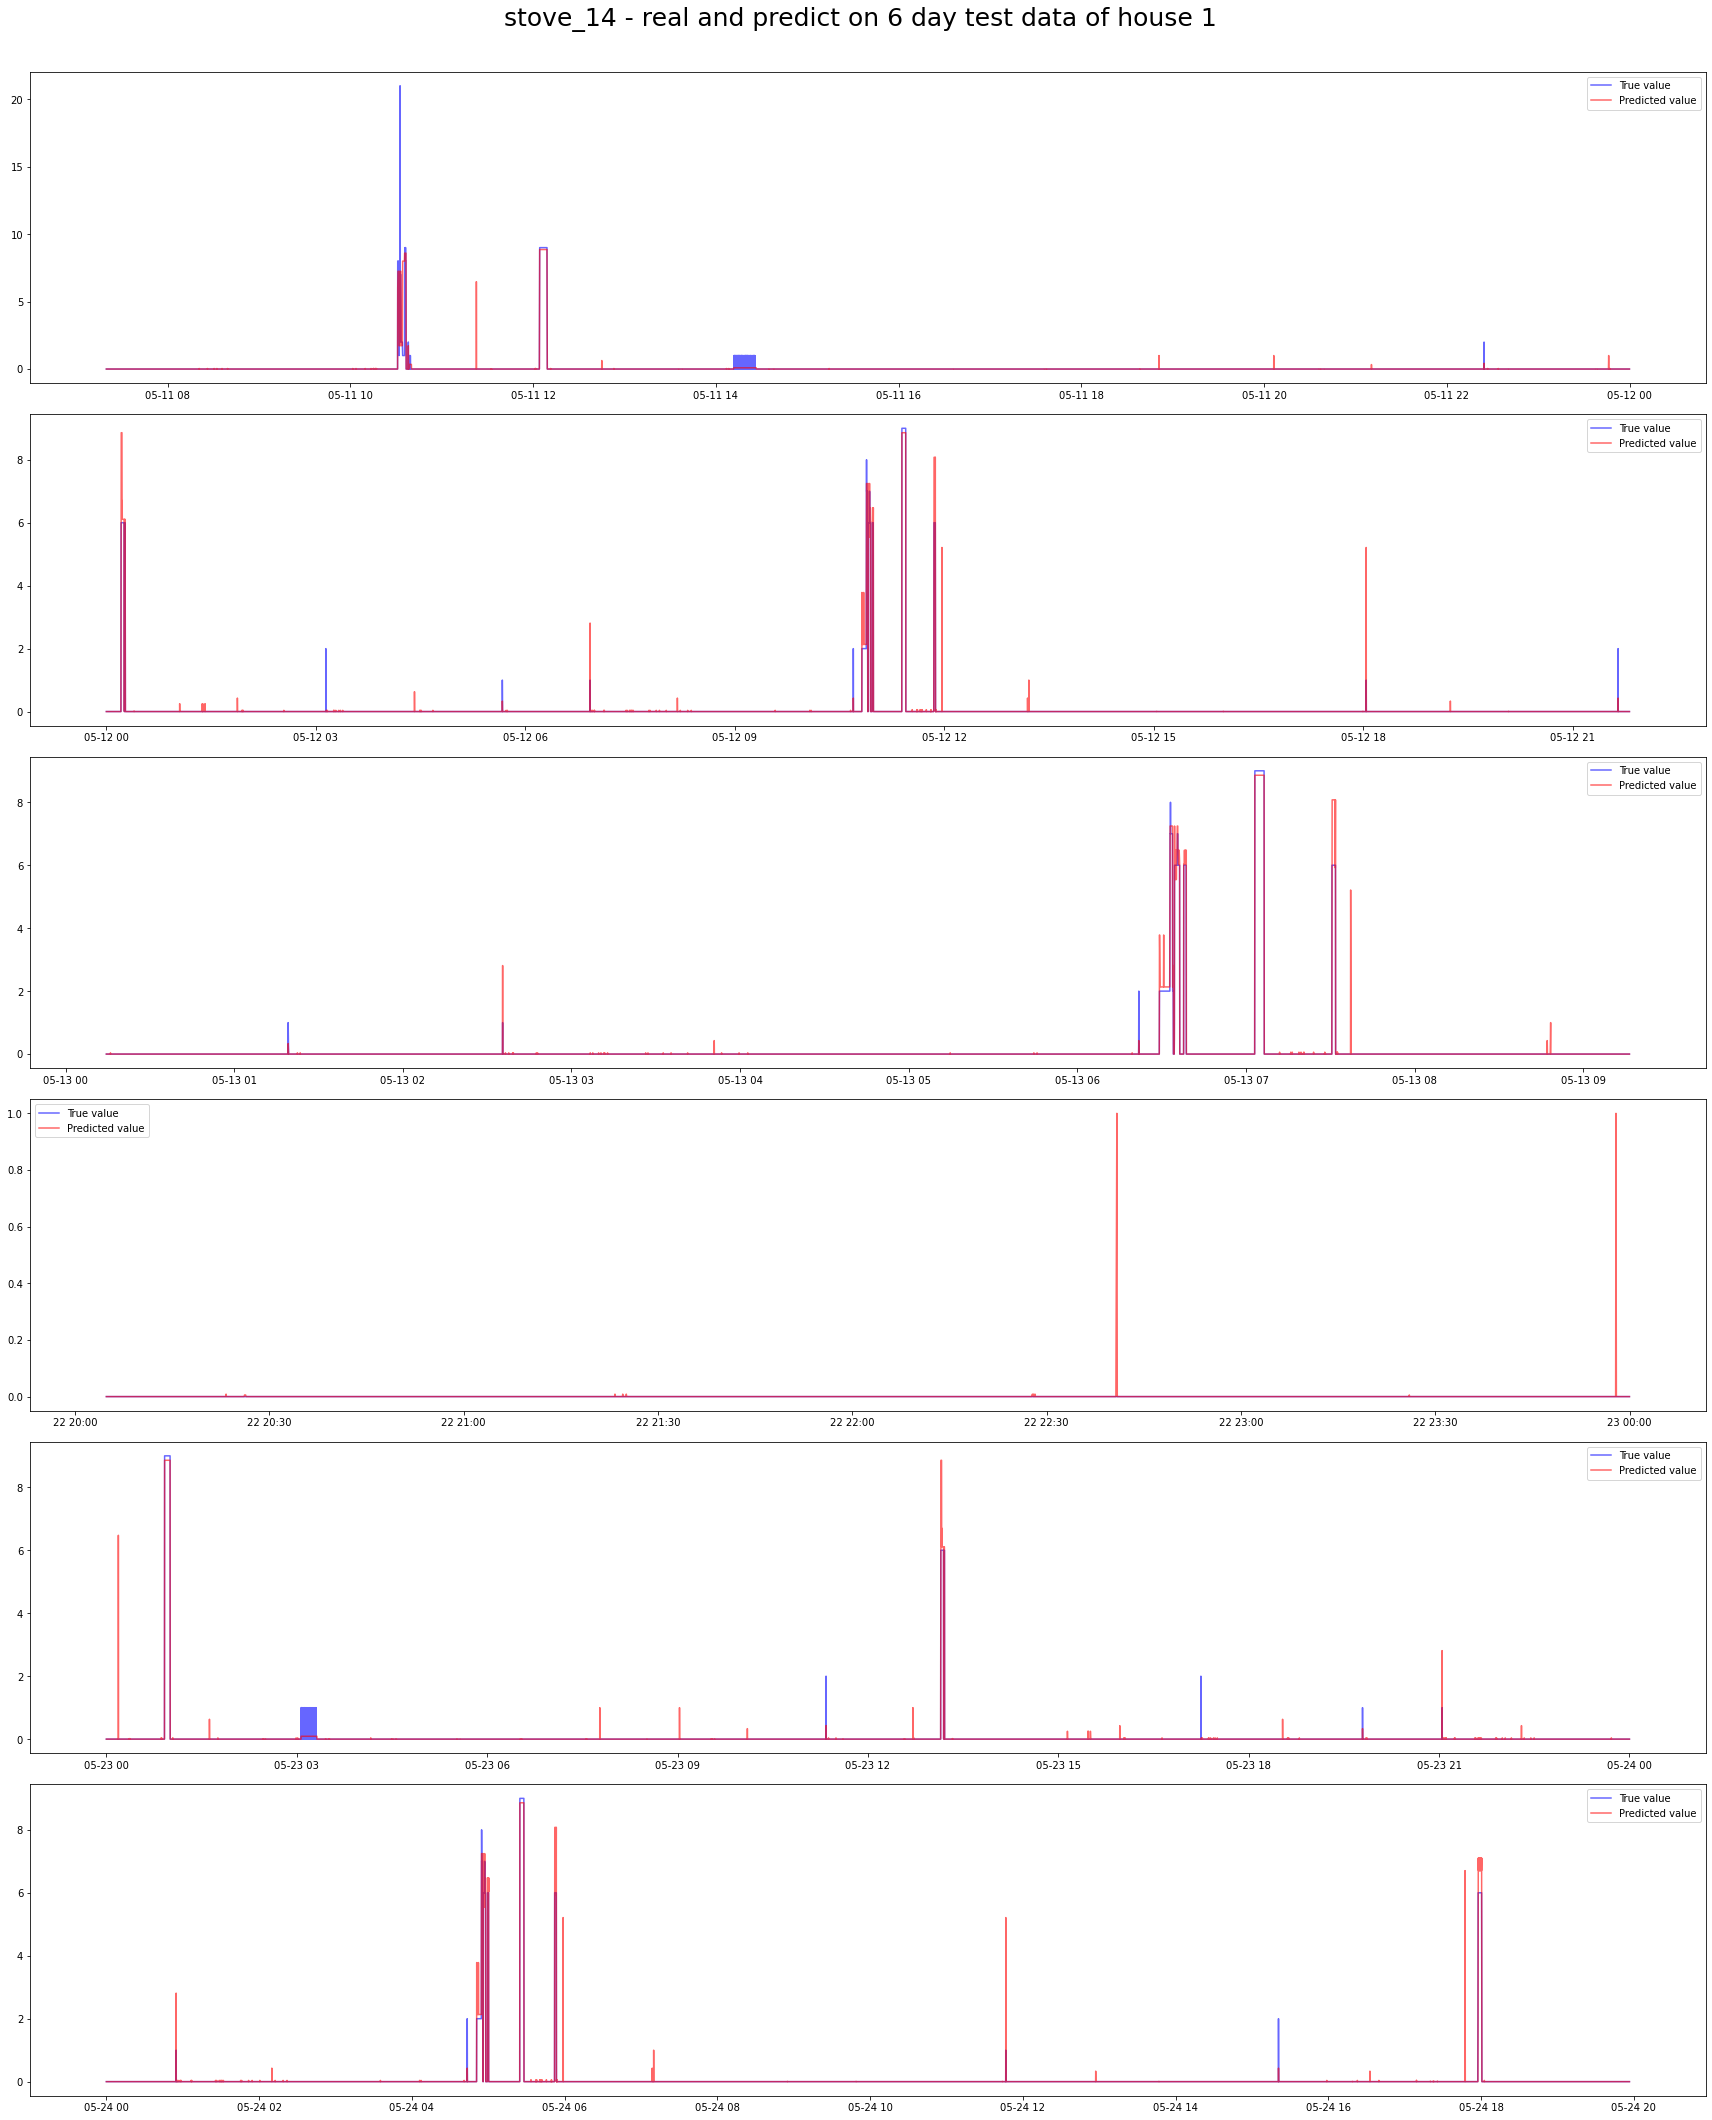

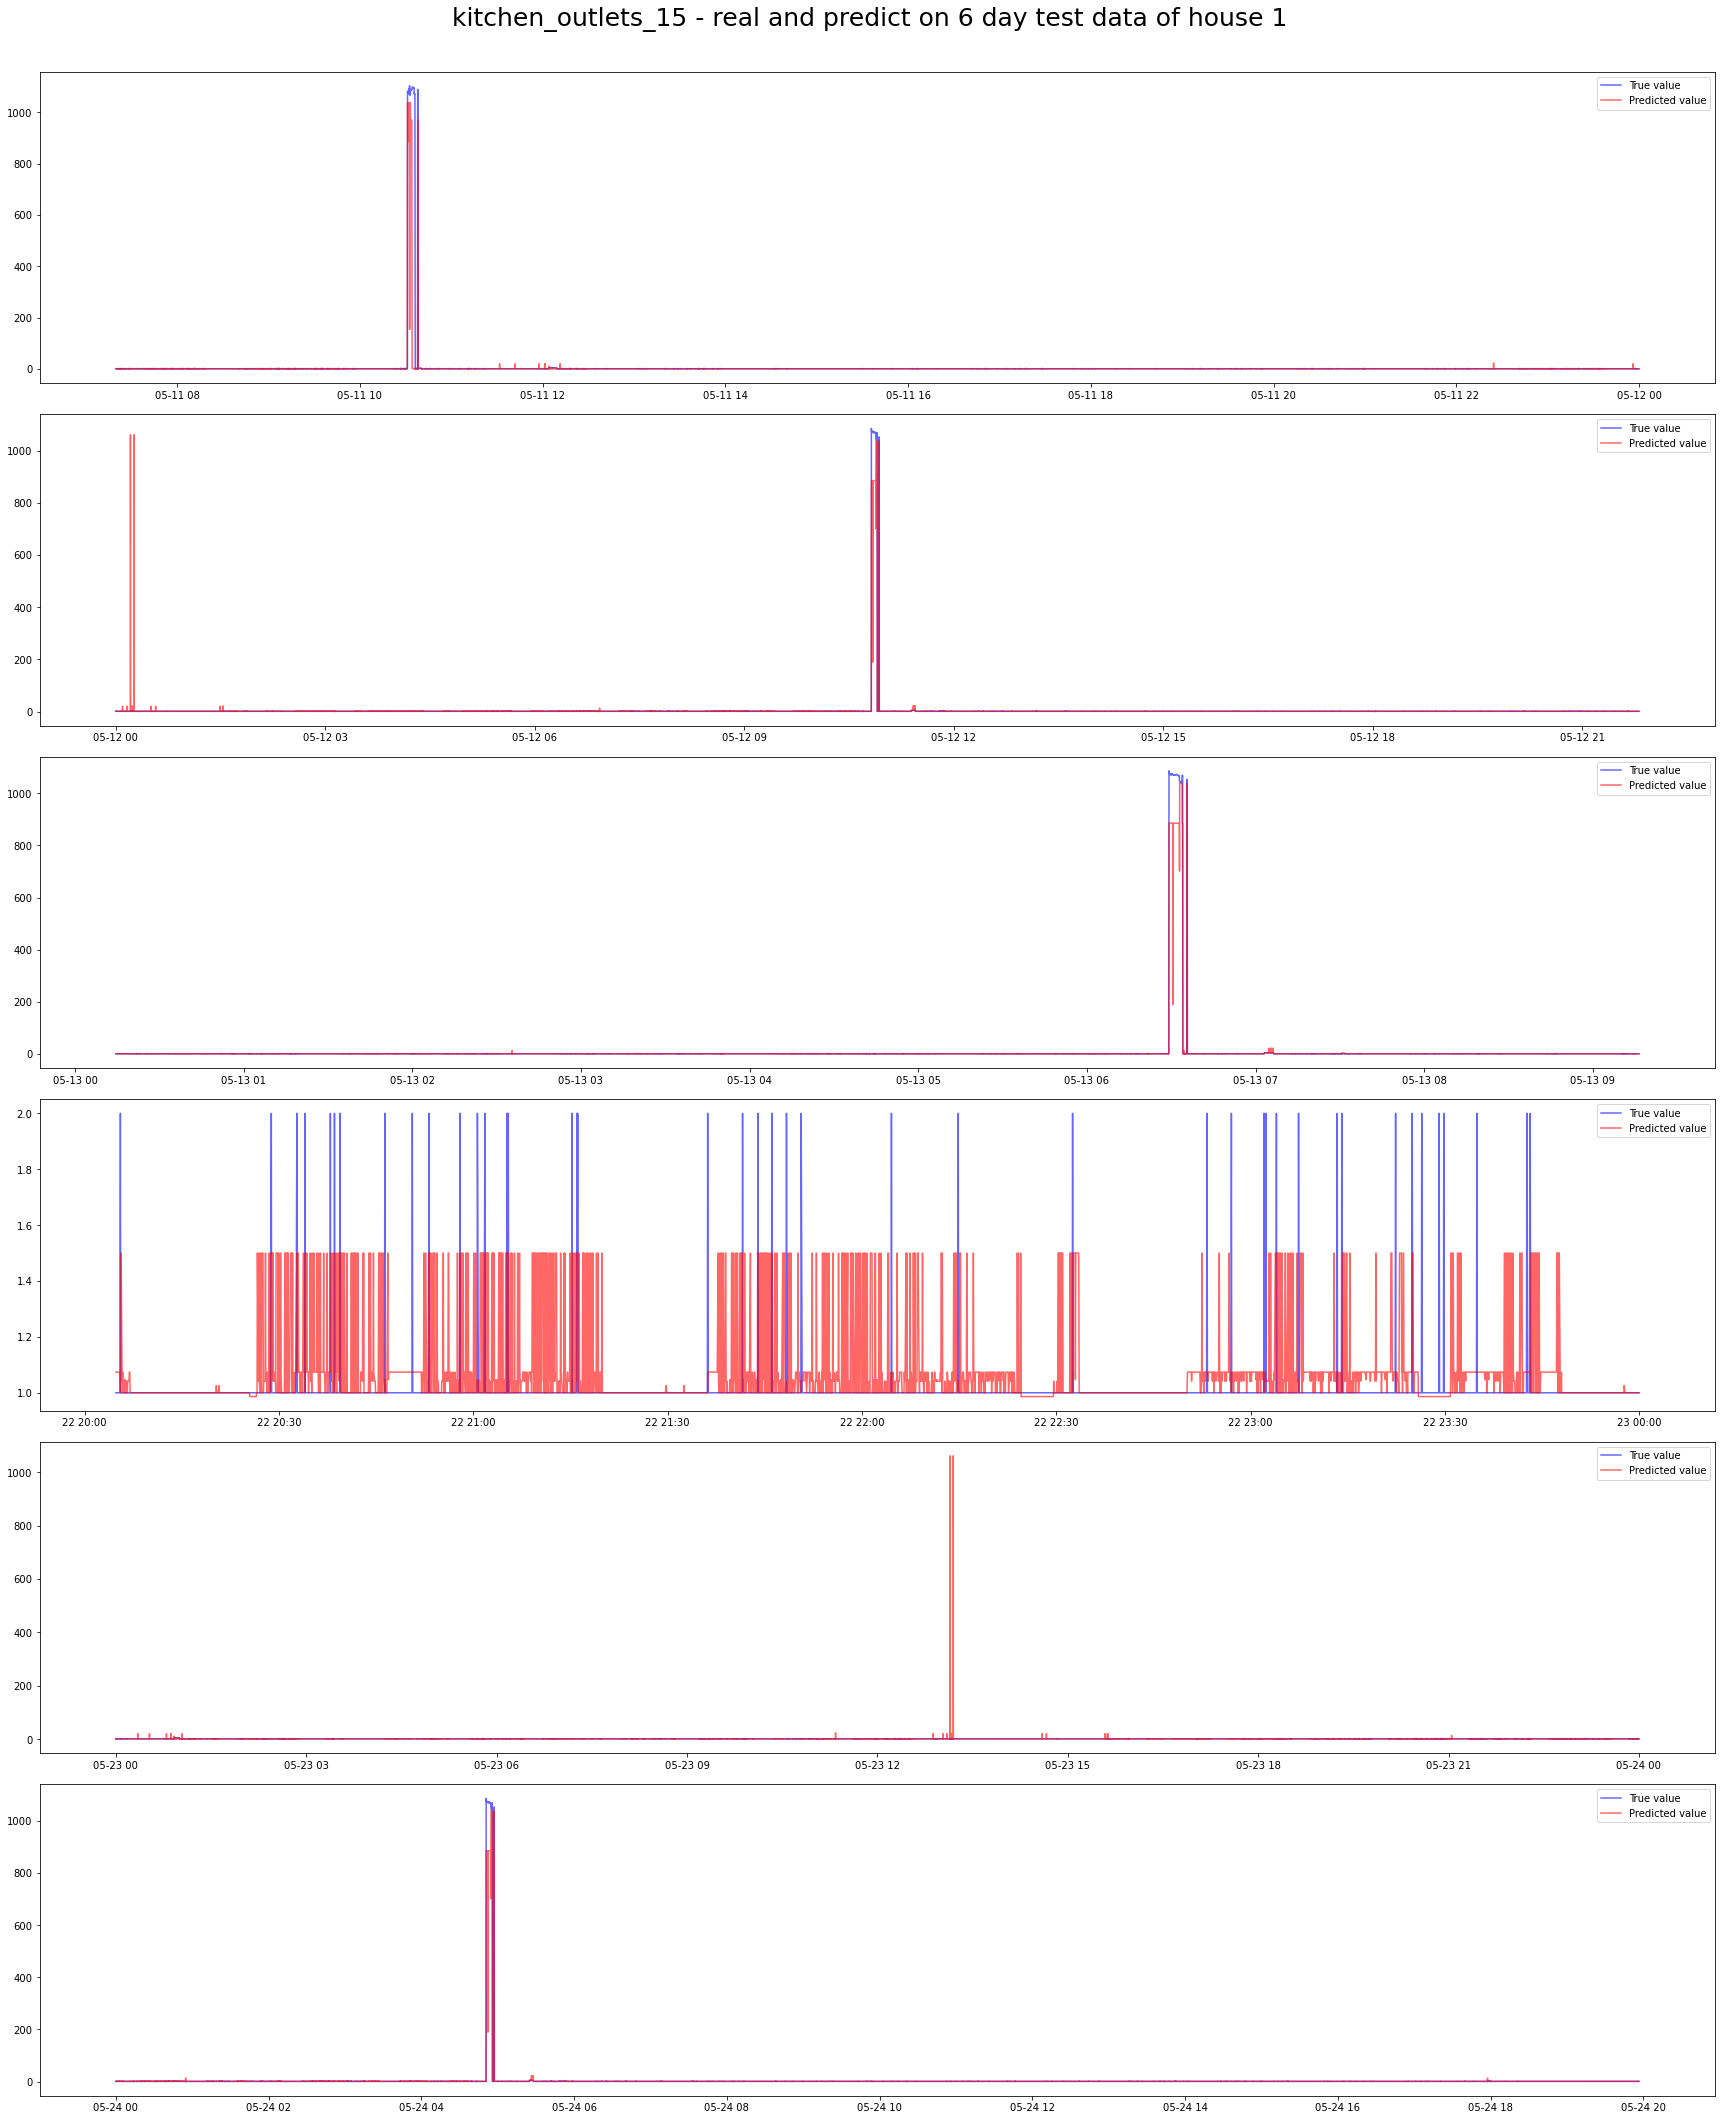

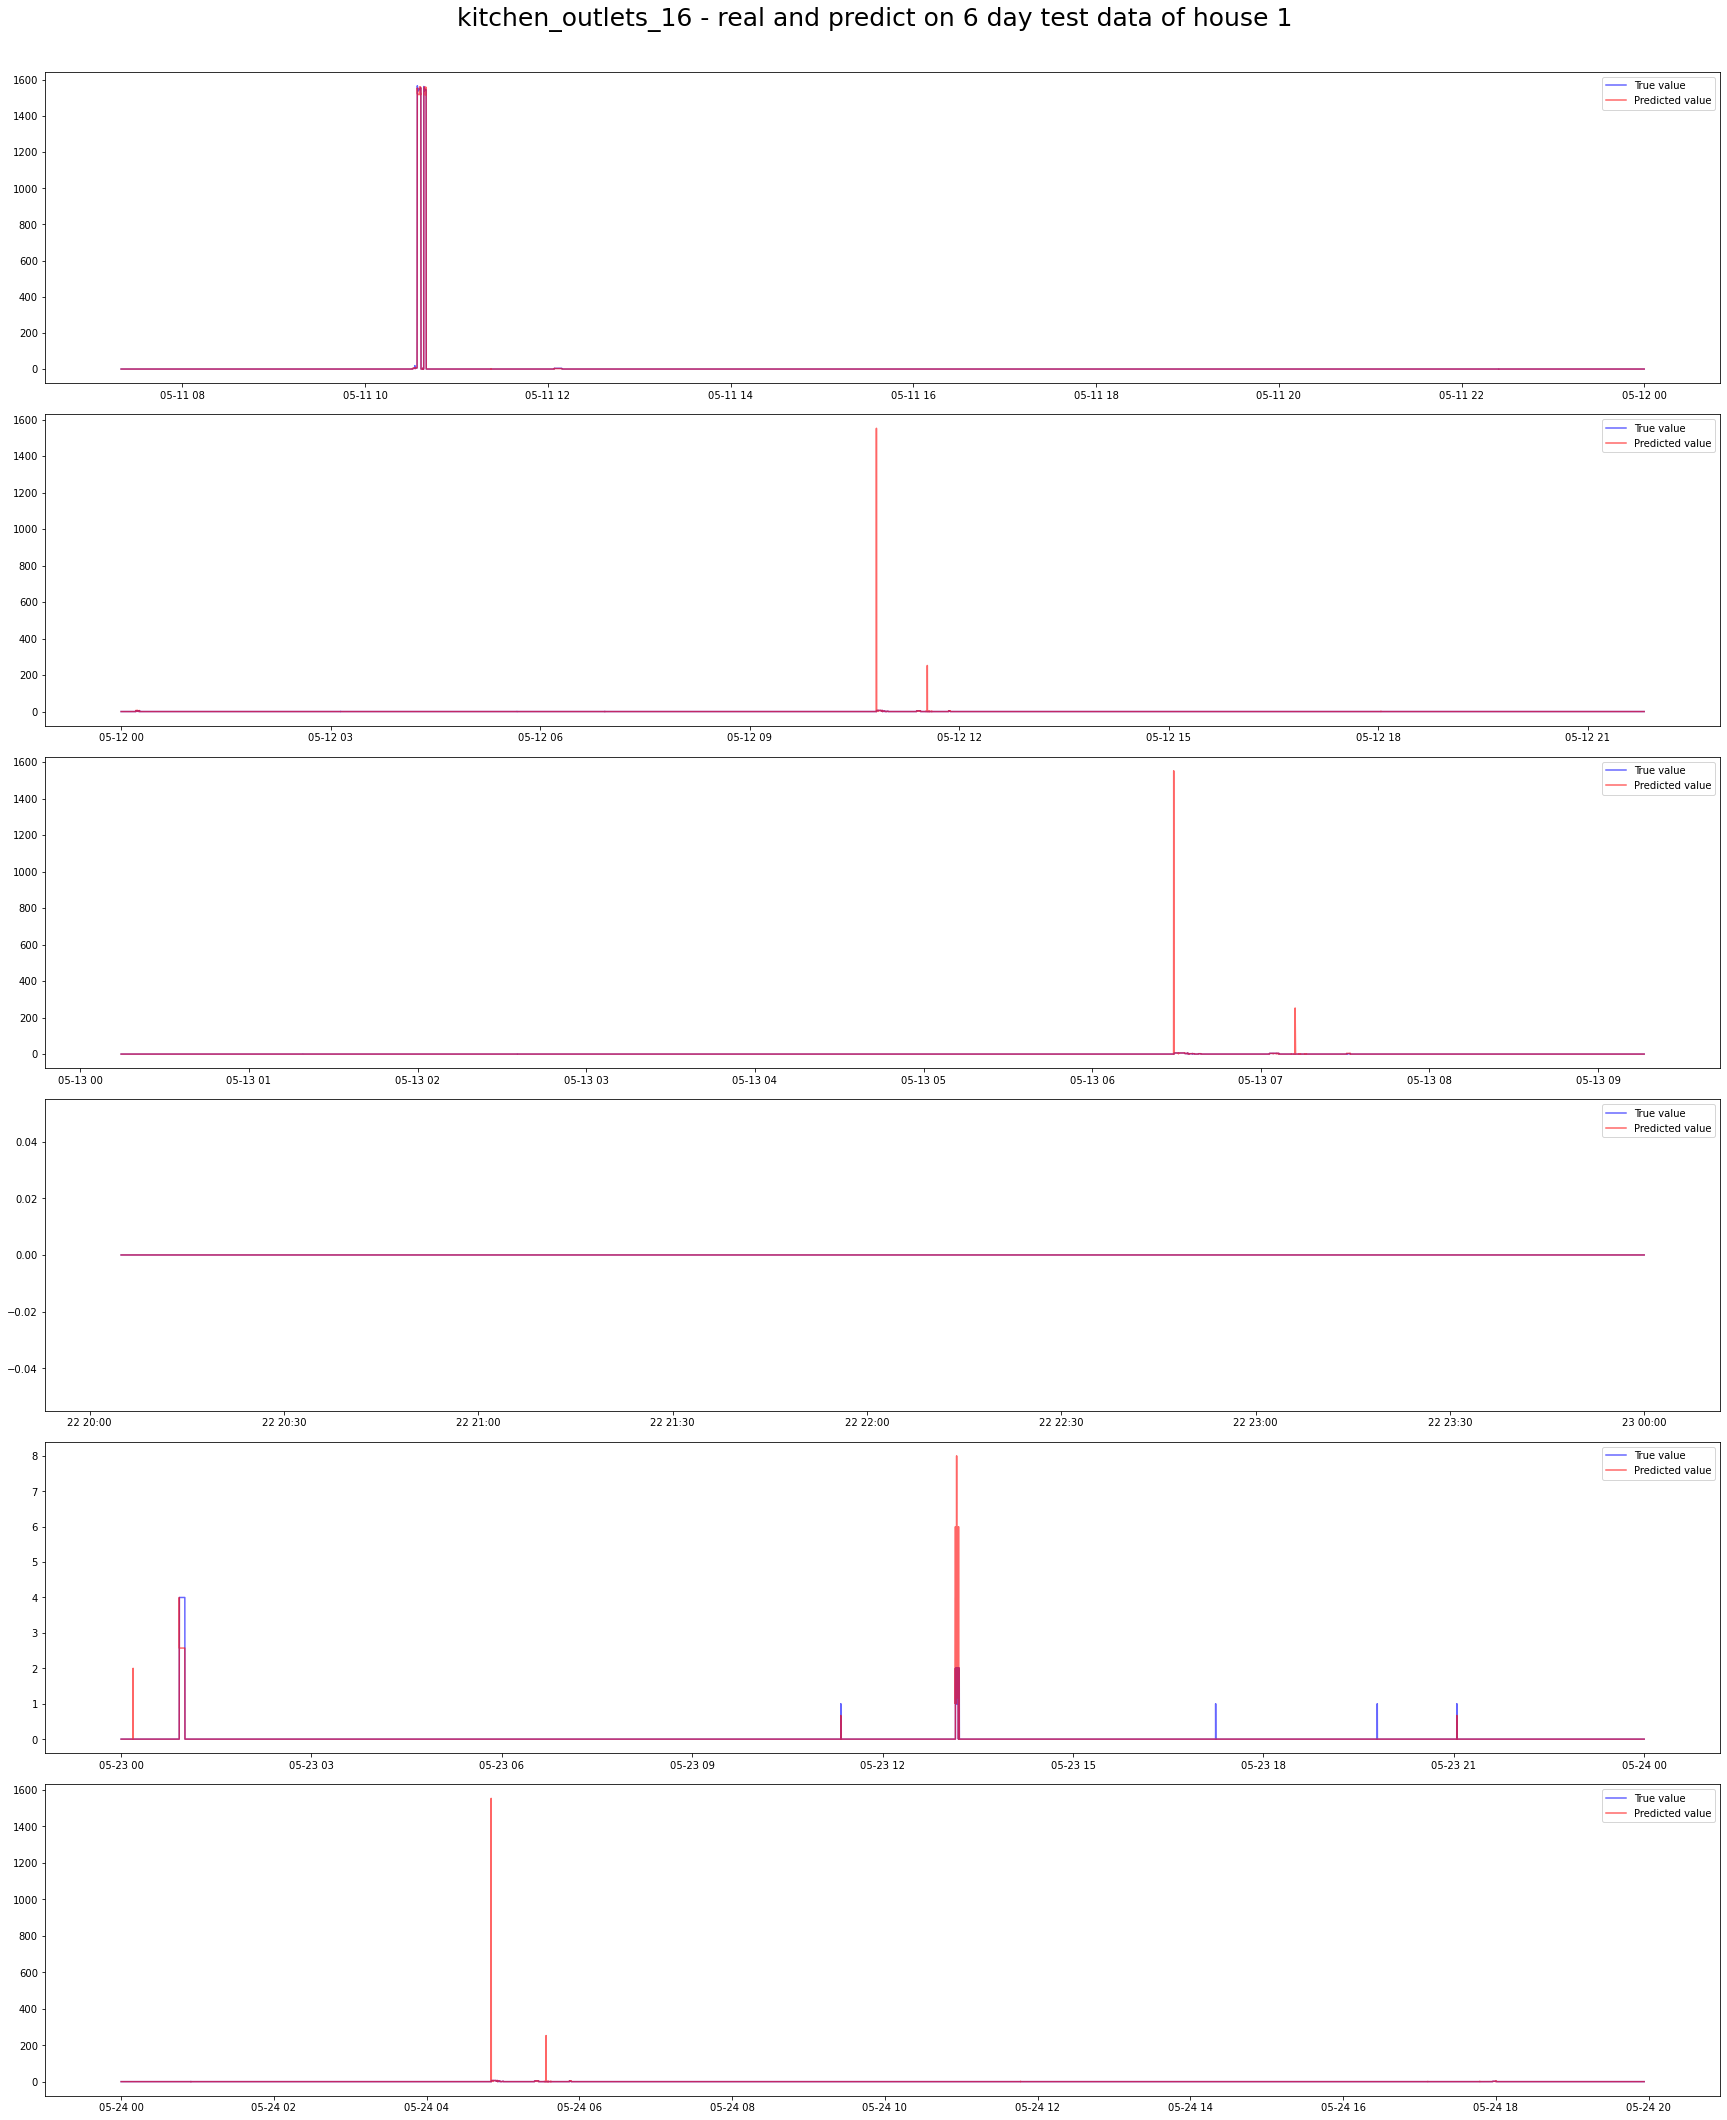

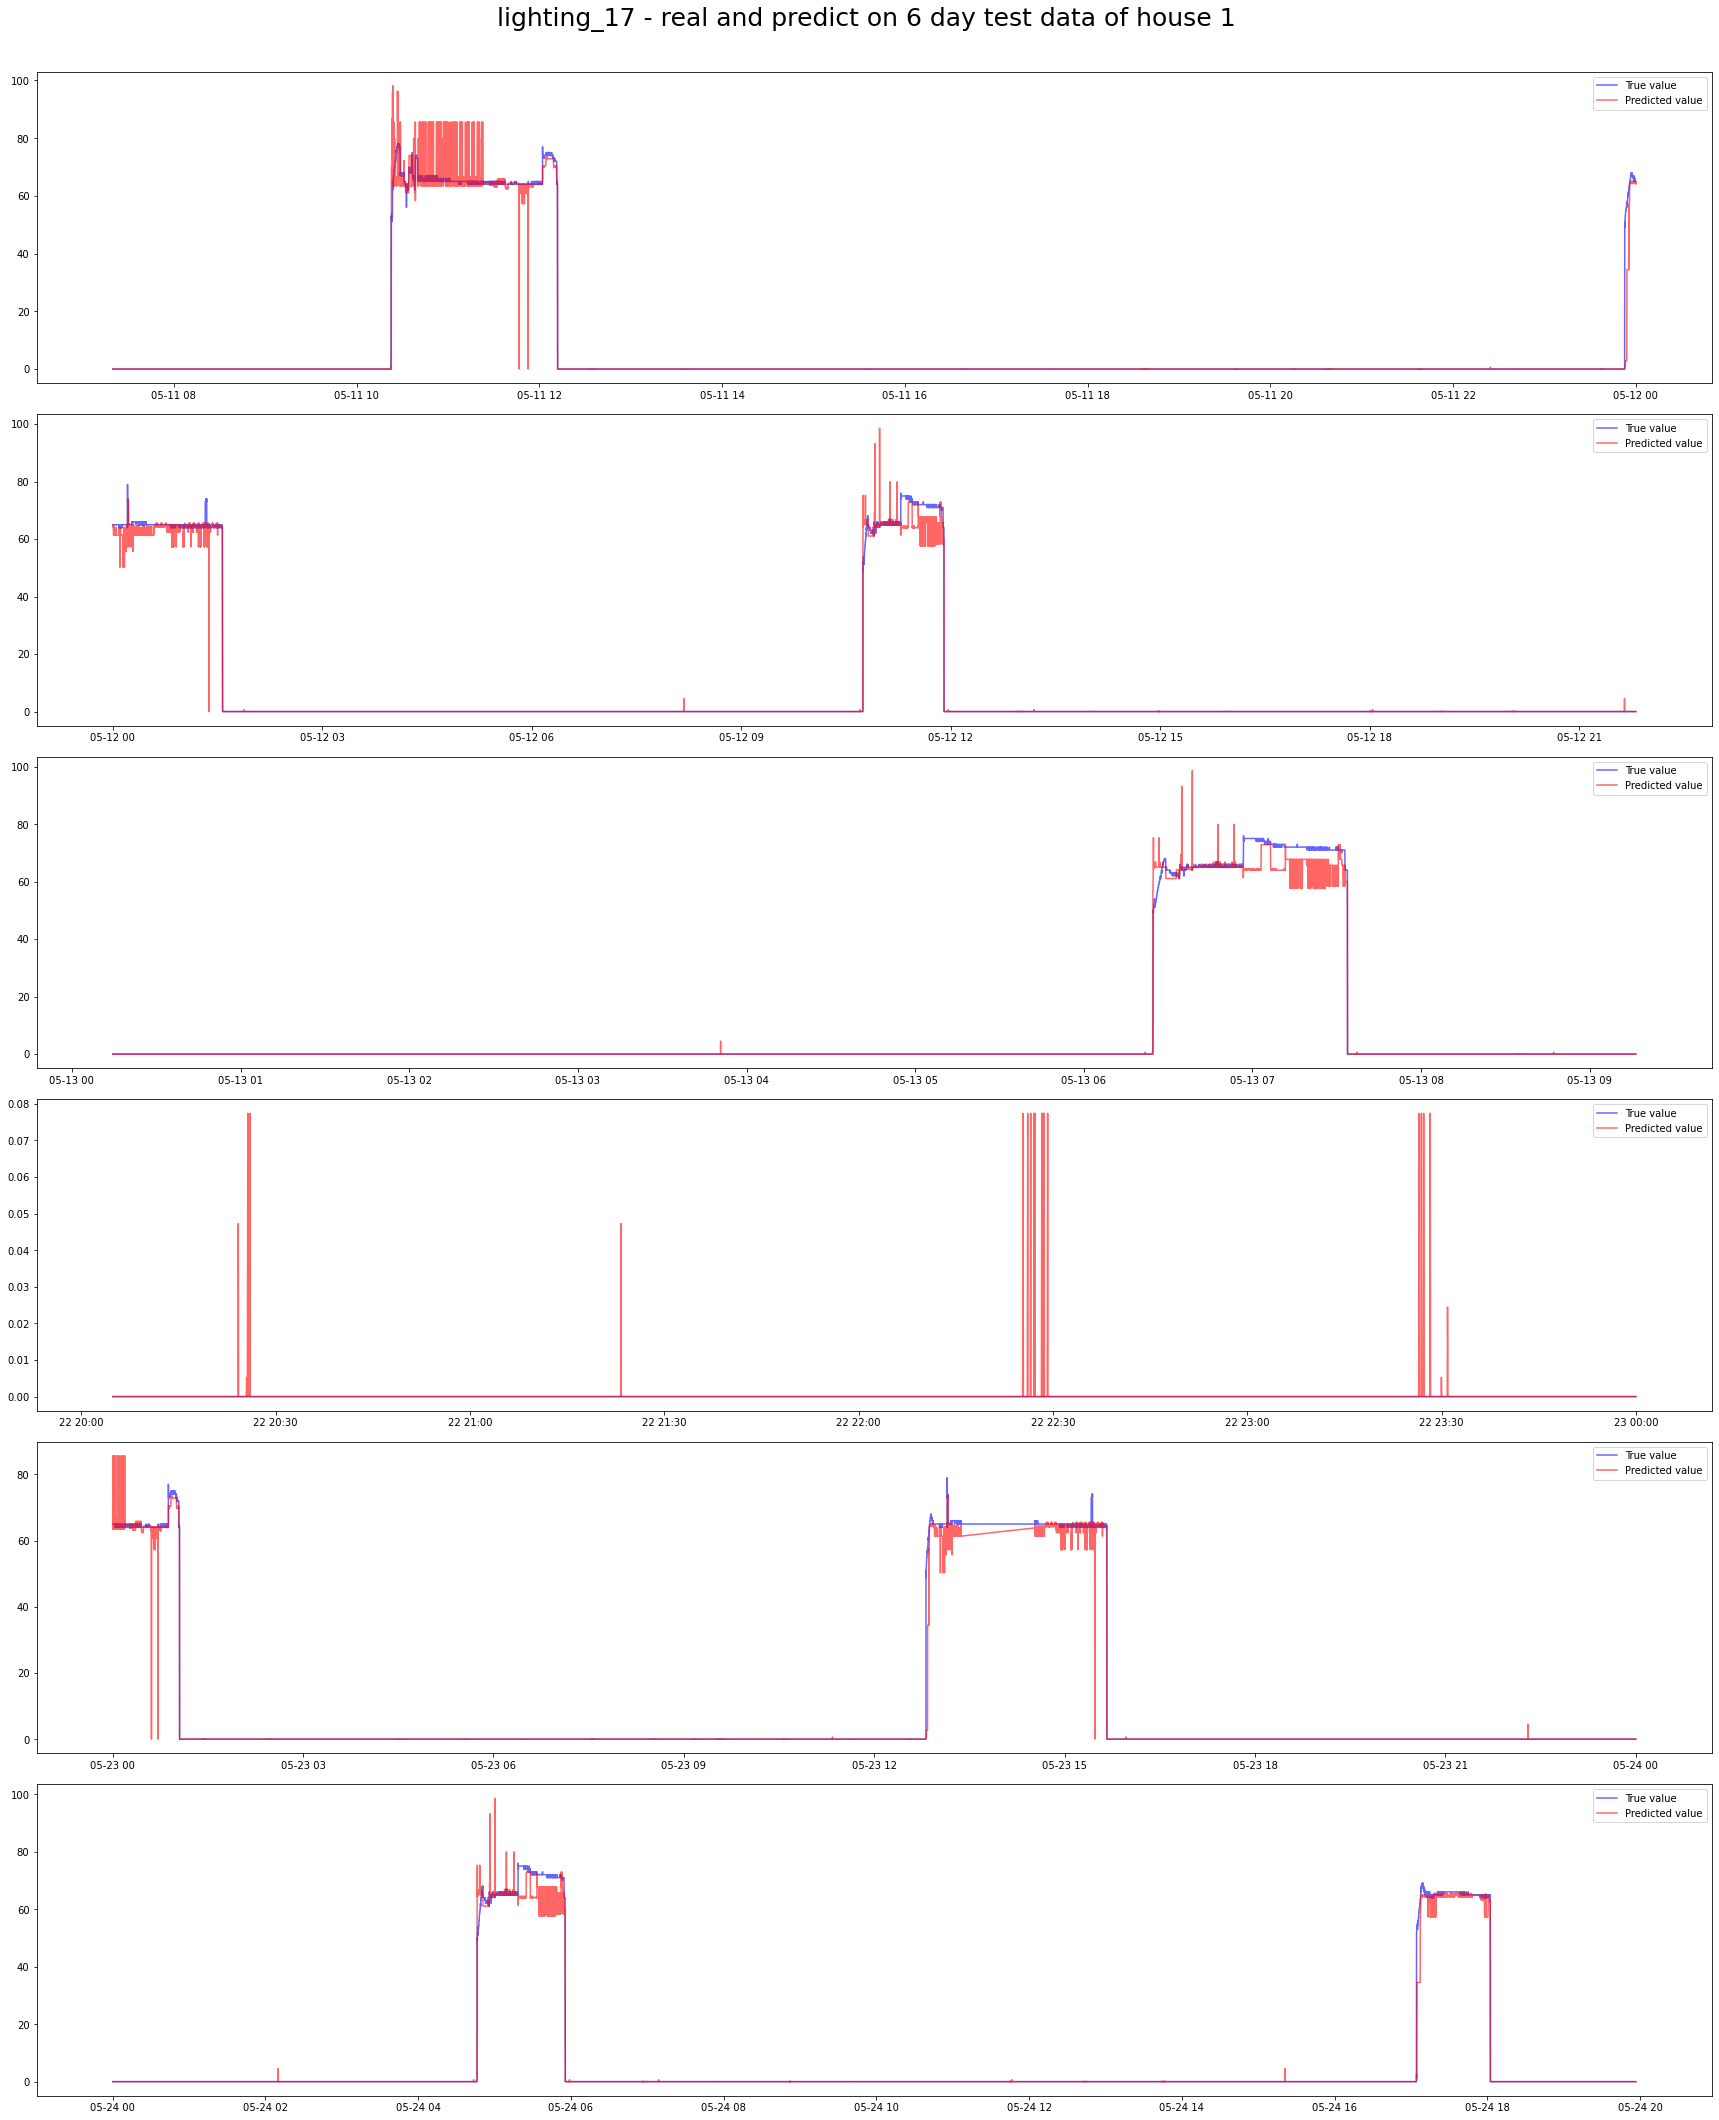

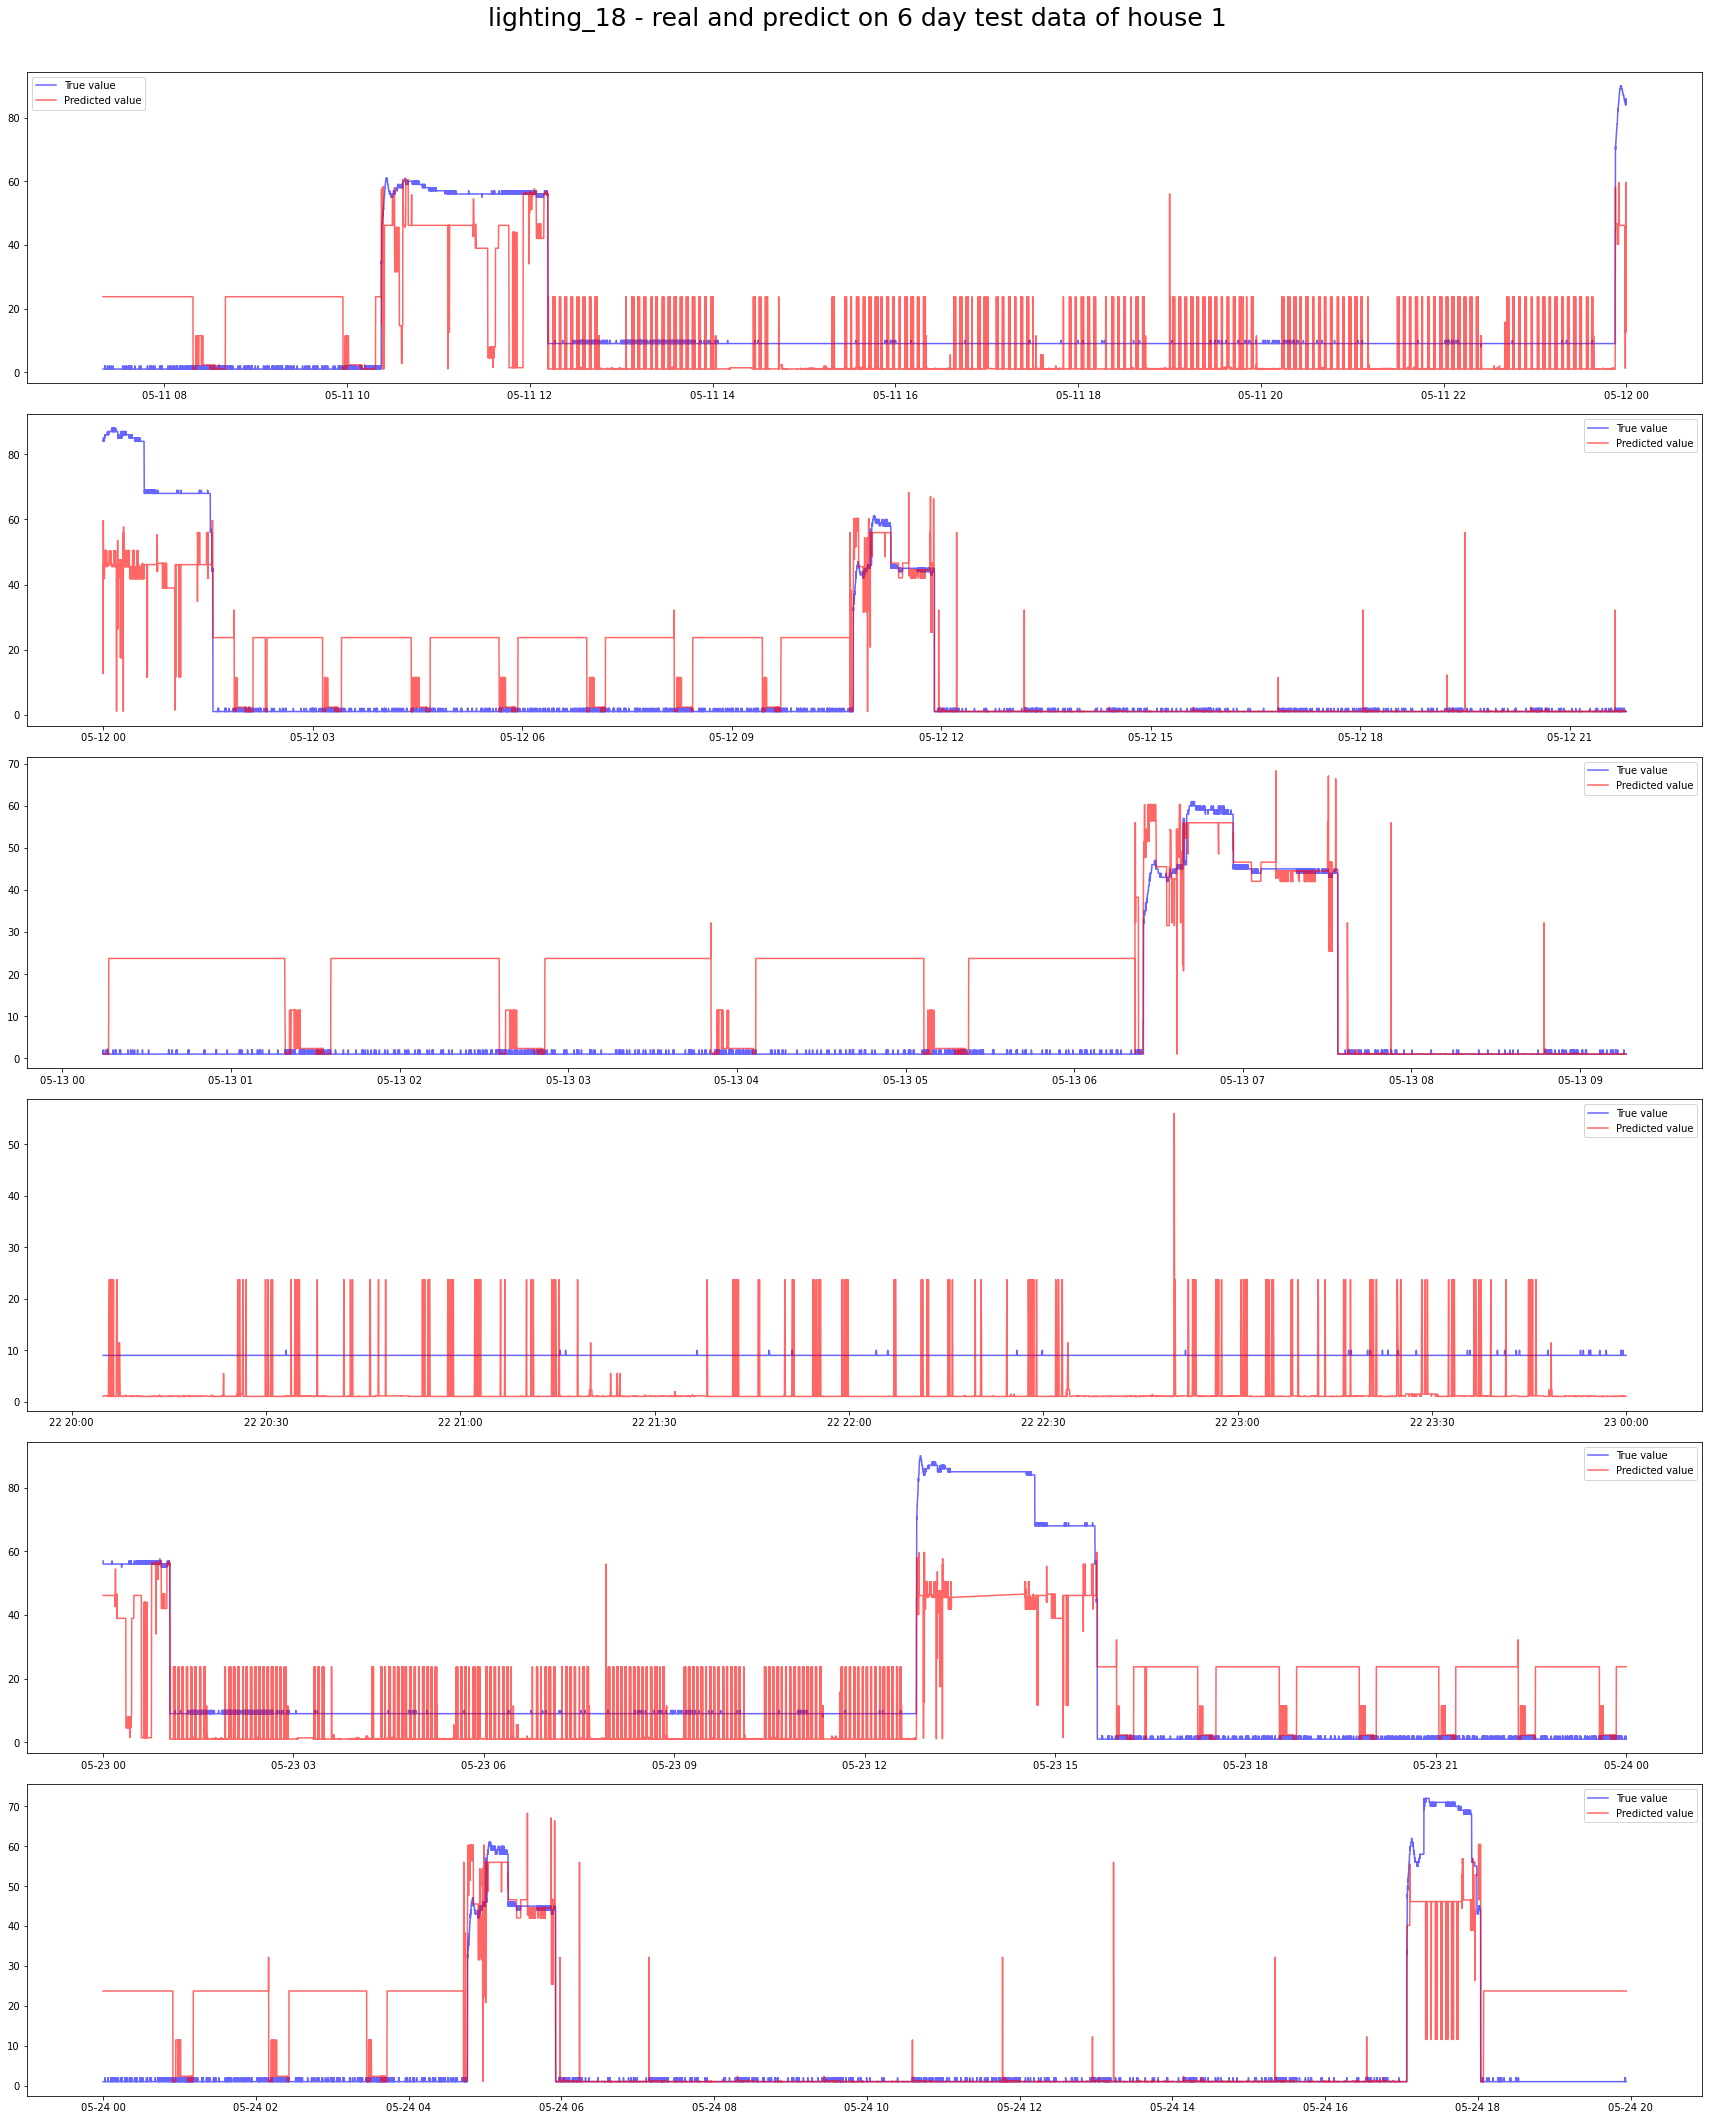

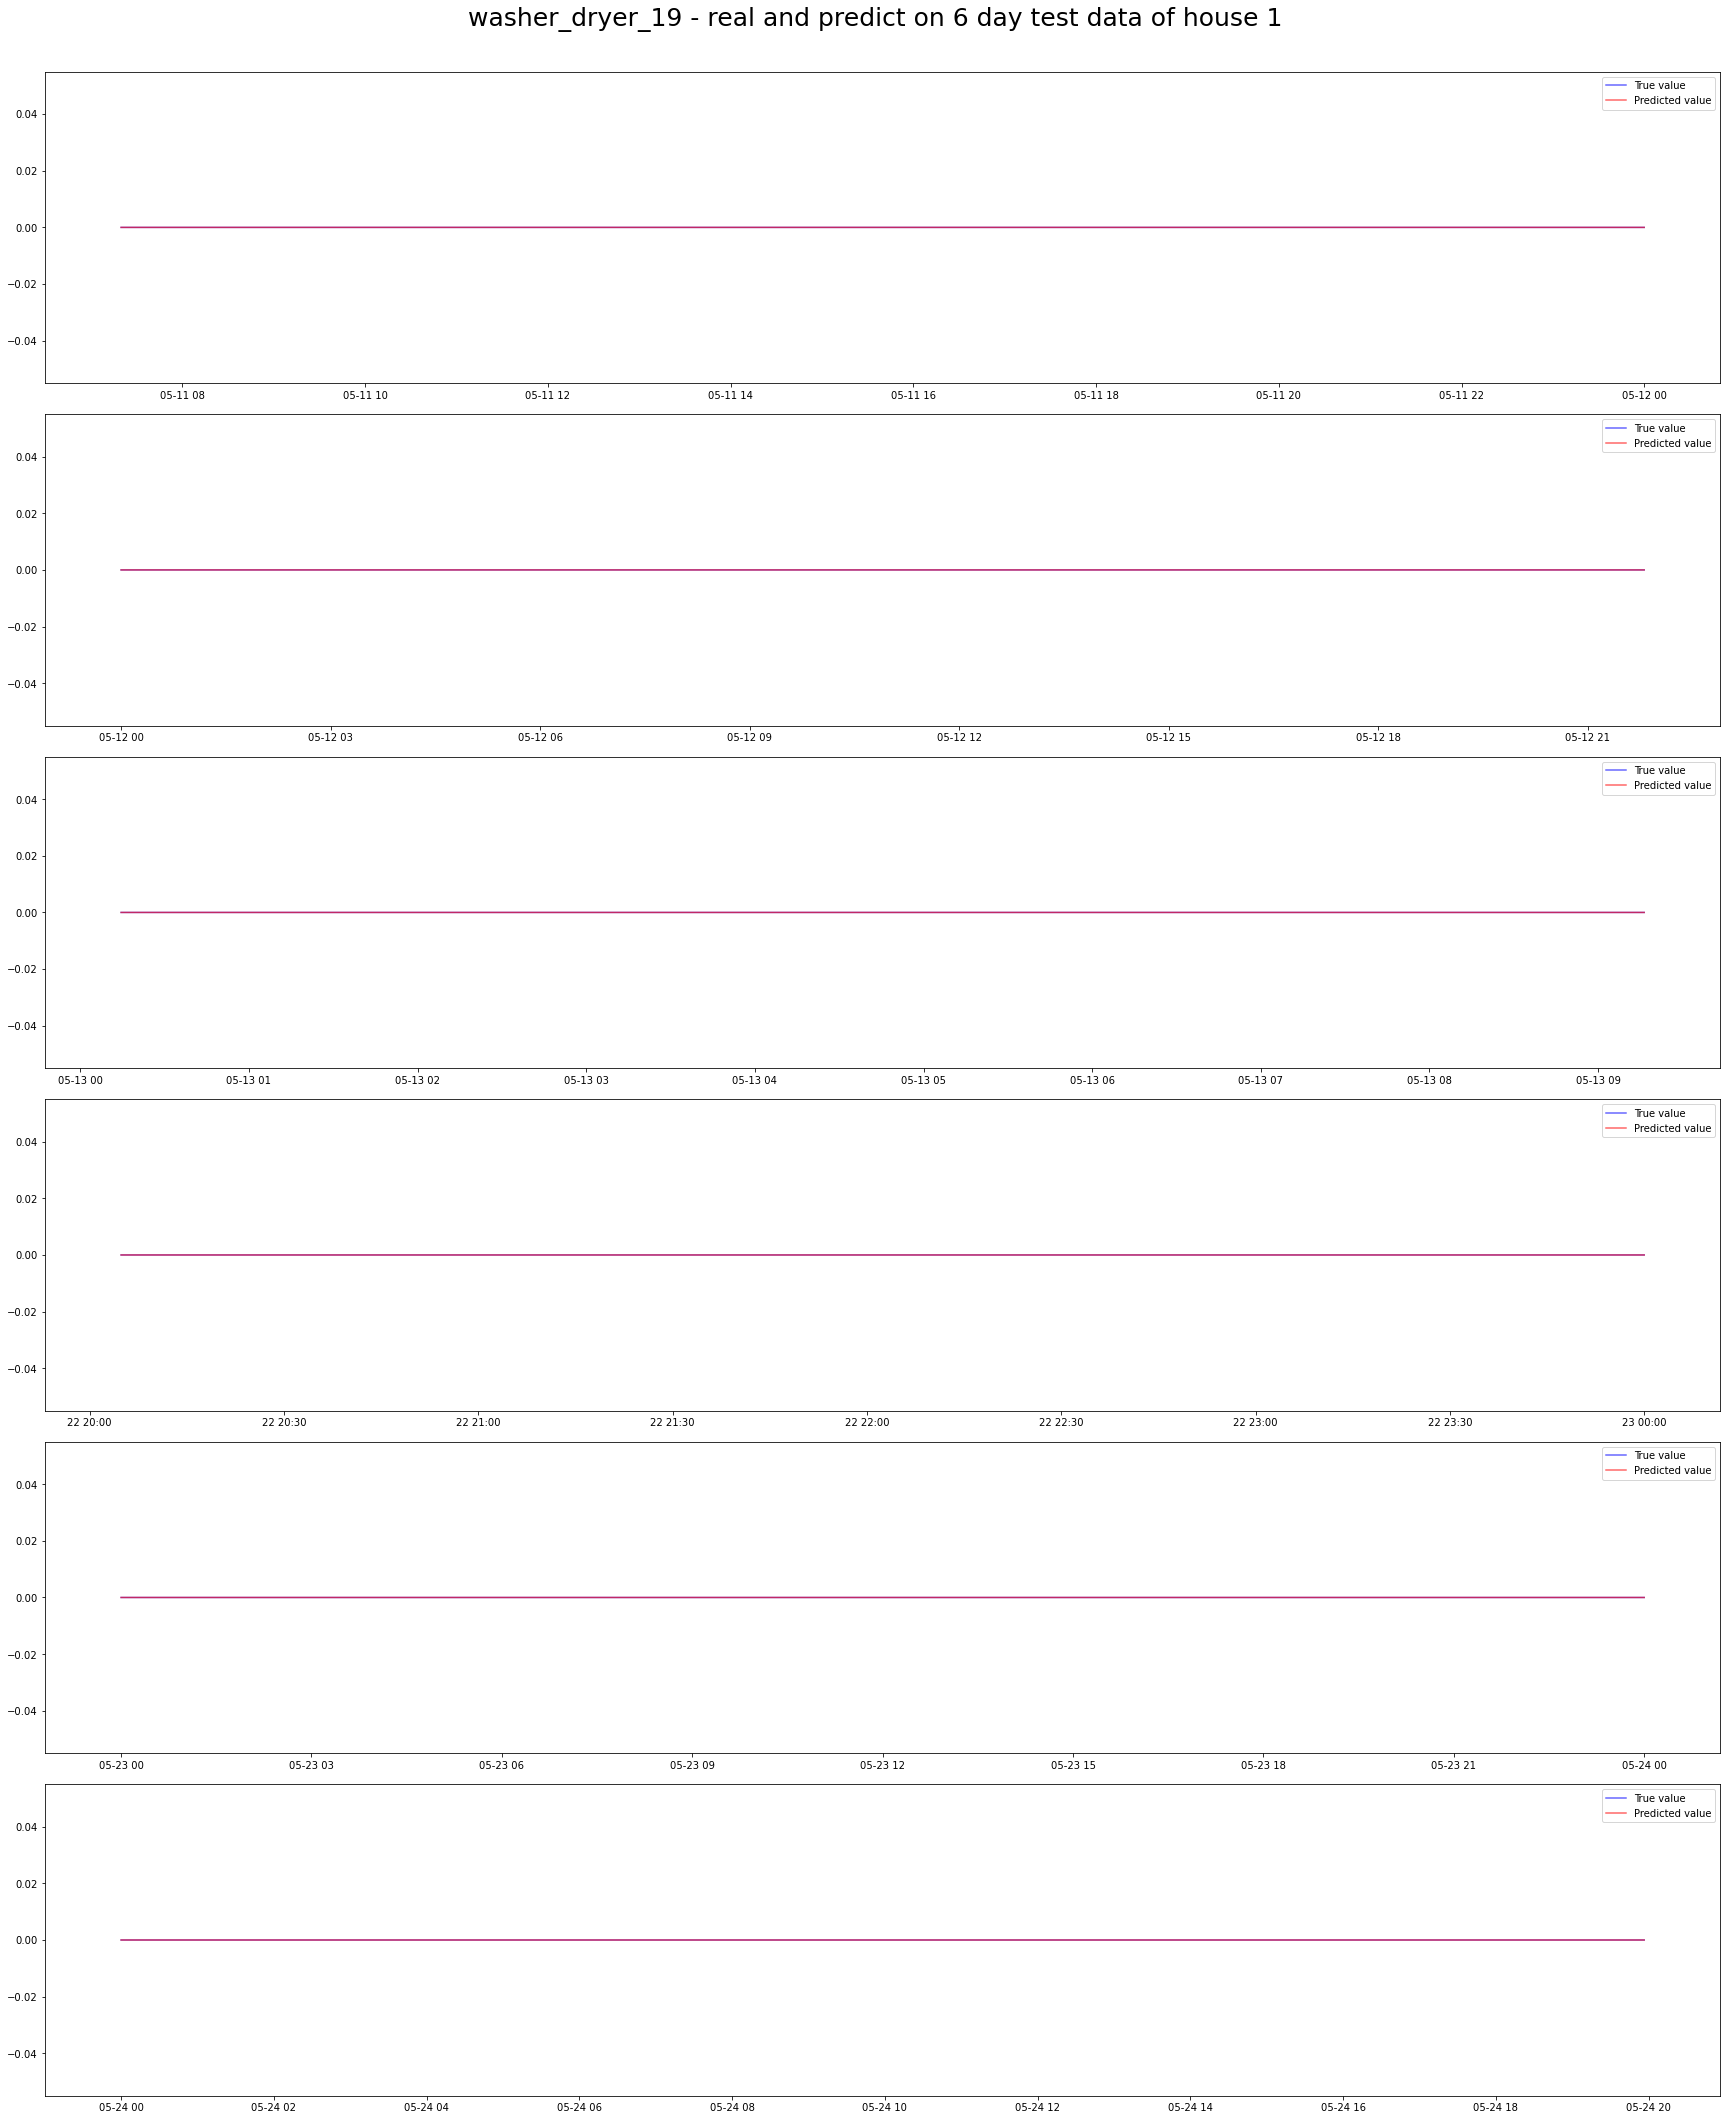

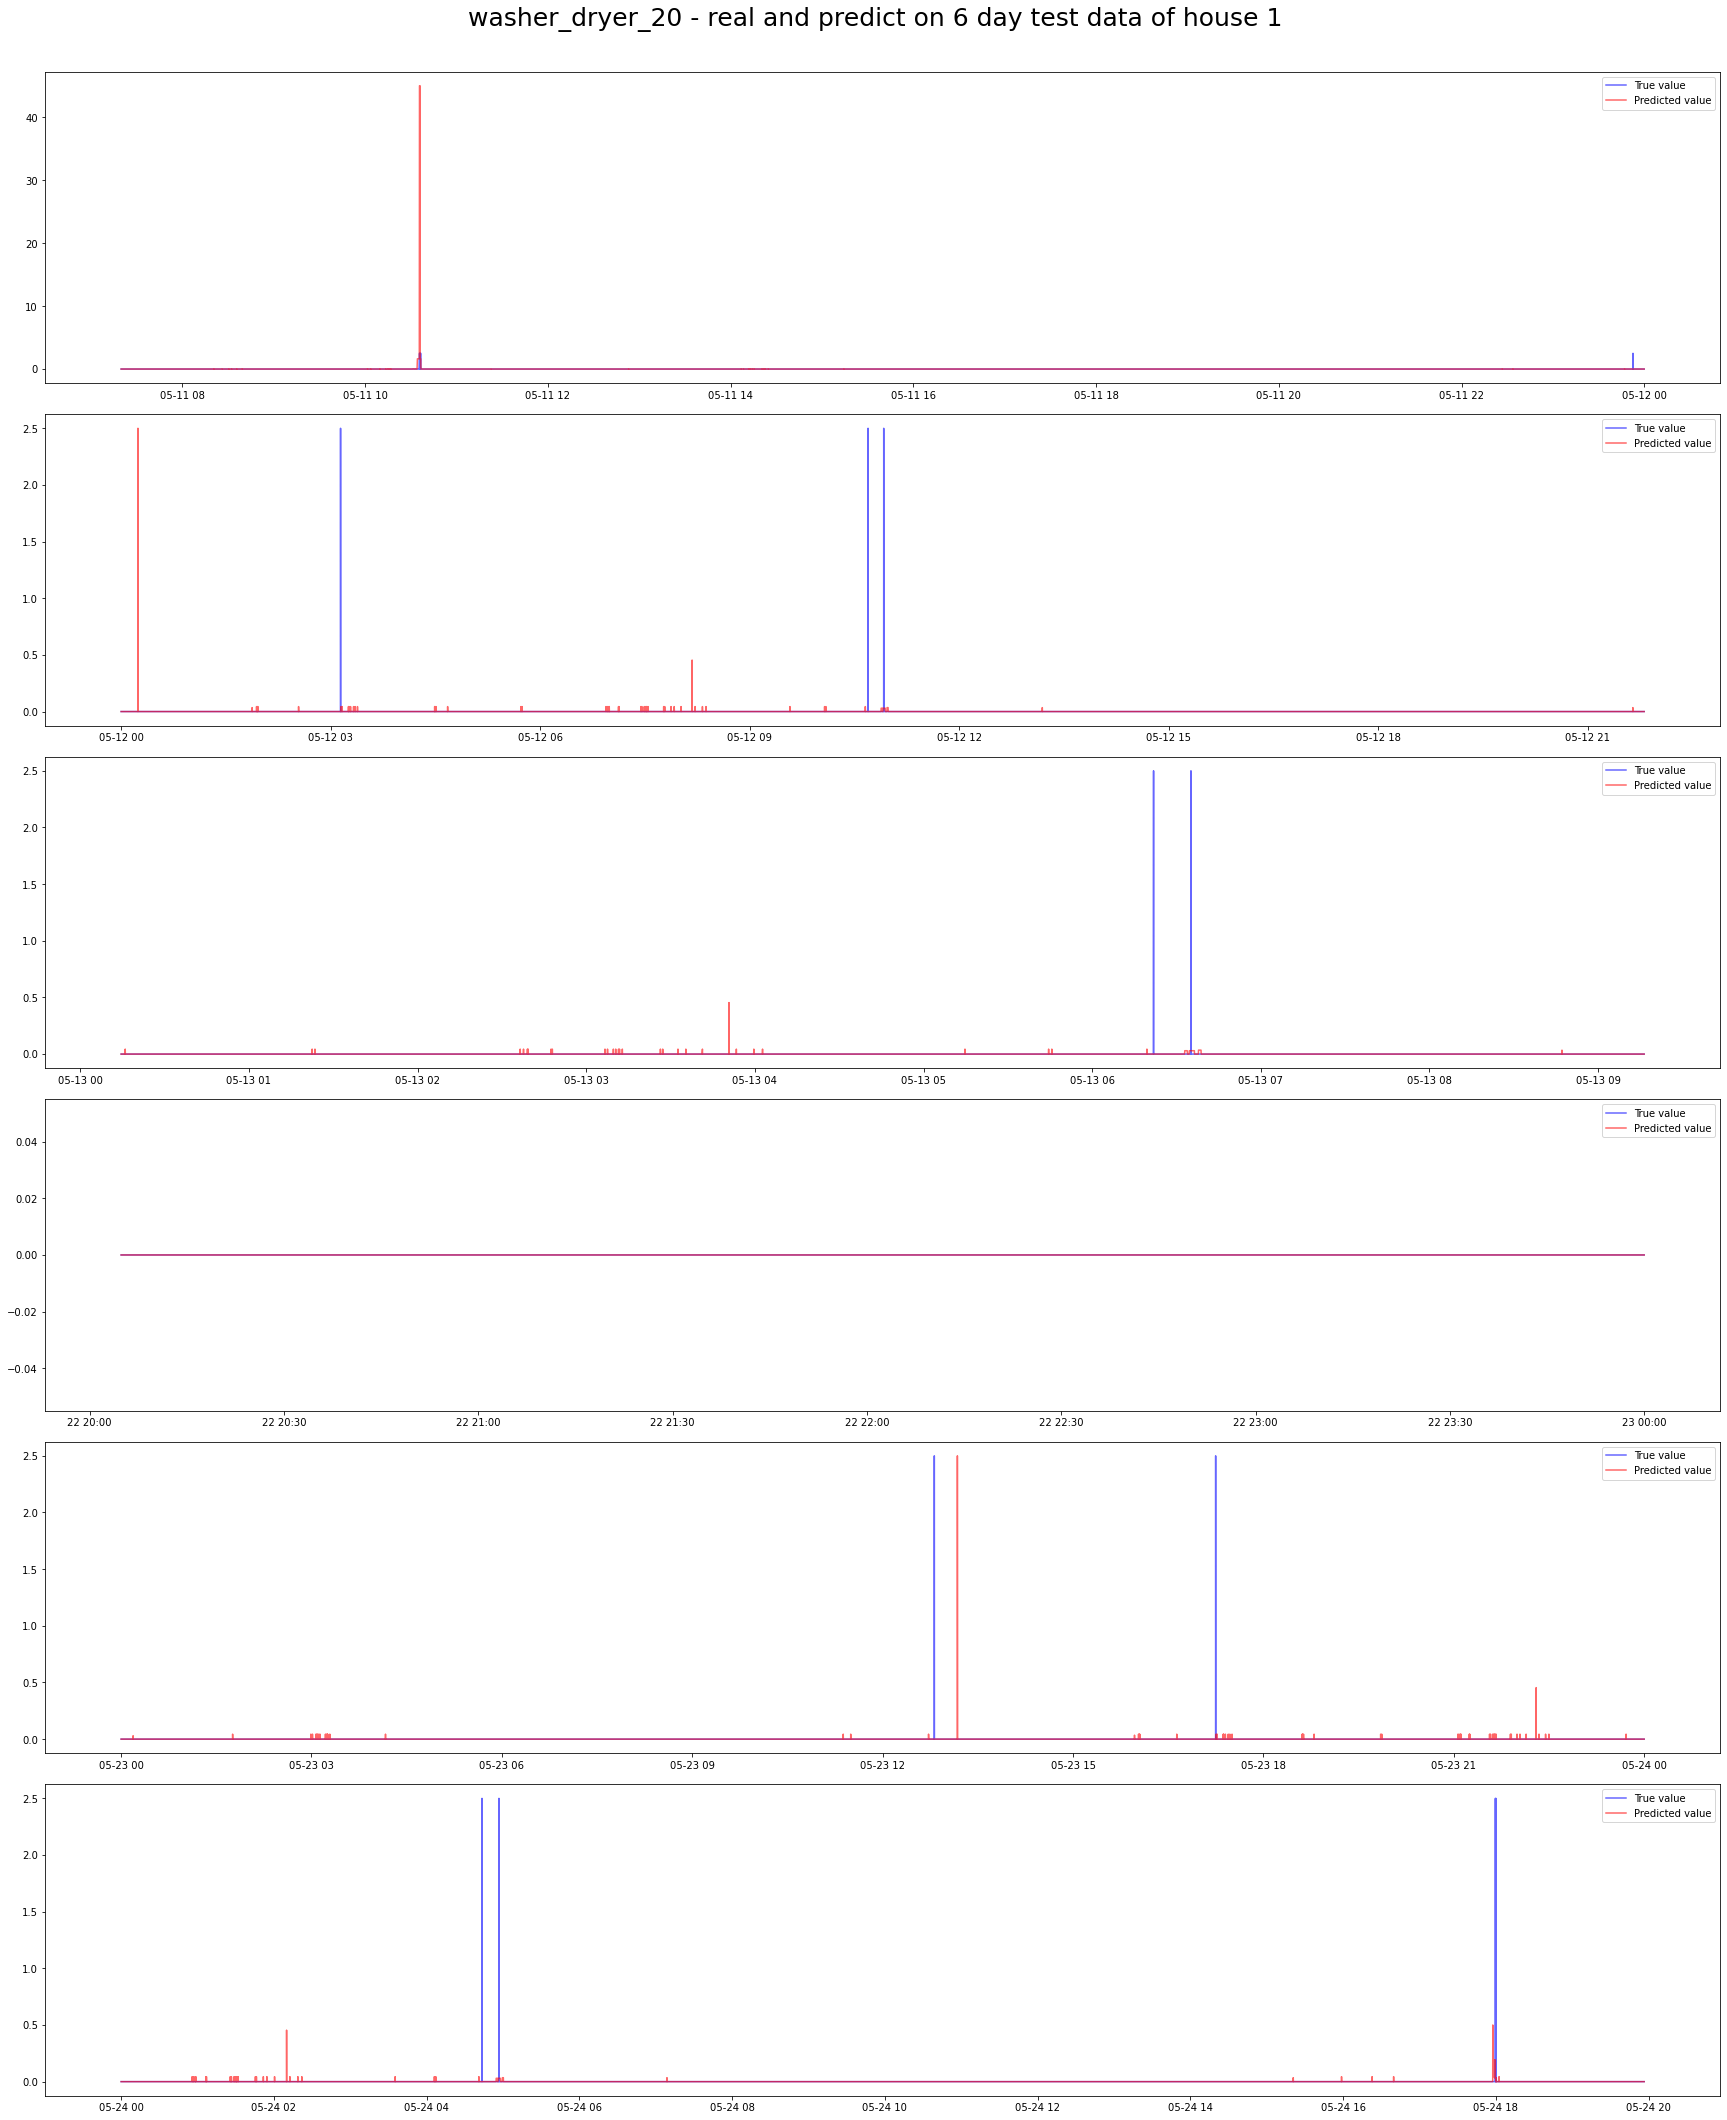

In [23]:
for app in appliances:
    plot_each_app(df1_test, dates[1][17:], mul_pred[app], df1_test[app].values, 
                  '{} - real and predict on 6 day test data of house 1'.format(app))

### Now, let's try fully connected neural network
#### For faster implementation, we use keras API with TensorFlow backend 

In [31]:
from keras.layers.core import Dense, Activation, Dropout
from keras.layers import LSTM
from keras.models import Sequential
from keras.callbacks import ModelCheckpoint
from keras.models import load_model
from keras.optimizers import Adam
from keras.regularizers import l2
from keras import Input

In [34]:
def build_fc_model(layers):
    fc_model = Sequential()
    for i in range(len(layers)-1):
        fc_model.add( Dense(input_dim=layers[i], units= layers[i+1]) )#, W_regularizer=l2(0.1)) )
        fc_model.add( Dropout(0.5) )
        if i < (len(layers) - 2):
            fc_model.add( Activation('relu') )
    fc_model.summary()
    return fc_model
fc_model_1 = build_fc_model([2, 256, 512, 1024, 1])

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 256)               768       
                                                                 
 dropout_4 (Dropout)         (None, 256)               0         
                                                                 
 activation_3 (Activation)   (None, 256)               0         
                                                                 
 dense_5 (Dense)             (None, 512)               131584    
                                                                 
 dropout_5 (Dropout)         (None, 512)               0         
                                                                 
 activation_4 (Activation)   (None, 512)               0         
                                                                 
 dense_6 (Dense)             (None, 1024)             

In [37]:
adam = Adam(lr = 1e-5)
fc_model_1.compile(loss='mean_squared_error', optimizer=adam)
start = time.time()
checkpointer = ModelCheckpoint(filepath="./fc_refrig_h1_2.hdf5", verbose=0, save_best_only=True)
hist_fc_1 = fc_model_1.fit( X_train1, y_train1,
                    batch_size=512, verbose=1, epochs=200,
                    validation_split=0.33, callbacks=[checkpointer])
print('Finish trainning. Time: ', time.time() - start)

Epoch 1/200
282/282 [==============================] - 7s 23ms/step - loss: 13023.8379 - val_loss: 9424.8652
Epoch 2/200
282/282 [==============================] - 6s 22ms/step - loss: 12314.9268 - val_loss: 9435.0889
Epoch 3/200
282/282 [==============================] - 6s 23ms/step - loss: 11789.8838 - val_loss: 9497.8613
Epoch 4/200
282/282 [==============================] - 6s 22ms/step - loss: 11587.1299 - val_loss: 9469.3643
Epoch 5/200
282/282 [==============================] - 6s 23ms/step - loss: 11247.0244 - val_loss: 9461.4990
Epoch 6/200
282/282 [==============================] - 6s 23ms/step - loss: 11145.1279 - val_loss: 9664.1953
Epoch 7/200
282/282 [==============================] - 6s 23ms/step - loss: 10887.9121 - val_loss: 9580.6729
Epoch 8/200
282/282 [==============================] - 7s 24ms/step - loss: 10815.7236 - val_loss: 9678.2373
Epoch 9/200
282/282 [==============================] - 6s 23ms/step - loss: 10681.7197 - val_loss: 9759.9092
Epoch 10/200
282/28

In [38]:
fc_model_1 = load_model('fc_refrig_h1_2.hdf5')
pred_fc_1 = fc_model_1.predict(X_test1).reshape(-1)
mse_loss_fc_1 = mse_loss(pred_fc_1, y_test1)
mae_loss_fc_1 = mae_loss(pred_fc_1, y_test1)
print('Mean square error on test set: ', mse_loss_fc_1)
print('Mean absolute error on the test set: ', mae_loss_fc_1)


Mean square error on test set:  9547.460777800572
Mean absolute error on the test set:  51.03603324355812


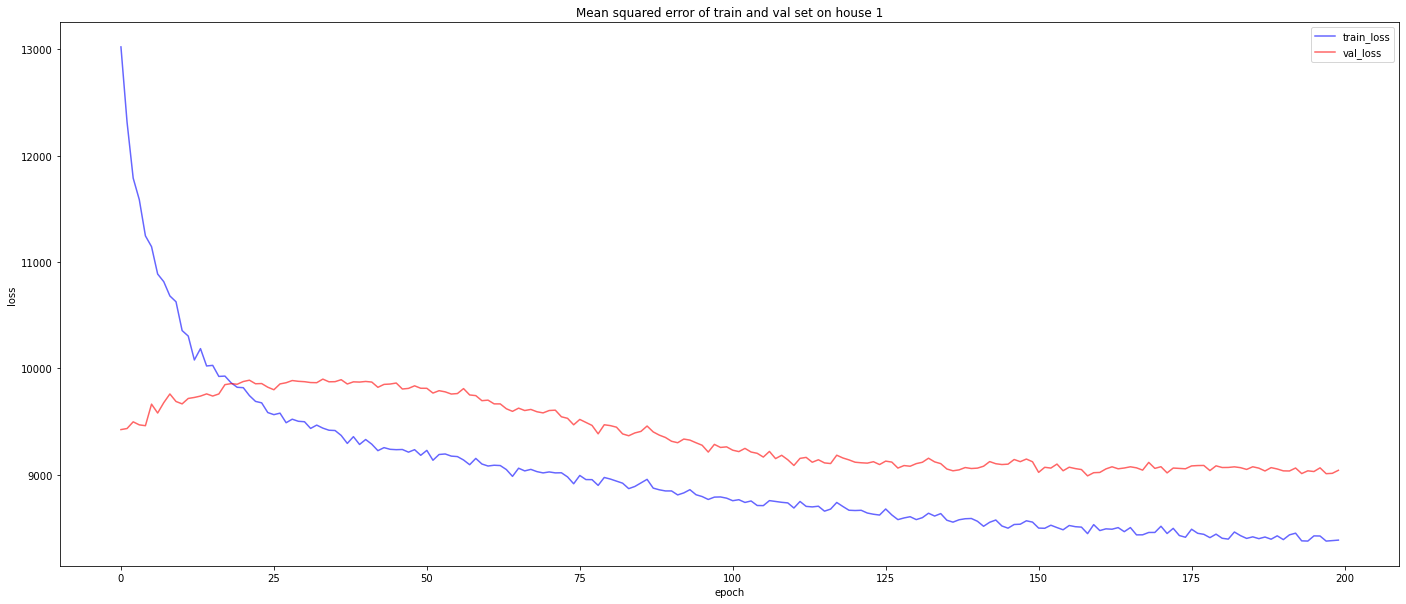

In [39]:
train_loss = hist_fc_1.history['loss']
val_loss = hist_fc_1.history['val_loss']
def plot_losses(train_loss, val_loss):
    plt.rcParams["figure.figsize"] = [24,10]
    plt.title('Mean squared error of train and val set on house 1')
    plt.plot( range(len(train_loss)), train_loss, color = 'b', alpha = 0.6, label='train_loss' )
    plt.plot( range(len( val_loss )), val_loss, color = 'r', alpha = 0.6, label='val_loss' )
    plt.xlabel( 'epoch' )
    plt.ylabel( 'loss' )
    plt.legend()

plot_losses(train_loss, val_loss)

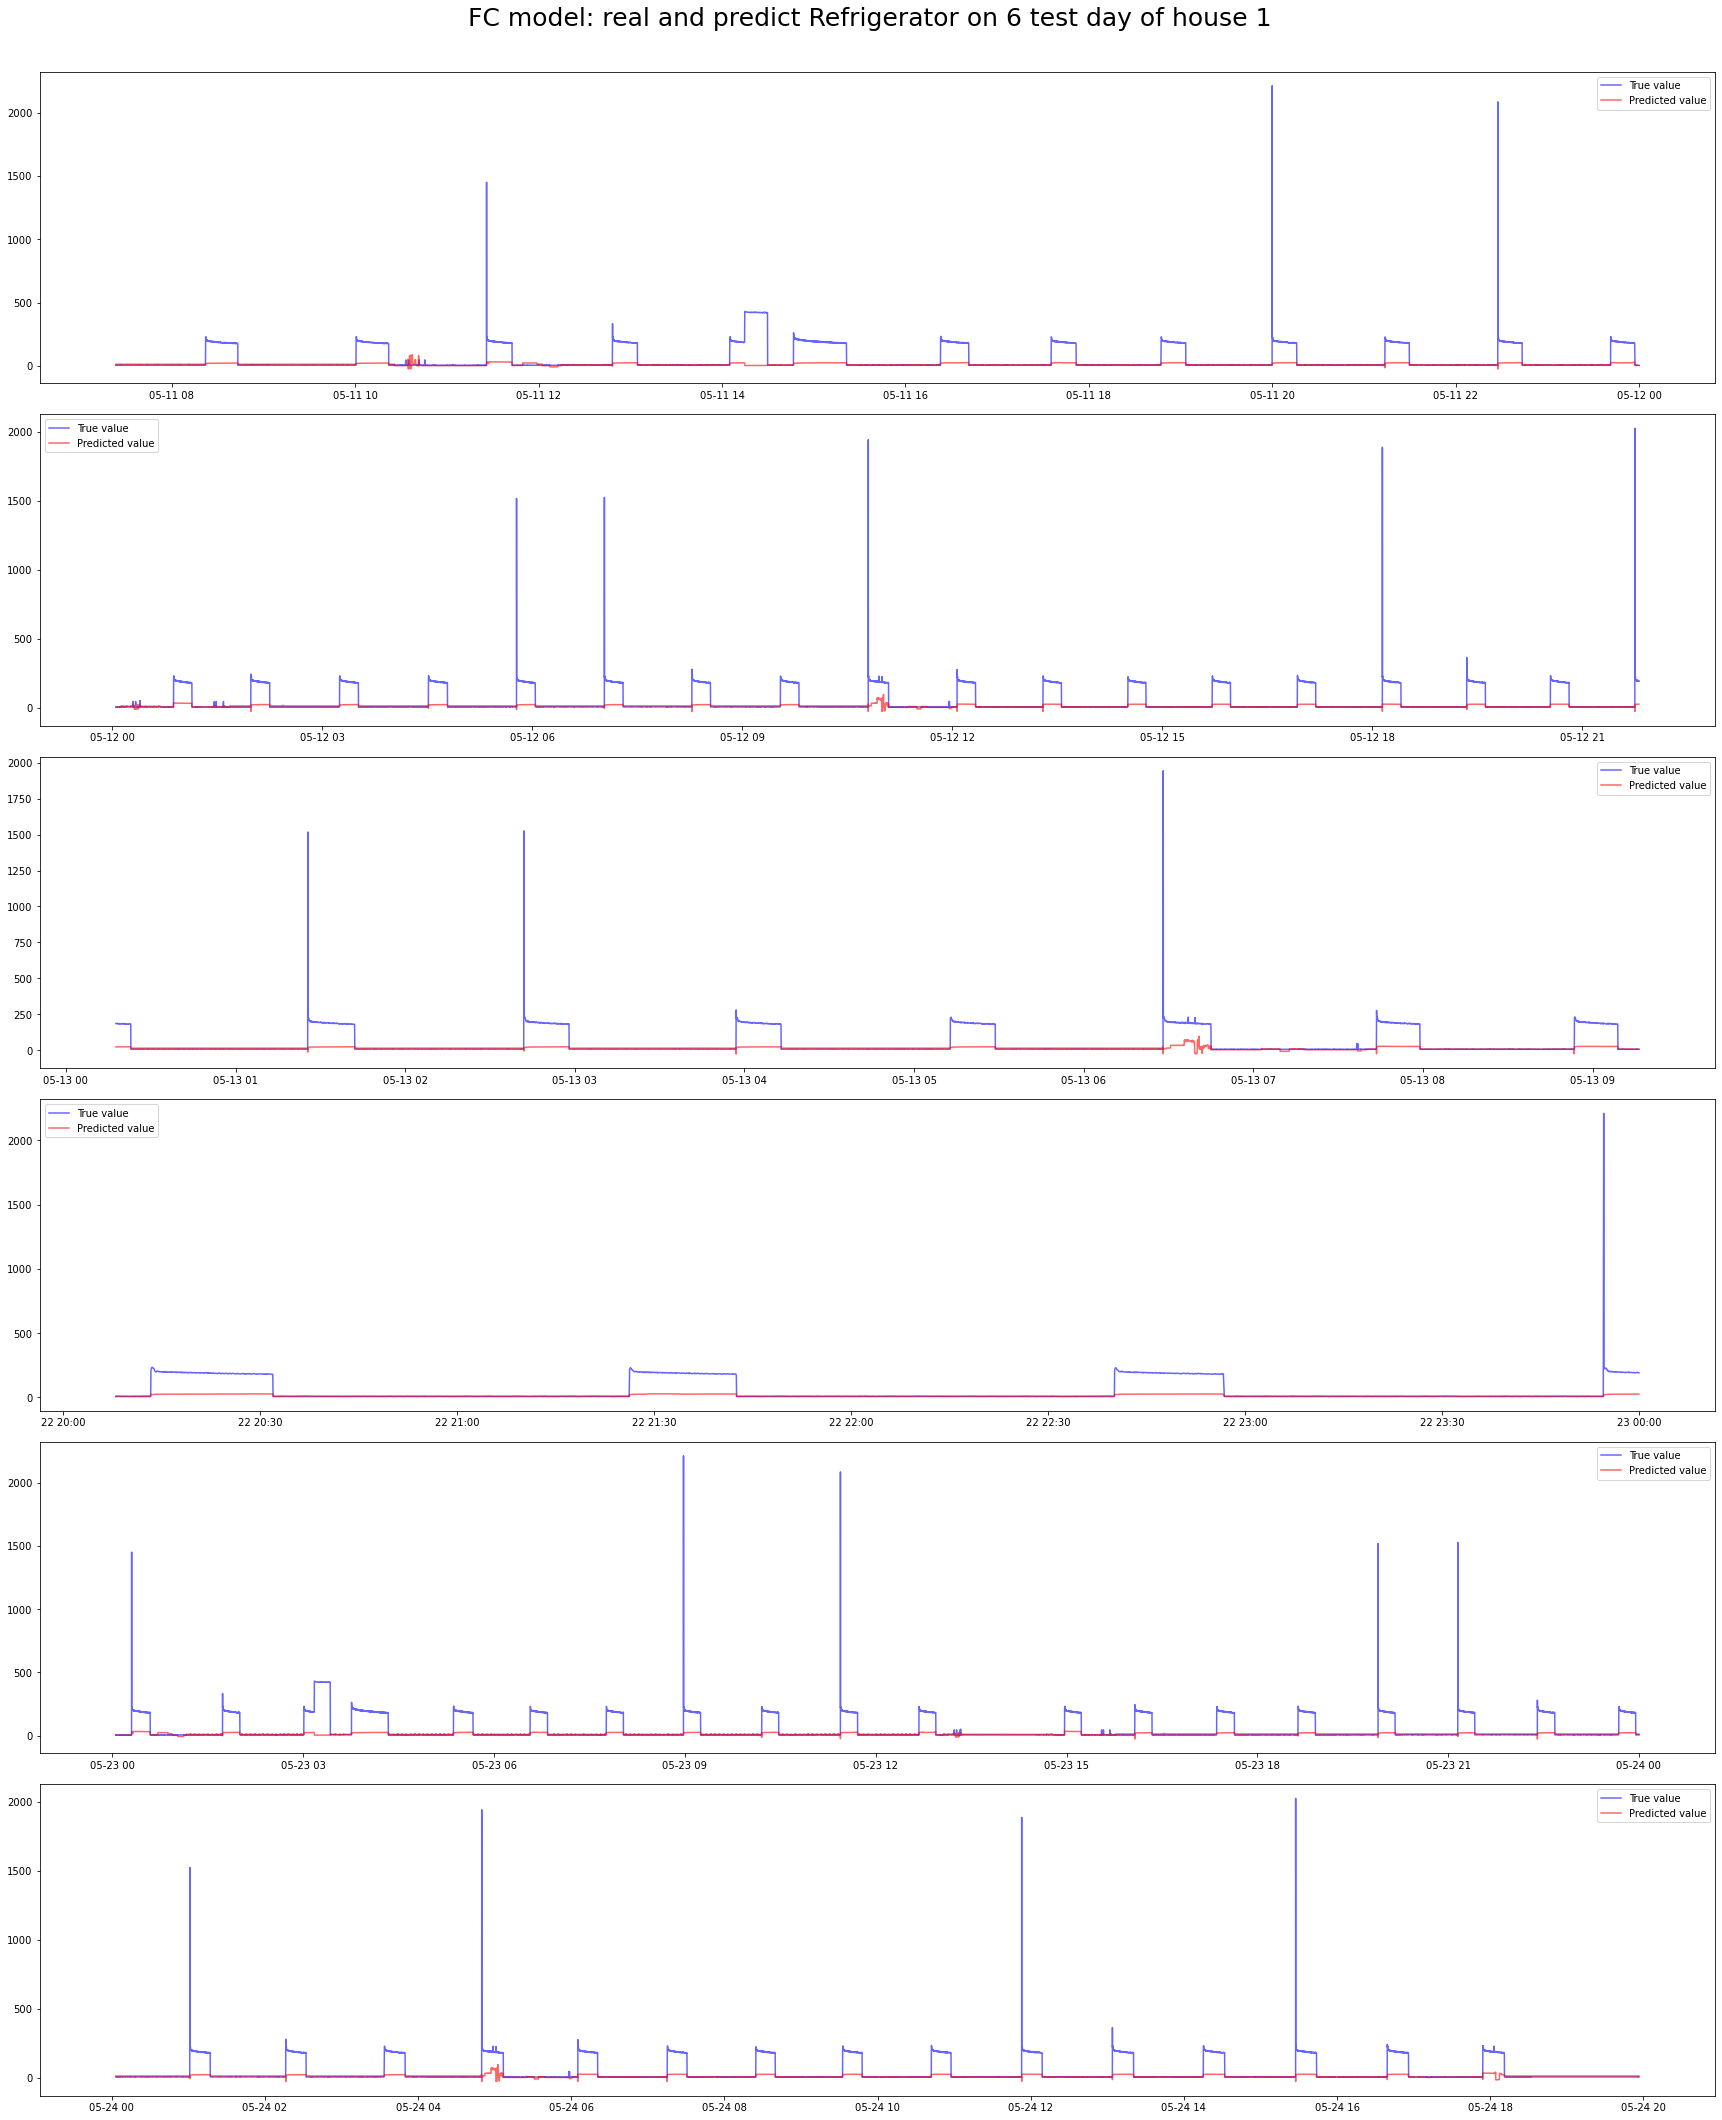

In [40]:
plot_each_app(df1_test, dates[1][17:], pred_fc_1, y_test1, 
              'FC model: real and predict Refrigerator on 6 test day of house 1', look_back = 50)

#### Use this model on house 2

In [41]:
y_pred_fc_2 = fc_model_1.predict(X_2).reshape(-1)
mse_fc_2 = mse_loss(y_pred_fc_2, y_2)
mae_fc_2 = mae_loss(y_pred_fc_2, y_2)
print('Mean square error on test set: ', mse_fc_2)
print('Mean absolute error on the test set: ', mae_fc_2)

Mean square error on test set:  13273.62885051714
Mean absolute error on the test set:  75.48050889805394


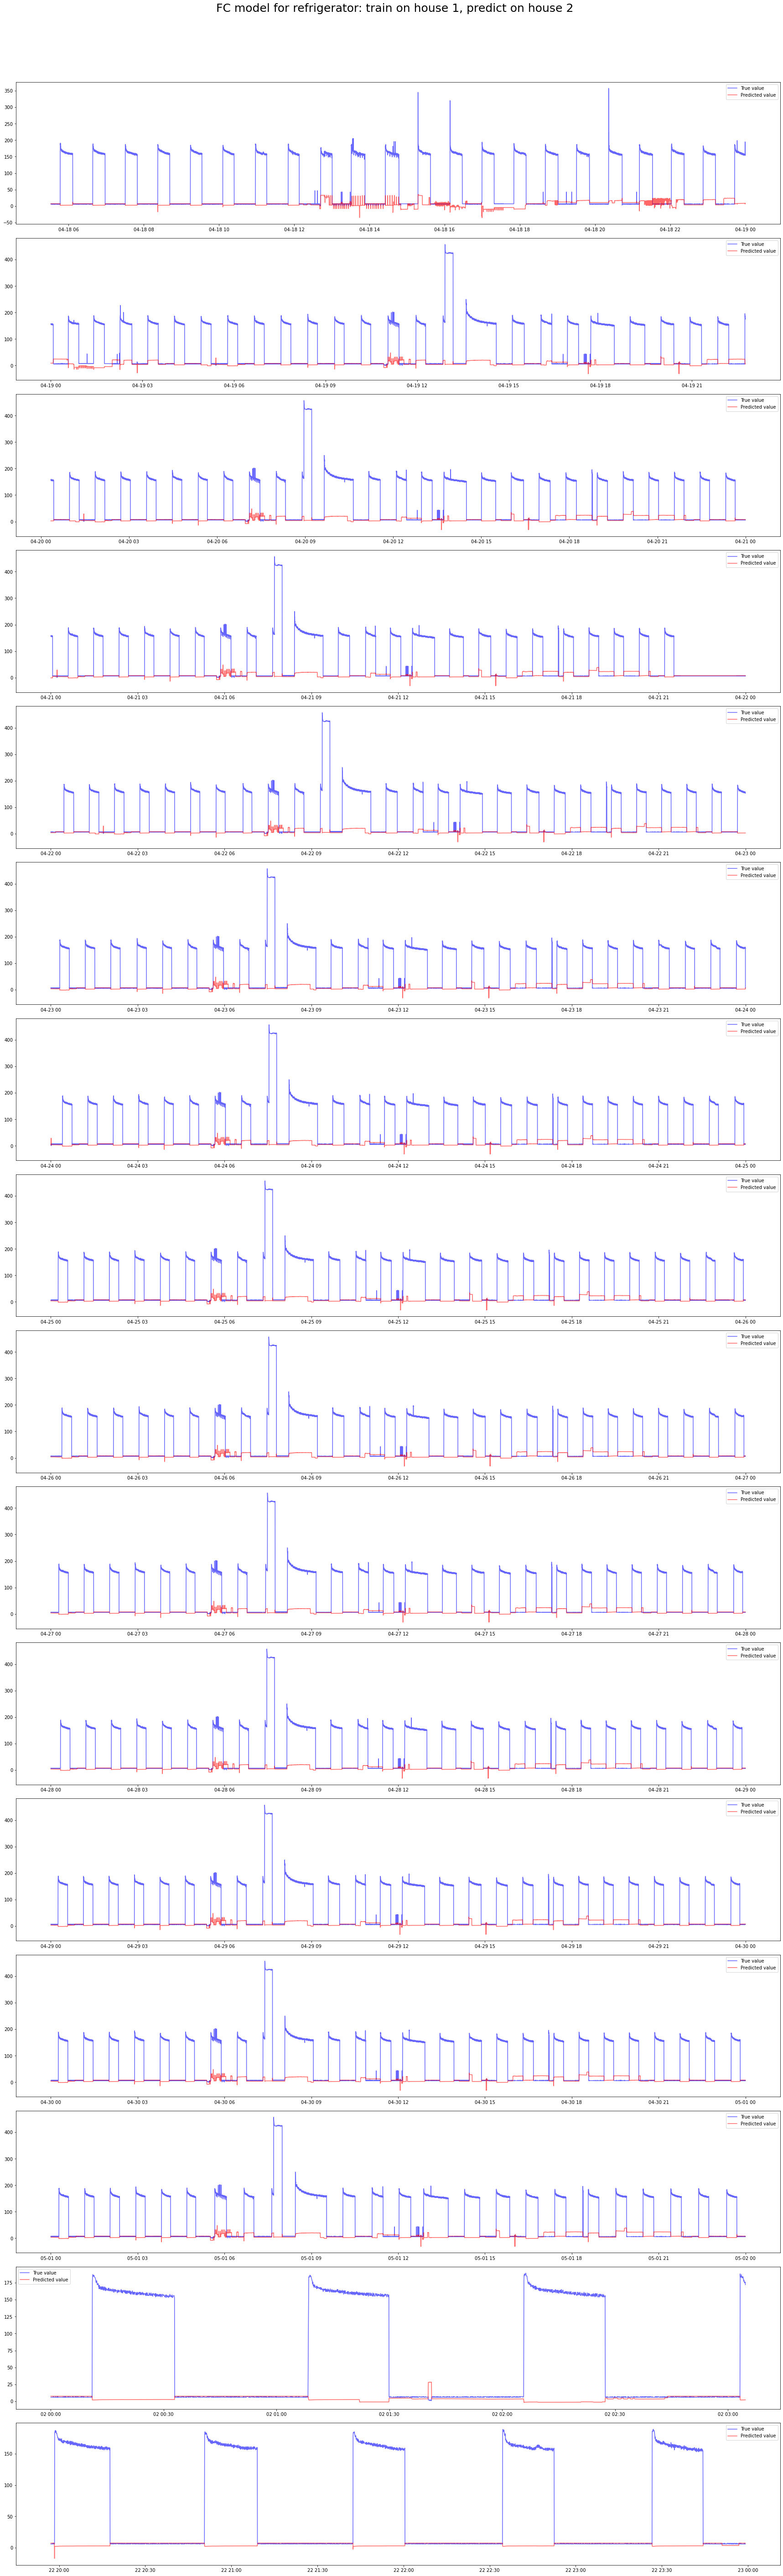

In [42]:
plot_each_app(df[2], dates[2], y_pred_fc_2, y_2, 'FC model for refrigerator: train on house 1, predict on house 2')

### Let's use 50 consecutive total consumtions to predict energy consumption of each appliance

In [46]:
def process_data(df, dates, x_features, y_features, look_back = 50):
    i = 0
    for date in dates:
        data = df.loc[date]
        len_data = data.shape[0]
        x = np.array([data[x_features].values[i:i+look_back] 
                      for i in range(len_data - look_back) ]).reshape(-1,look_back, 2)
        y = data[y_features].values[look_back:,:]
        if i == 0:
            X = x
            Y = y
        else:
            X = np.append(X, x, axis=0)
            Y = np.append(Y, y, axis=0)
        i += 1
    return X,Y

In [47]:
start = time.time()
X_train, y_train = process_data(df[1], dates[1][:17], ['mains_1','mains_2'], df[1].columns.values[2:])
X_test, y_test = process_data(df[1], dates[1][17:], ['mains_1','mains_2'], df[1].columns.values[2:])
print('Process data time: ', time.time() - start)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

Process data time:  244.19172477722168
(318841, 50, 2) (318841, 18) (86757, 50, 2) (86757, 18)


#### Let's use fully connected neural network again, but this time we use the past 50 consecutive main values to predict the present value of refrigerator


In [48]:
fc_model = build_fc_model([100, 256, 512, 1024, 1])

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8 (Dense)             (None, 256)               25856     
                                                                 
 dropout_8 (Dropout)         (None, 256)               0         
                                                                 
 activation_6 (Activation)   (None, 256)               0         
                                                                 
 dense_9 (Dense)             (None, 512)               131584    
                                                                 
 dropout_9 (Dropout)         (None, 512)               0         
                                                                 
 activation_7 (Activation)   (None, 512)               0         
                                                                 
 dense_10 (Dense)            (None, 1024)             

In [49]:
# Let's flatten data to feed into fc model
X_train_fc = X_train.reshape(-1, 100)
y_train_fc = y_train[:,2]
print(X_train_fc.shape, y_train_fc.shape)

(318841, 100) (318841,)


In [51]:
adam = Adam(lr = 1e-5)
fc_model.compile(loss='mean_squared_error', optimizer=adam)
start = time.time()
checkpointer = ModelCheckpoint(filepath="./fc_refrig_h1.hdf5", verbose=0, save_best_only=True)
hist_fc2 = fc_model.fit( X_train_fc, y_train_fc,
                    batch_size=512, verbose=1, epochs= 200,
                    validation_split=0.33, callbacks=[checkpointer])
print('Finish trainning. Time: ', time.time() - start)

Epoch 1/200
418/418 [==============================] - 11s 25ms/step - loss: 96617.7578 - val_loss: 14126.5244
Epoch 2/200
418/418 [==============================] - 9s 22ms/step - loss: 72062.9062 - val_loss: 12983.4951
Epoch 3/200
418/418 [==============================] - 9s 23ms/step - loss: 56307.6719 - val_loss: 12399.9971
Epoch 4/200
418/418 [==============================] - 10s 23ms/step - loss: 47614.4531 - val_loss: 11141.0264
Epoch 5/200
418/418 [==============================] - 10s 24ms/step - loss: 40504.0820 - val_loss: 10857.9033
Epoch 6/200
418/418 [==============================] - 10s 23ms/step - loss: 33301.1367 - val_loss: 9866.9473
Epoch 7/200
418/418 [==============================] - 10s 24ms/step - loss: 30816.4082 - val_loss: 9944.7598
Epoch 8/200
418/418 [==============================] - 10s 24ms/step - loss: 26466.4355 - val_loss: 9762.2744
Epoch 9/200
418/418 [==============================] - 10s 24ms/step - loss: 23270.5996 - val_loss: 9372.8135
Epoch 1

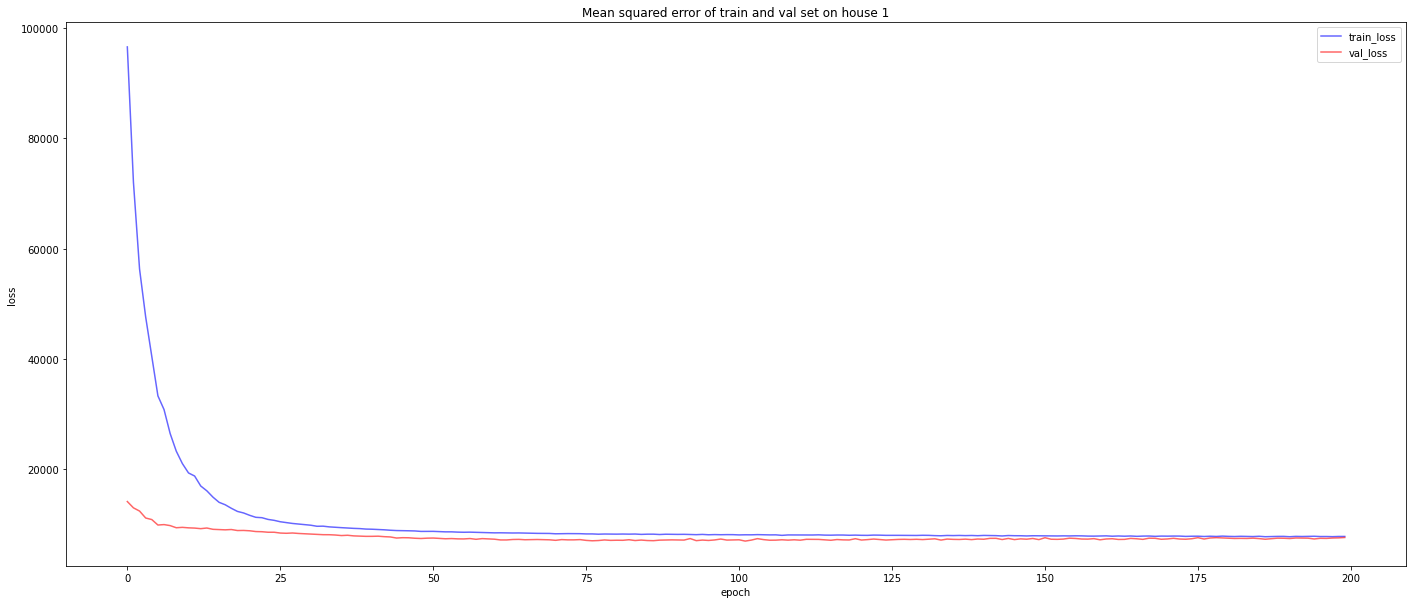

In [52]:
train_loss = hist_fc2.history['loss']
val_loss = hist_fc2.history['val_loss']

plot_losses(train_loss, val_loss)

In [53]:
fc_model = load_model('fc_refrig_h1.hdf5')
pred_fc = fc_model.predict(X_test.reshape(-1, 100)).reshape(-1)
print(pred_fc.shape)

(86757,)


In [54]:
mse_loss_fc = mse_loss(pred_fc, y_test[:,2])
mae_loss_fc = mae_loss(pred_fc, y_test[:,2])
print('Mean square error on test set: ', mse_loss_fc)
print('Mean absolute error on the test set: ', mae_loss_fc)

Mean square error on test set:  8003.087442168482
Mean absolute error on the test set:  45.94820737979277


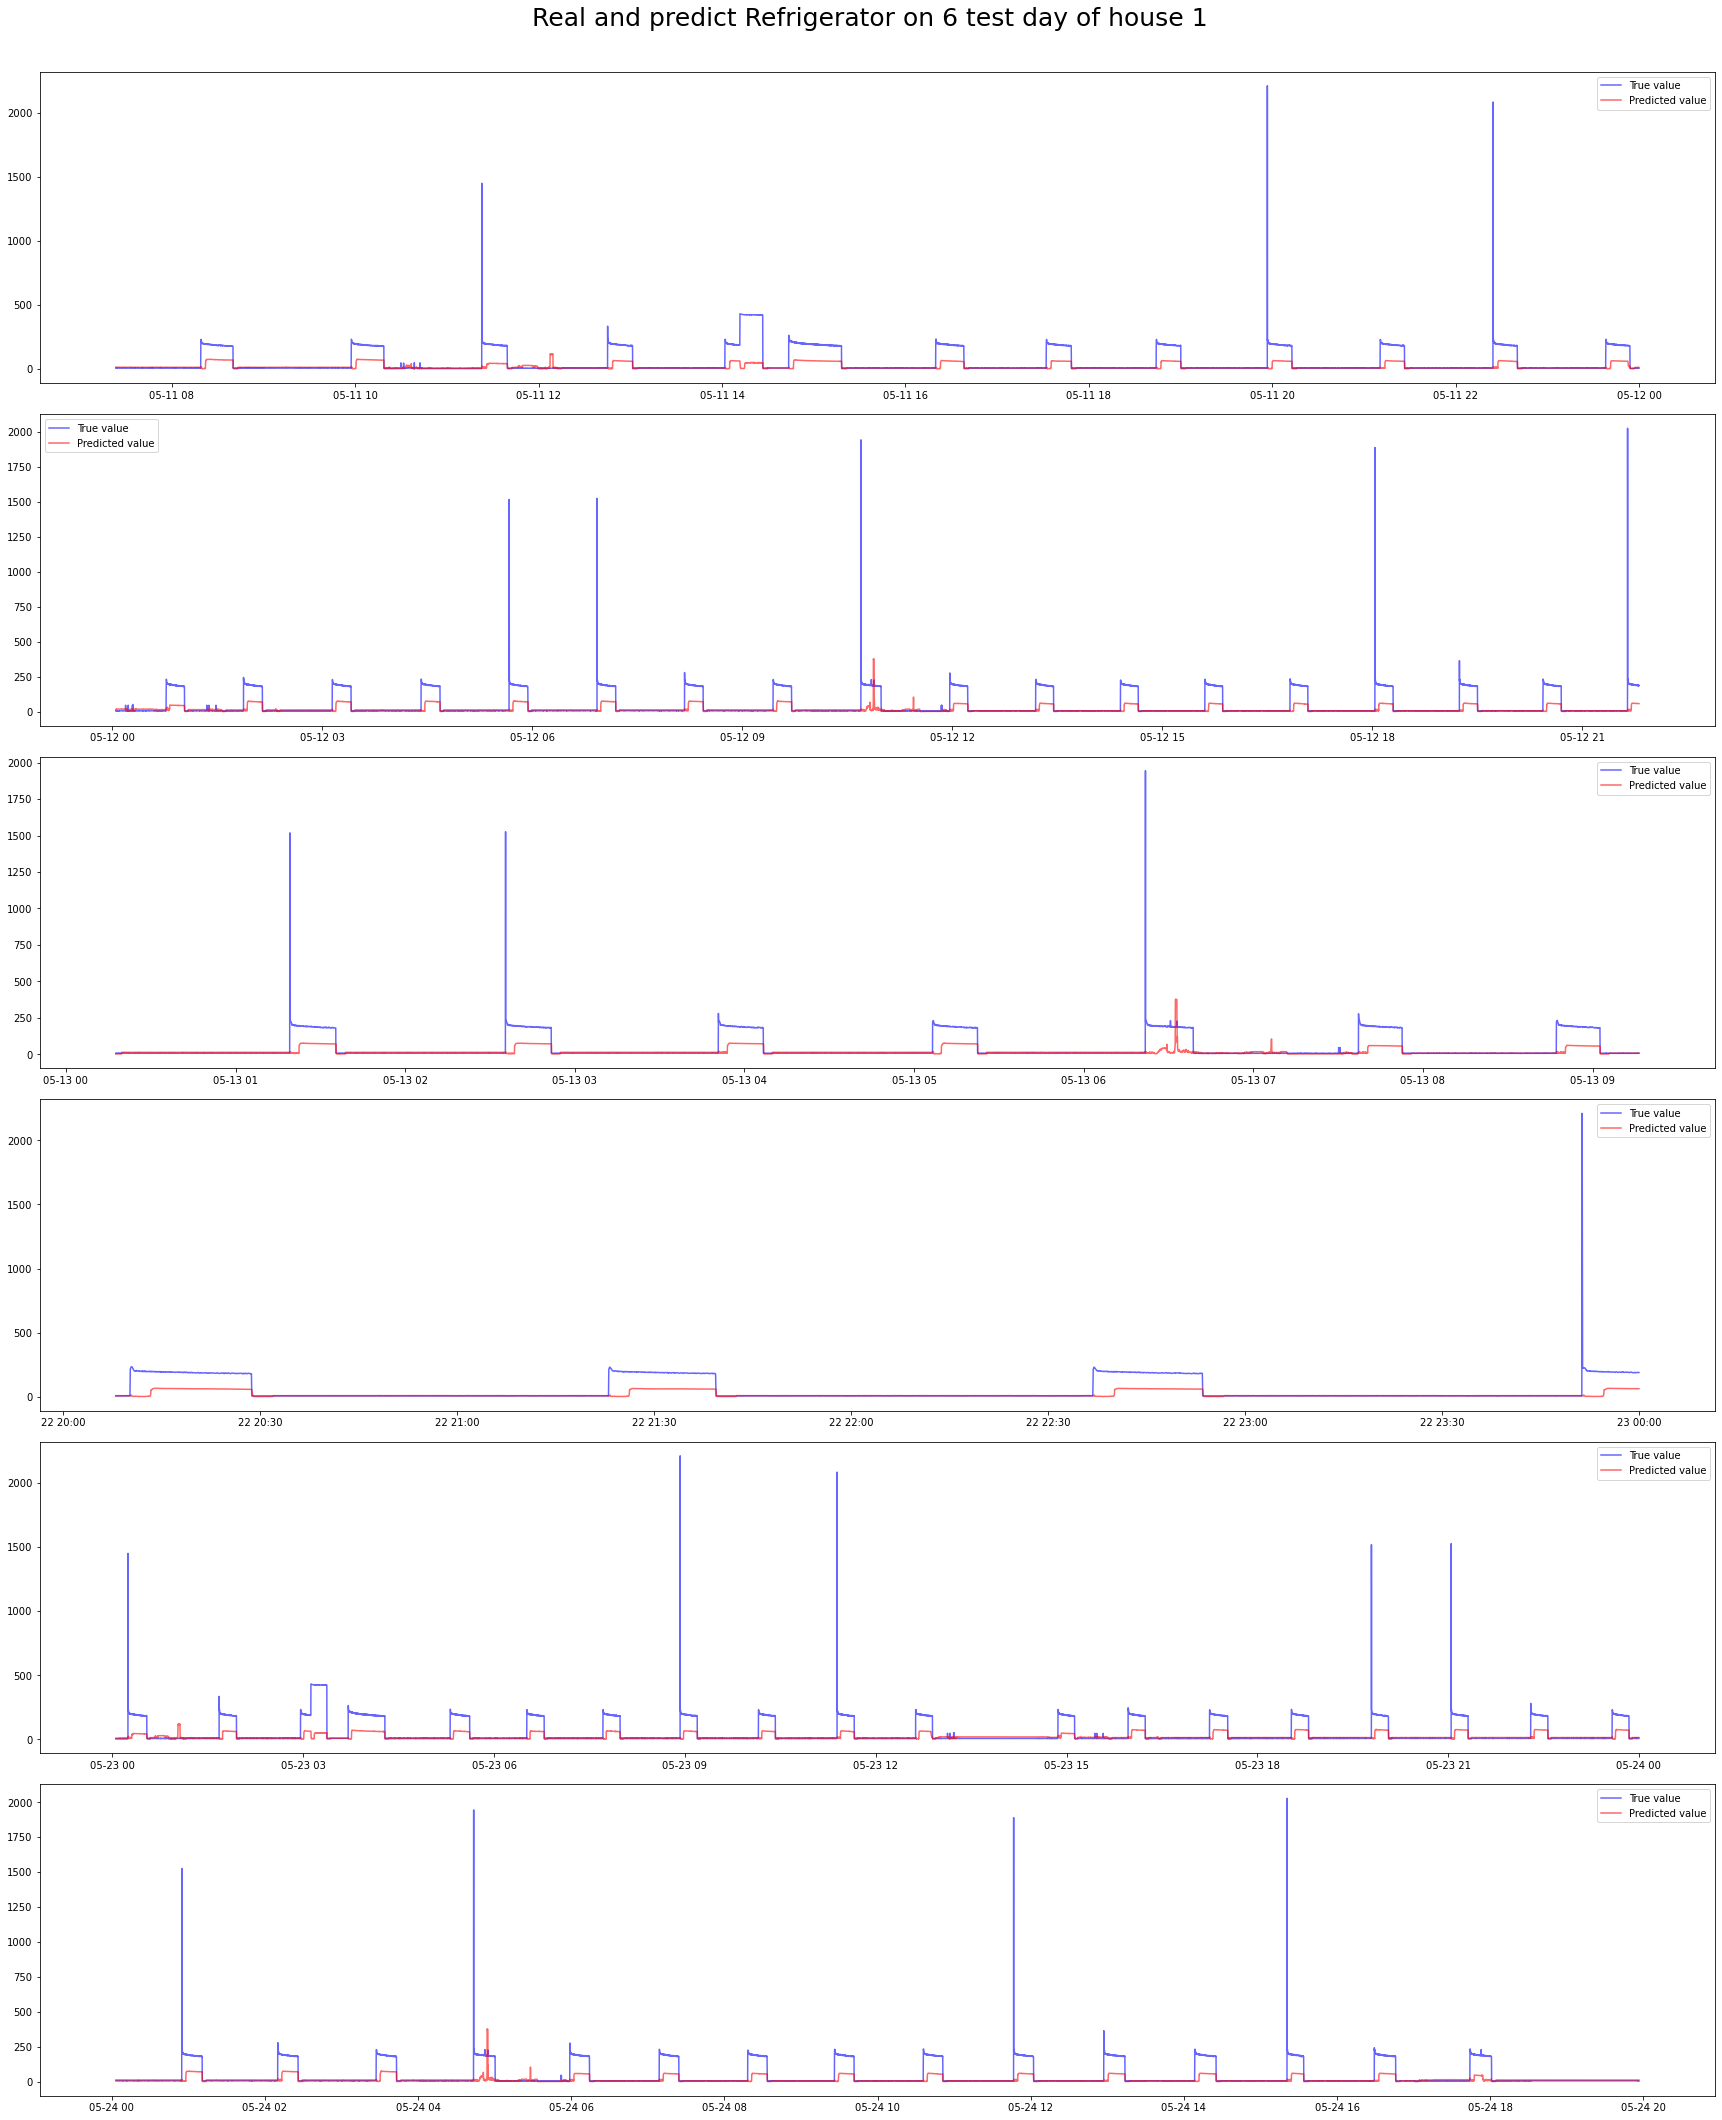

In [55]:
plot_each_app(df1_test, dates[1][17:], pred_fc, y_test[:,2], 
              'Real and predict Refrigerator on 6 test day of house 1', look_back = 50)

#### Test on house 2

In [56]:
start = time.time()
X_2, y_2 = process_data(df[2], dates[2], ['mains_2','mains_1'], ['refrigerator_9'])
X_2_fc = X_2.reshape(-1, 100)
y_2 = y_2.reshape(-1)
print('Process data time: ', time.time() - start)
print(X_2_fc.shape, y_2.shape)

Process data time:  358.27132296562195
(316040, 100) (316040,)


In [57]:
pred_fc_50_h2 = fc_model.predict(X_2_fc).reshape(-1)
mse_loss_fc_50_2 = mse_loss(pred_fc_50_h2, y_2)
mae_loss_fc_50_2 = mae_loss(pred_fc_50_h2, y_2)
print('Mean square error on test set: ', mse_loss_fc_50_2)
print('Mean absolute error on the test set: ', mae_loss_fc_50_2)

Mean square error on test set:  11592.11957832889
Mean absolute error on the test set:  70.2161855478637


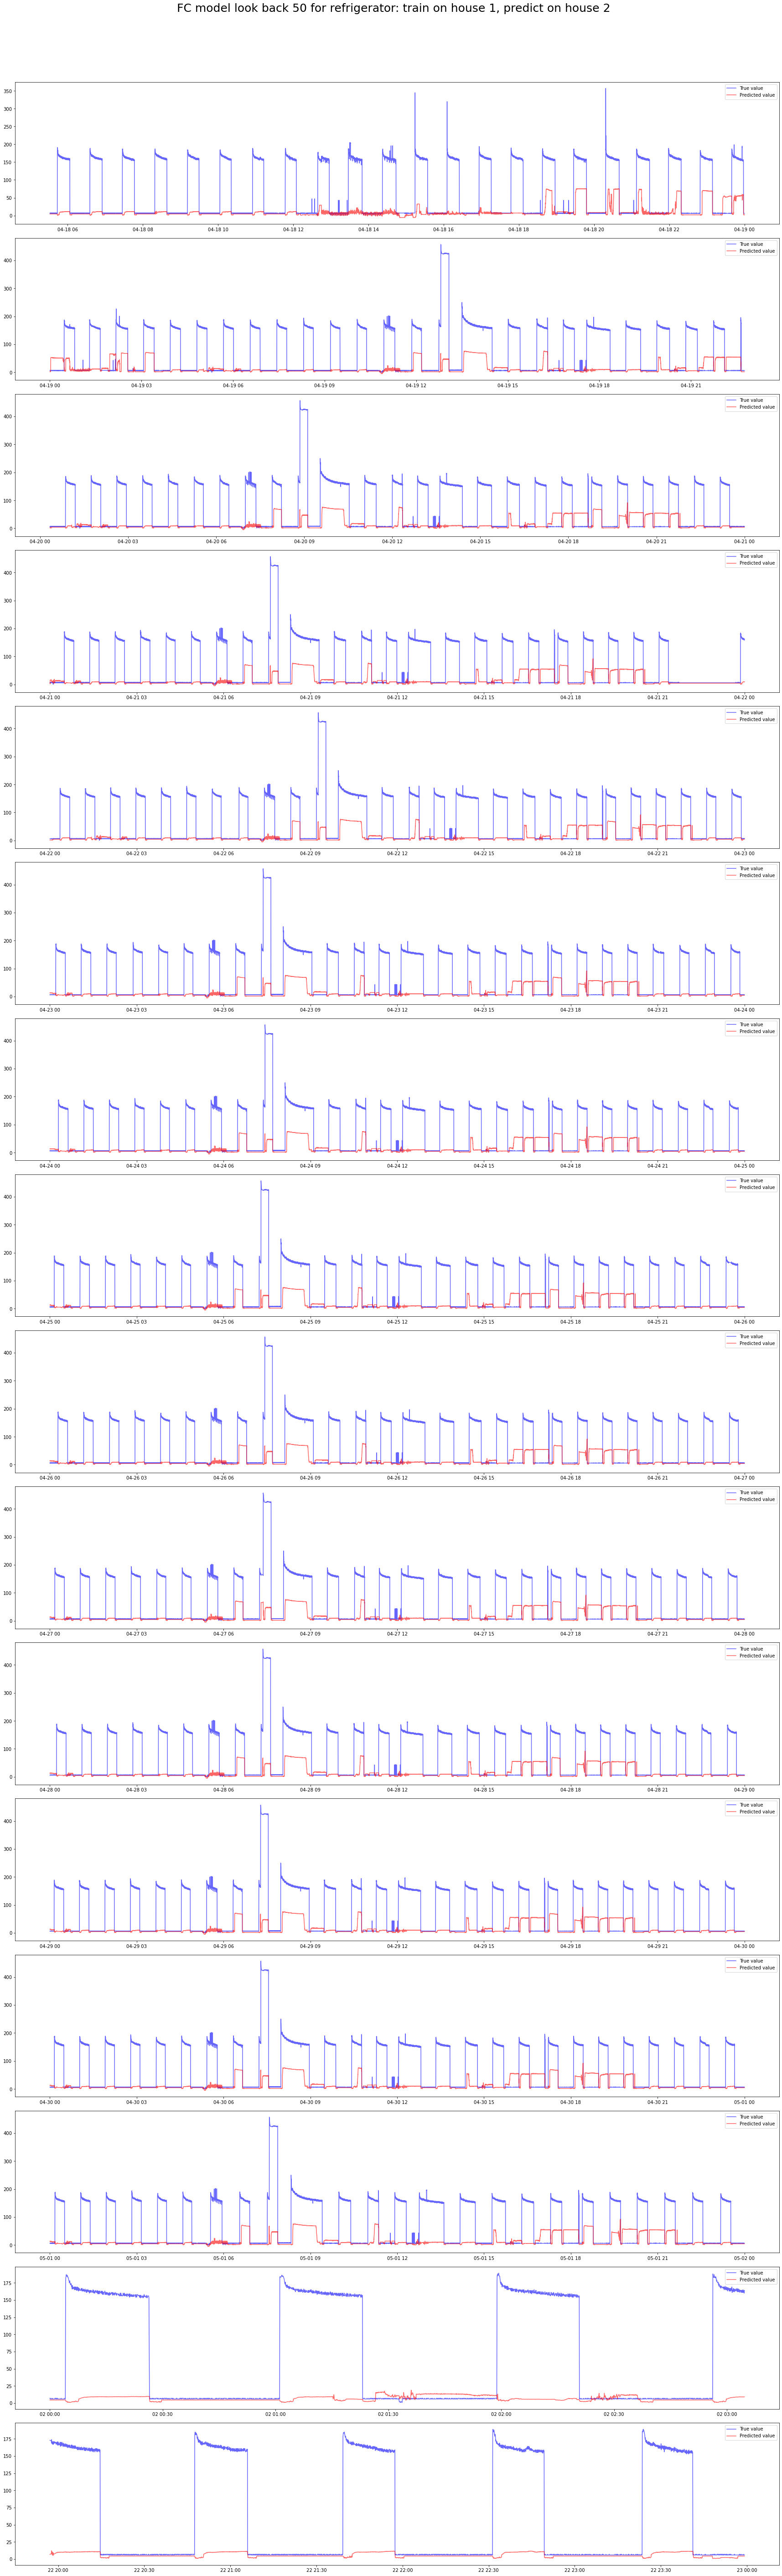

In [58]:
plot_each_app(df[2], dates[2], pred_fc_50_h2, y_2, 'FC model look back 50 for refrigerator: train on house 1, predict on house 2')

### Long term short term memory neural network
#### Now we will try a type of recurrent neural network called long term short term memory model

In [59]:
def build_lstm_model(layers):
    model = Sequential()
    for i in range(len(layers) - 2):
        model.add(LSTM(
            input_dim=layers[i],
            units=layers[i+1], 
            #stateful=True,
            return_sequences= True if i < len(layers) - 3 else False ))
        model.add(Dropout(0.3))
    
    model.add(Dense(layers[-1]))
    model.summary()
    return model

model = build_lstm_model([2,64,128,256, 1])

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 64)          17152     
                                                                 
 dropout_12 (Dropout)        (None, None, 64)          0         
                                                                 
 lstm_1 (LSTM)               (None, None, 128)         98816     
                                                                 
 dropout_13 (Dropout)        (None, None, 128)         0         
                                                                 
 lstm_2 (LSTM)               (None, 256)               394240    
                                                                 
 dropout_14 (Dropout)        (None, 256)               0         
                                                                 
 dense_12 (Dense)            (None, 1)                

In [65]:
start = time.time()

adam = Adam(lr = 5e-5)
model.compile(loss='mean_squared_error', optimizer=adam)
checkpointer = ModelCheckpoint(filepath="./lstm_model.hdf5", verbose=0, save_best_only=True)
hist_lstm = model.fit(
            X_train[:1000,:],
            y_train[:1000,2],
            batch_size=212,
            verbose=1,
            epochs=100,
            validation_split=0.3,
            callbacks=[checkpointer])
print('Finish trainning. Time: ', time.time() - start)

Epoch 1/100
4/4 [==============================] - 17s 3s/step - loss: 29.5536 - val_loss: 13079.2871
Epoch 2/100
4/4 [==============================] - 10s 2s/step - loss: 13.1615 - val_loss: 13759.5752
Epoch 3/100
4/4 [==============================] - 10s 2s/step - loss: 4.0986 - val_loss: 13969.2529
Epoch 4/100
4/4 [==============================] - 10s 2s/step - loss: 2.3156 - val_loss: 14036.6338
Epoch 5/100
4/4 [==============================] - 11s 3s/step - loss: 1.7543 - val_loss: 14036.0830
Epoch 6/100
4/4 [==============================] - 9s 2s/step - loss: 1.3069 - val_loss: 14005.5947
Epoch 7/100
4/4 [==============================] - 10s 2s/step - loss: 0.9880 - val_loss: 13967.6797
Epoch 8/100
4/4 [==============================] - 10s 2s/step - loss: 0.7602 - val_loss: 13936.9502
Epoch 9/100
4/4 [==============================] - 10s 2s/step - loss: 0.7568 - val_loss: 13922.7246
Epoch 10/100
4/4 [==============================] - 10s 3s/step - loss: 0.7458 - val_loss:

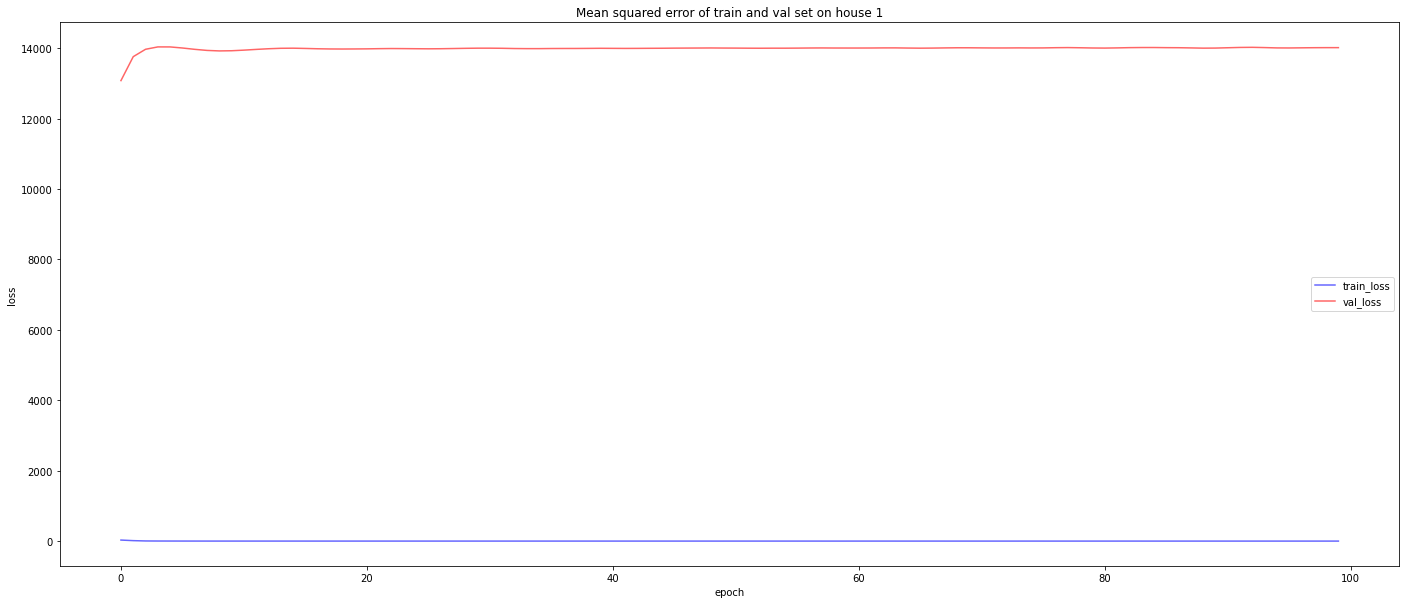

In [66]:
train_loss = hist_lstm.history['loss']
val_loss = hist_lstm.history['val_loss']

plot_losses(train_loss, val_loss)

In [67]:
model = load_model('lstm_model.hdf5')
pred_lstm = model.predict(X_test).reshape(-1)
print(pred_lstm.shape)

(86757,)


In [72]:
mse_loss_lstm = mse_loss(pred_lstm, y_test[:,2])
mae_loss_lstm = mae_loss(pred_lstm, y_test[:,2])
print('Mean square error on test set: ', mse_loss_lstm)
print('Mean absolute error on the test set: ', mae_loss_lstm)

Mean square error on test set:  11004.49979057033
Mean absolute error on the test set:  53.2351949446217


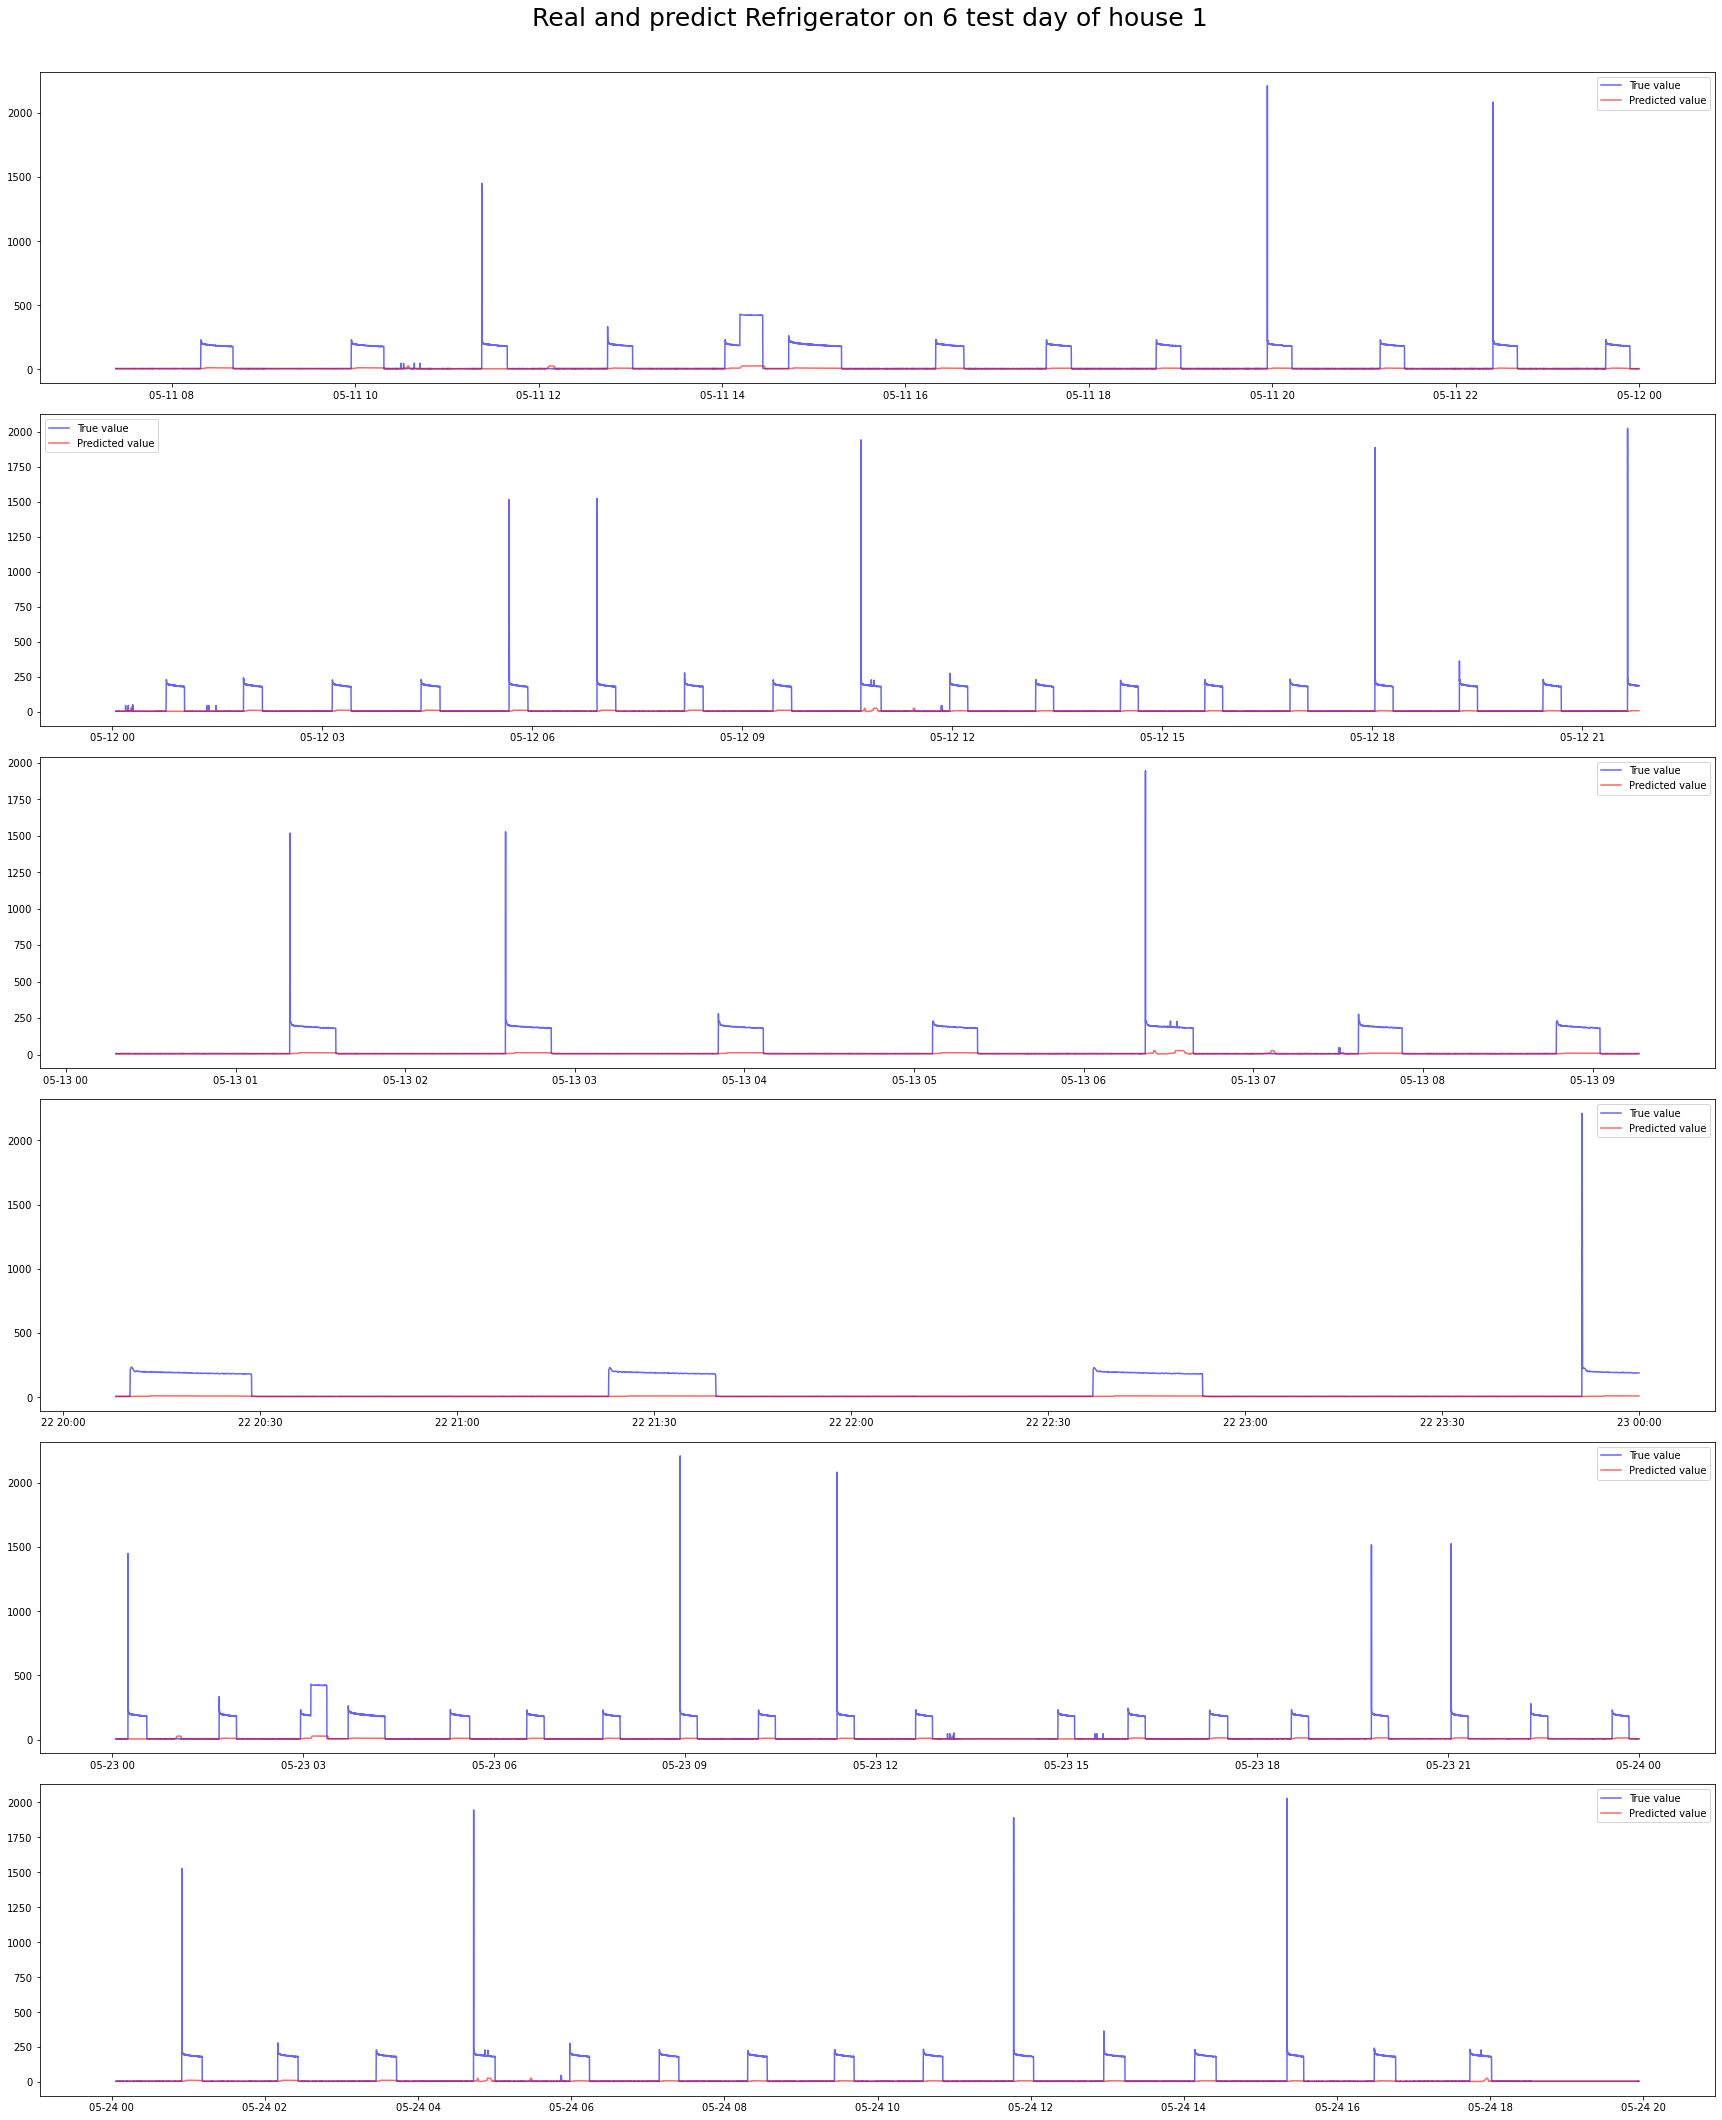

In [69]:
plot_each_app(df1_test, dates[1][17:], pred_lstm, y_test[:,2], 
              'Real and predict Refrigerator on 6 test day of house 1', look_back = 50)

#### Test LST model on house 2 

In [70]:
pred_lstm_h2 = model.predict(X_2).reshape(-1)
mse_loss_lstm_h2 = mse_loss(pred_lstm_h2, y_2)
mae_loss_lstm_h2 = mae_loss(pred_lstm_h2, y_2)
print('Mean square error on test set: ', mse_loss_lstm_h2)
print('Mean absolute error on the test set: ', mae_loss_lstm_h2)


Mean square error on test set:  11079.311212313009
Mean absolute error on the test set:  68.33117203862324


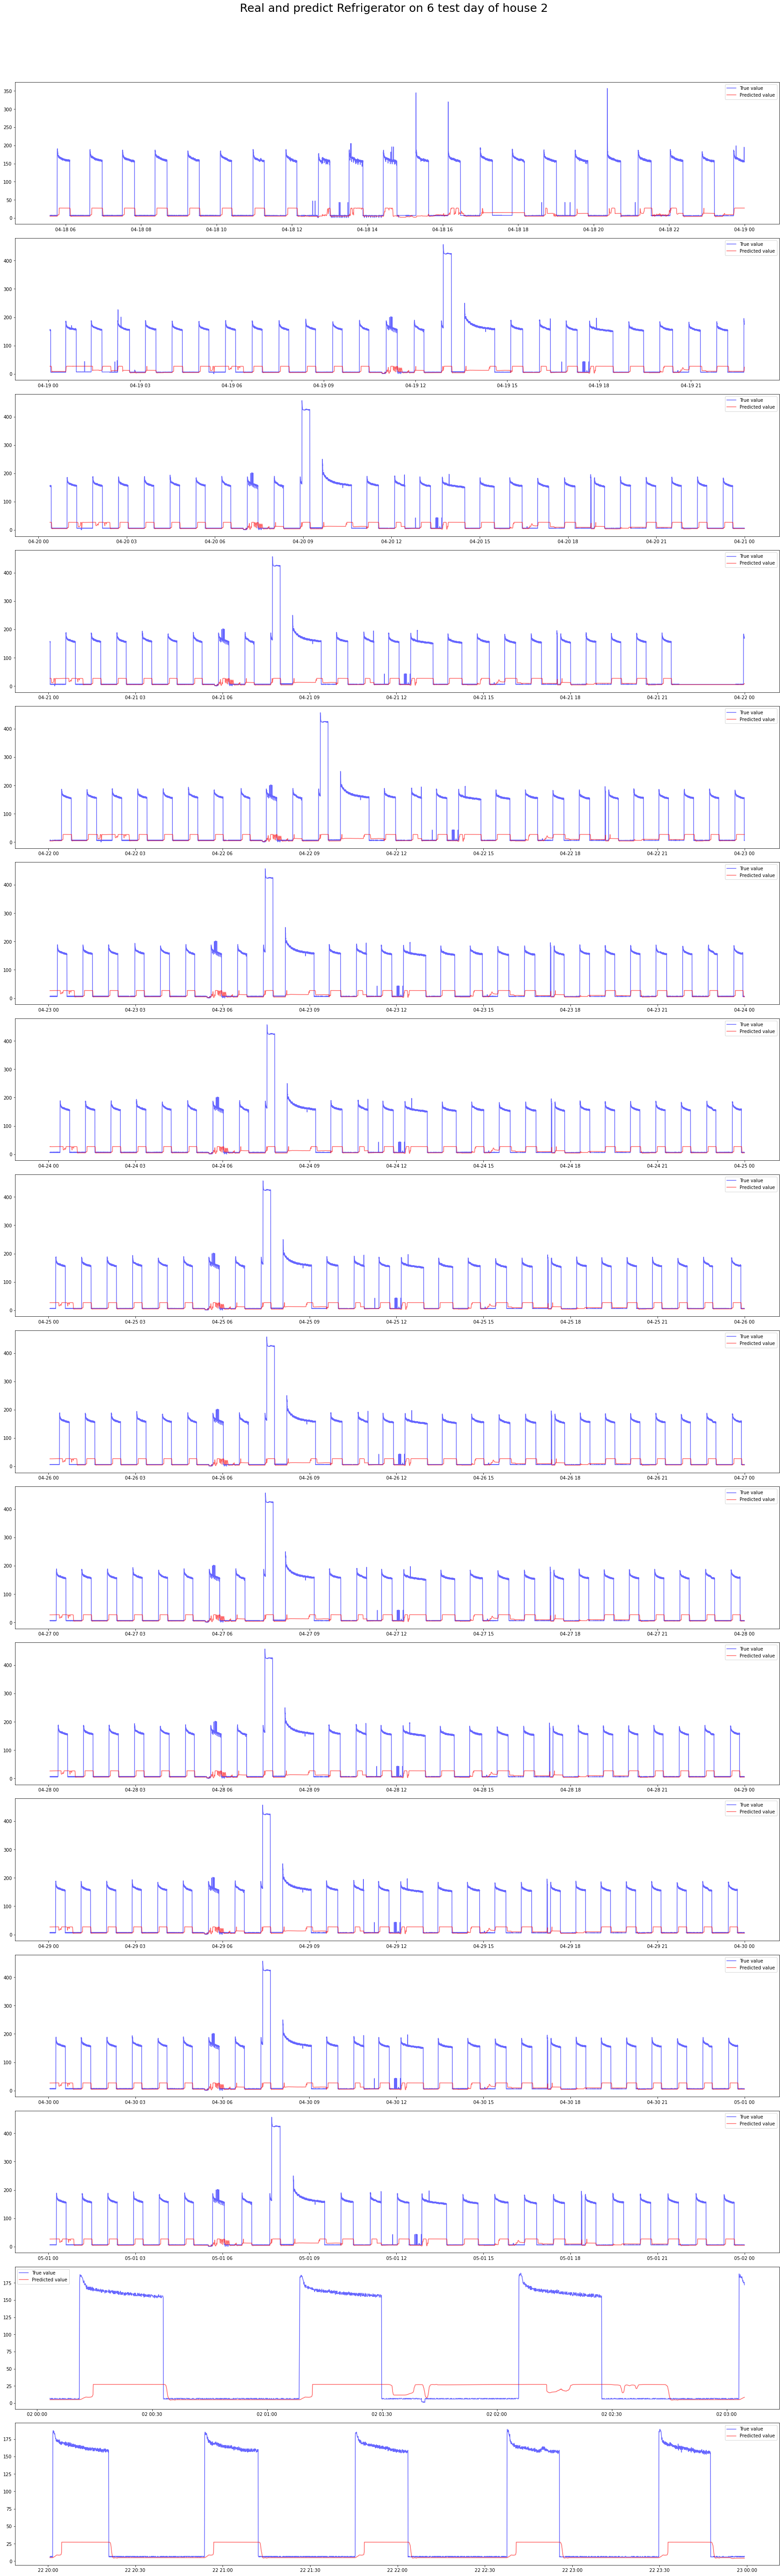

In [71]:
plot_each_app(df[2], dates[2], pred_lstm_h2, y_2, 
              'Real and predict Refrigerator on 6 test day of house 2', look_back = 50)

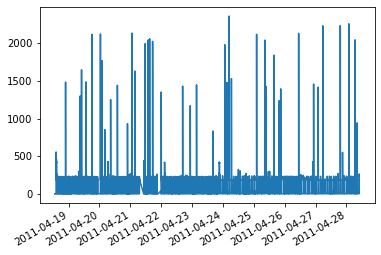

In [39]:
#One day
i=1
house1=df[i].loc[:dates[1][10]]
h1_fridge=house1[app1[0]]
h1_fridge.plot()


In [ ]:
##Export to csv (easy to import with powerbi)
for i in  range(1,7):
    df[i].to_csv('output{}.csv'.format(i))
